In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats
import math
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

from fasterrisk.fasterrisk import RiskScoreOptimizer, RiskScoreClassifier

from cleaning import *

In [3]:
code_dir = os.getcwd()

os.chdir('../Plots')
plots_dir = os.getcwd()

os.chdir('../Data')
data_dir = os.getcwd()

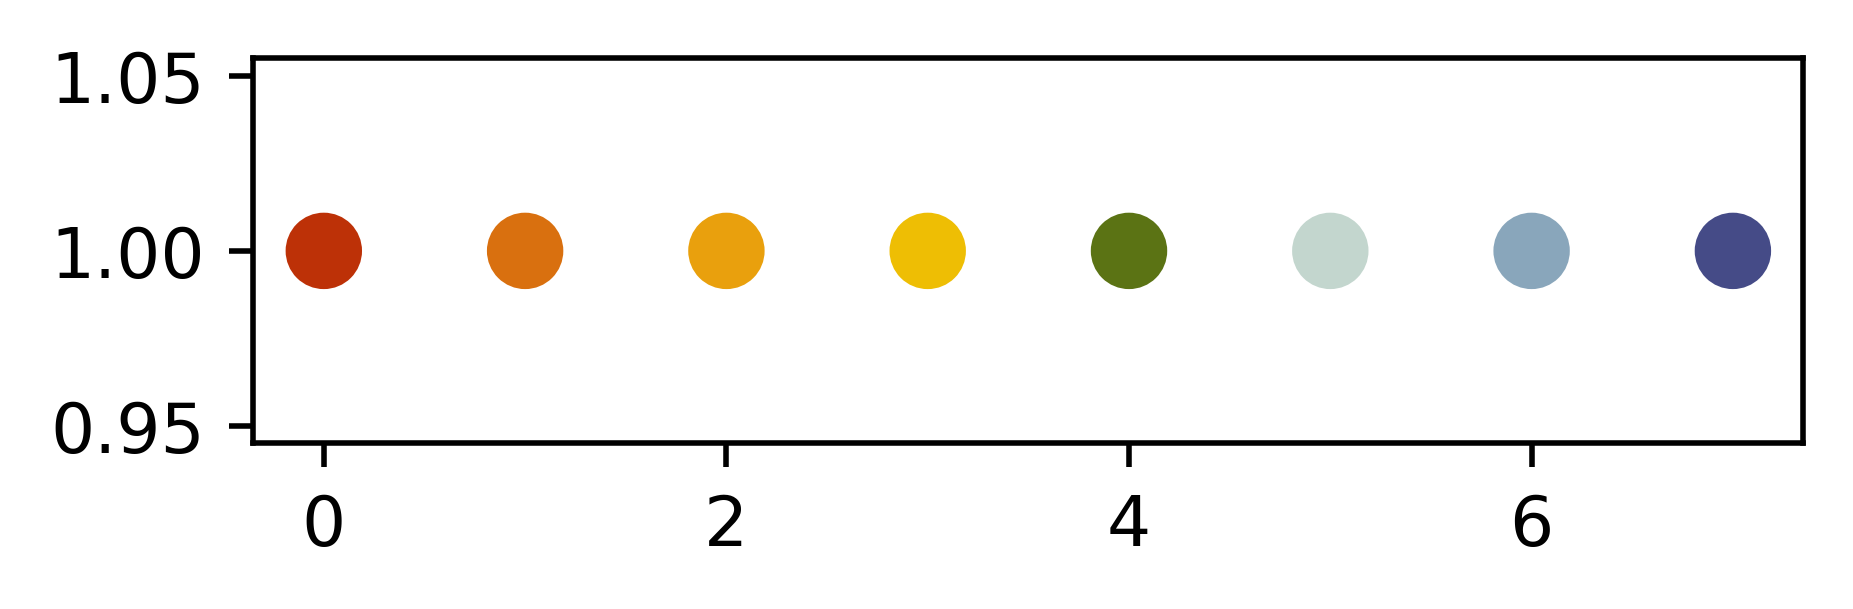

In [4]:
colors = ['#bd3107ff', '#d9700fff', '#e9a00dff', '#eebe04ff', '#5b7314ff', '#c3d6ceff', '#89a6bbff', '#454b87ff']
plt.figure(figsize=(4,1), dpi=500)
plt.scatter(y=np.ones(len(colors)), x=np.arange(len(colors)), color=colors, s=100)
plt.show()

palette = {'INSPIRE':colors[7],
           'eICU':colors[0]}

In [5]:
ward_vitals = pd.read_csv('INSPIRE/ward_vitals.csv')
labs = pd.read_csv('INSPIRE/labs.csv')
operations = pd.read_csv('INSPIRE/operations.csv')

In [6]:
wv_df = ward_vitals.loc[ward_vitals['item_name'] == 'vent'].dropna()
pts_with_vent_data = list(set(wv_df['subject_id']))
print(len(pts_with_vent_data))

8945


In [7]:
ward_vitals.head()
ward_vitals = ward_vitals.loc[ward_vitals['subject_id'].isin(pts_with_vent_data)]
ward_vitals

subject_id  chart_time item_name  value
124        140106882         -35      spo2   94.0
125        140106882         -35  nibp_sbp   85.0
126        140106882         -35        hr  120.0
127        140106882         -35  nibp_dbp   44.0
128        140106882         -35        bt   36.7
...              ...         ...       ...    ...
45795522   151288972        7440      iabp    1.0
45795523   151288972        7680      iabp    1.0
45795524   151288972        7740      iabp    1.0
45795525   151288972        7860      iabp    1.0
45795526   151288972        7890      iabp    1.0

[18565060 rows x 4 columns]

In [8]:
labs.head()
labs = labs.loc[labs['subject_id'].isin(pts_with_vent_data)]
labs

lab_features = ['albumin','glucose','ptinr','creatinine','wbc','hco3']

In [9]:
operations.head()
operations = operations.loc[operations['subject_id'].isin(pts_with_vent_data)]
operations

op_id  subject_id    hadm_id  case_id   opdate  age sex  weight  \
1       446270725   158995752  257857903      NaN        0   70   M    45.0   
14      487807079   145247513  259299532      NaN    74880   25   M    45.0   
22      480242953   187733661  238035661      NaN    10080   55   F    45.0   
23      462956682   162604840  267911567      NaN     5760   60   M    60.0   
24      485183540   160631734  285012362      NaN     1440   70   M    70.0   
...           ...         ...        ...      ...      ...  ...  ..     ...   
130627  410155274   101329743  206787794      NaN  4459680   65   F    50.0   
130739  491396553   156461031  282848329      NaN  3876480   30   F    40.0   
130915  494319208   150497300  289152391      NaN  3483360   80   F    50.0   
130937  465468763   150497300  289152391      NaN  3483360   80   F    50.0   
130955  449124488   138484174  228449654      NaN  4999680   50   F    60.0   

        height   race  ...  admission_time  discharge_time anstart_time  \
1        170.0  Asian  ...               0           70555       1345.0   
14       170.0  Asian  ...               0          109435      76070.0   
22       150.0  Asian  ...               0           34555      10560.0   
23       150.0  Asian  ...               0           23035       6785.0   
24       170.0  Asian  ...               0           11515       1935.0   
...        ...    ...  ...             ...             ...          ...   
130627   155.0  Asian  ...         4449600         4474075    4460160.0   
130739   155.0  Asian  ...         3875040         3879355    3877350.0   
130915   150.0  Asian  ...         3483360         3572635    3484775.0   
130937   150.0  Asian  ...         3483360         3572635    3484705.0   
130955   160.0  Asian  ...         4996800         5012635    5000390.0   

       anend_time cpbon_time  cpboff_time  icuin_time  icuout_time  \
1          1540.0        NaN          NaN      1550.0      19595.0   
14        76125.0        NaN          NaN     63275.0      78560.0   
22        11070.0    10665.0      10965.0     11080.0      19515.0   
23         7090.0        NaN          NaN      7095.0       8125.0   
24         2455.0     2080.0       2335.0      2455.0       4060.0   
...           ...        ...          ...         ...          ...   
130627  4460565.0  4460290.0    4460470.0   4460565.0    4466235.0   
130739  3877415.0        NaN          NaN         NaN          NaN   
130915  3485040.0        NaN          NaN   3485060.0    3513045.0   
130937  3484760.0        NaN          NaN   3485060.0    3513045.0   
130955  5000570.0        NaN          NaN         NaN          NaN   

        inhosp_death_time  allcause_death_time  
1                 69860.0             106560.0  
14                    NaN            2949120.0  
22                    NaN                  NaN  
23                    NaN                  NaN  
24                    NaN                  NaN  
...                   ...                  ...  
130627                NaN                  NaN  
130739                NaN                  NaN  
130915                NaN                  NaN  
130937                NaN                  NaN  
130955                NaN                  NaN  

[14268 rows x 29 columns]

In [10]:
time_vars = []
for col in operations.columns:
    if 'time' in str(col):
        time_vars.append(col)

operations[time_vars]    

orin_time  orout_time  opstart_time  opend_time  admission_time  \
1            1340        1550        1370.0      1540.0               0   
14          76065       76125       76095.0     76120.0               0   
22          10555       11080       10615.0     11070.0               0   
23           6780        7100        6840.0      7090.0               0   
24           1910        2450        2010.0      2440.0               0   
...           ...         ...           ...         ...             ...   
130627    4460135     4460565     4460225.0   4460565.0         4449600   
130739    3877345     3877425     3877360.0   3877410.0         3875040   
130915    3484770     3485040     3484810.0   3485035.0         3483360   
130937    3484705     3484765     3484710.0   3484750.0         3483360   
130955    5000380     5000570     5000410.0   5000570.0         4996800   

        discharge_time  anstart_time  anend_time  cpbon_time  cpboff_time  \
1                70555        1345.0      1540.0         NaN          NaN   
14              109435       76070.0     76125.0         NaN          NaN   
22               34555       10560.0     11070.0     10665.0      10965.0   
23               23035        6785.0      7090.0         NaN          NaN   
24               11515        1935.0      2455.0      2080.0       2335.0   
...                ...           ...         ...         ...          ...   
130627         4474075     4460160.0   4460565.0   4460290.0    4460470.0   
130739         3879355     3877350.0   3877415.0         NaN          NaN   
130915         3572635     3484775.0   3485040.0         NaN          NaN   
130937         3572635     3484705.0   3484760.0         NaN          NaN   
130955         5012635     5000390.0   5000570.0         NaN          NaN   

        icuin_time  icuout_time  inhosp_death_time  allcause_death_time  
1           1550.0      19595.0            69860.0             106560.0  
14         63275.0      78560.0                NaN            2949120.0  
22         11080.0      19515.0                NaN                  NaN  
23          7095.0       8125.0                NaN                  NaN  
24          2455.0       4060.0                NaN                  NaN  
...            ...          ...                ...                  ...  
130627   4460565.0    4466235.0                NaN                  NaN  
130739         NaN          NaN                NaN                  NaN  
130915   3485060.0    3513045.0                NaN                  NaN  
130937   3485060.0    3513045.0                NaN                  NaN  
130955         NaN          NaN                NaN                  NaN  

[14268 rows x 14 columns]

In [11]:
os.chdir(plots_dir)

Analyzing patient 153616384


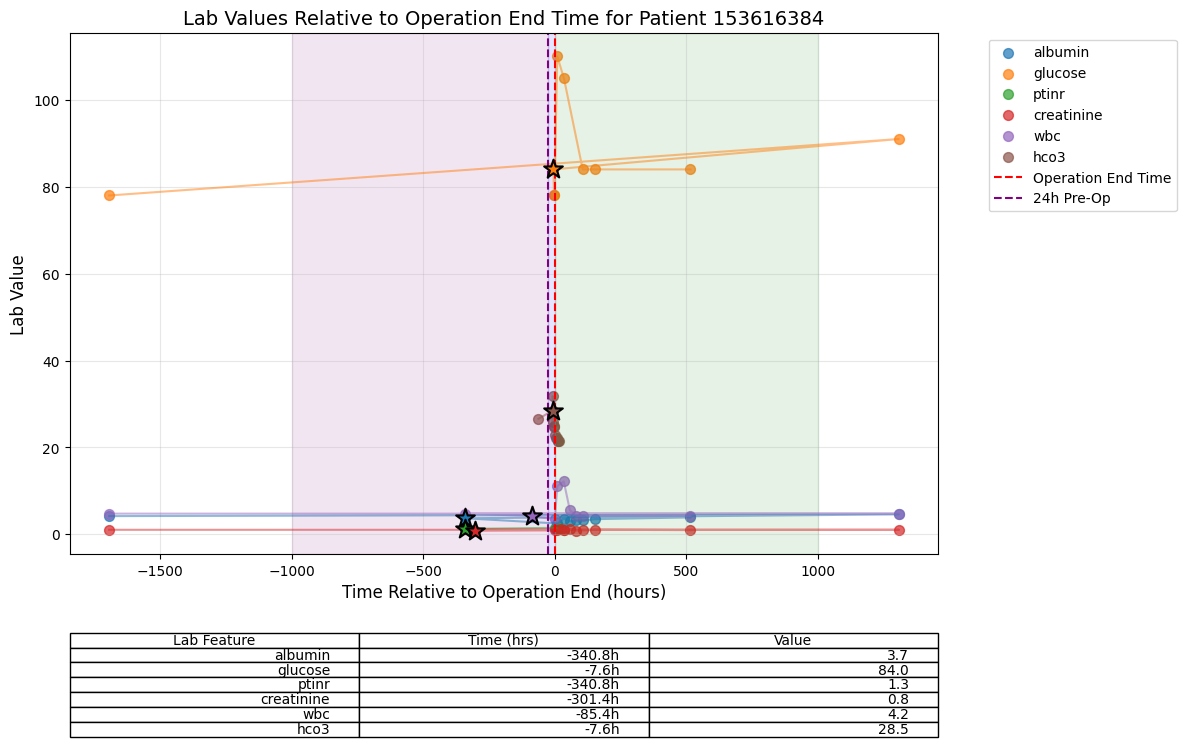

Analyzing patient 188579841


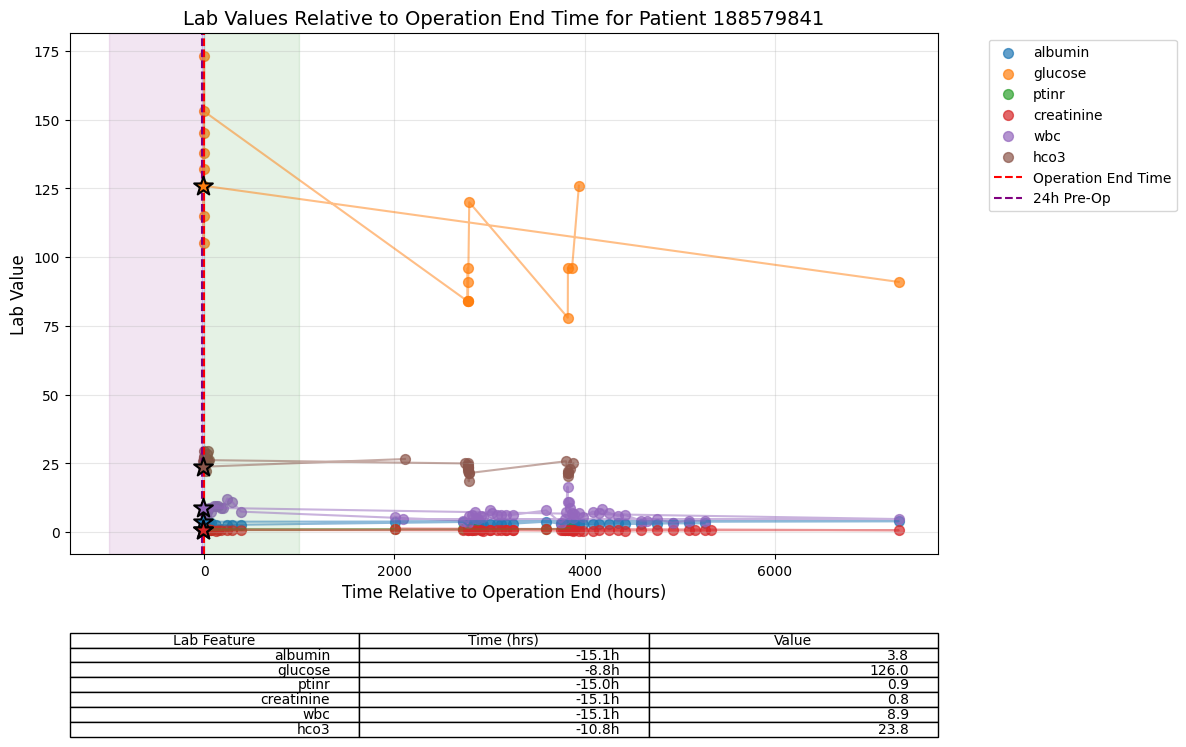

Analyzing patient 166035460


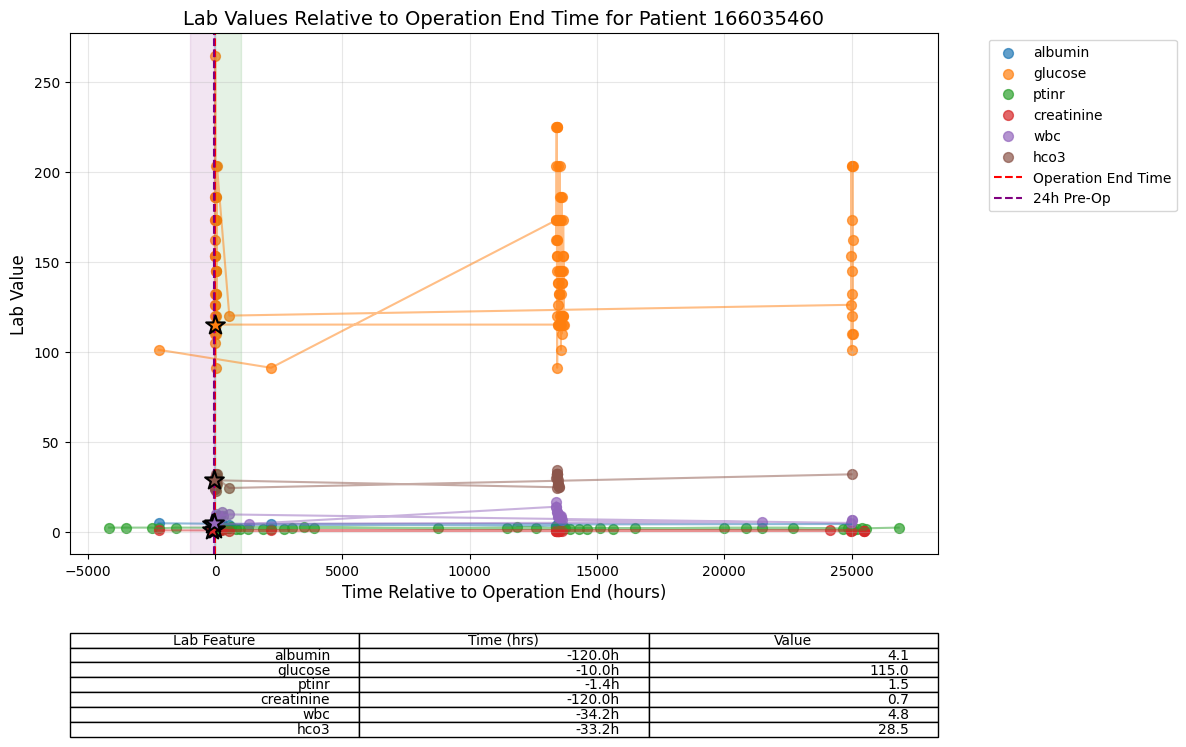

Analyzed 3 patients out of 8937 possible patients


In [12]:
from matplotlib.gridspec import GridSpec
from matplotlib.cm import tab10

def plot_labs_pre_vs_post_op(patient_id, lab_df, operation_df, lab_features):
    # Filter data for the specific patient
    patient_labs = lab_df[lab_df['subject_id'] == patient_id]
    patient_ops = operation_df[operation_df['subject_id'] == patient_id]
    
    if patient_ops.empty:
        print(f"No operation data for patient {patient_id}")
        return
    
    # Get the operation end time for reference
    anend_time = patient_ops['anend_time'].values[0]
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Create color map
    colors = tab10.colors
    
    # Dict to store selected measurements for each feature
    selected_measurements = {}
    
    # Plot each lab feature
    for i, feature in enumerate(lab_features):
        feature_data = patient_labs[patient_labs['item_name'] == feature]
        
        if feature_data.empty:
            print(f"No {feature} data for patient {patient_id}")
            continue
        
        # Calculate time relative to operation end time (in hours)
        feature_data = feature_data.copy()
        feature_data['relative_time'] = (feature_data['chart_time'] - anend_time) / 60  # Convert to hours
        
        # Plot the lab values with different colors by feature
        plt.scatter(feature_data['relative_time'], feature_data['value'], 
                    s=50, color=colors[i % len(colors)], alpha=0.7, label=feature)
        plt.plot(feature_data['relative_time'], feature_data['value'], 
                '-', alpha=0.5, color=colors[i % len(colors)])
        
        # SELECTION LOGIC FOR PRE-OP MEASUREMENTS:
        # Focus on measurements around 24 hours before surgery
        pre_op = feature_data[feature_data['relative_time'] < 0]
        
        if not pre_op.empty:
            # Find closest to -24h (24 hours before surgery)
            closest_idx = (pre_op['relative_time'] - (-24)).abs().idxmin()
            selected_measurement = pre_op.loc[closest_idx]
        else:
            # If no pre-op measurements exist, use earliest post-op as fallback
            selected_measurement = feature_data.iloc[feature_data['relative_time'].argmin()]
                
        # Store the selected measurement
        selected_measurements[feature] = selected_measurement
        
        # Star the selected measurement
        plt.scatter(selected_measurement['relative_time'], selected_measurement['value'], 
                   s=200, marker='*', color=colors[i % len(colors)], 
                   edgecolor='black', linewidth=1.5, zorder=10)
    
    # Add reference lines
    plt.axvline(x=0, color='red', linestyle='--', label='Operation End Time')
    plt.axvline(x=-24, color='purple', linestyle='--', label='24h Pre-Op')
    
    # Add labels and legend
    plt.title(f'Lab Values Relative to Operation End Time for Patient {patient_id}', fontsize=14)
    plt.xlabel('Time Relative to Operation End (hours)', fontsize=12)
    plt.ylabel('Lab Value', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Mark the zones
    plt.axvspan(-1000, -24, alpha=0.1, color='purple', label='>24h Pre-Op')
    plt.axvspan(-24, 0, alpha=0.1, color='blue', label='0-24h Pre-Op')
    plt.axvspan(0, 1000, alpha=0.1, color='green', label='Post-Op')
    
    # Add a table with the selected measurements
    table_data = []
    for feature in lab_features:
        if feature in selected_measurements:
            sm = selected_measurements[feature]
            table_data.append([
                feature,
                f"{sm['relative_time']:.1f}h",
                f"{sm['value']:.1f}"
            ])
    
    table_cols = ['Lab Feature', 'Time (hrs)', 'Value']
    table = plt.table(cellText=table_data, colLabels=table_cols, 
                     loc='bottom', bbox=[0.0, -0.35, 1.0, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)  # Make room for the table
    plt.savefig(f'LabValues_{patient_id}.png', transparent=True, dpi=500)
    plt.show()
    
    # Return the selected measurements for further analysis
    return selected_measurements

# Function to process and plot multiple patients
def analyze_multiple_patients(lab_df, operation_df, lab_features, max_patients=5):
    # Find patients with both lab and operation data
    lab_patients = set(lab_df['subject_id'].unique())
    op_patients = set(operation_df['subject_id'].unique())
    
    patients_with_both = lab_patients.intersection(op_patients)
    
    selected_patients = []
    all_selected_measurements = {}
    
    # Filter to patients who have most of the specified lab features
    for patient in patients_with_both:
        patient_labs = lab_df[lab_df['subject_id'] == patient]
        feature_count = sum(feature in patient_labs['item_name'].values for feature in lab_features)
        if feature_count >= len(lab_features) * 0.6:  # At least 60% of features
            selected_patients.append((patient, feature_count))
    
    # Sort patients by number of available features (descending)
    selected_patients.sort(key=lambda x: x[1], reverse=True)
    
    # Plot for top patients
    for patient_id, _ in selected_patients[:max_patients]:
        print(f"Analyzing patient {patient_id}")
        selected_measurements = plot_labs_pre_vs_post_op(
            patient_id, lab_df, operation_df, lab_features)
        
        all_selected_measurements[patient_id] = selected_measurements
    
    print(f"Analyzed {len(selected_patients[:max_patients])} patients out of {len(patients_with_both)} possible patients")
    
    return all_selected_measurements


# Call the function to analyze multiple patients
selected_measurements = analyze_multiple_patients(labs, operations, lab_features, max_patients=3)

Shape after column selection: (13961, 9)
Shape after duration filtering: (11745, 14)
Final shape of operations_sub: (11745, 12)

Selected lab values summary:
Total patients with operations: 8278
Patients with at least one selected lab: 8276
Total selected lab measurements: 69644
  - albumin: 11702 values (141.4% of patients)
  - glucose: 11565 values (139.7% of patients)
  - ptinr: 11699 values (141.3% of patients)
  - creatinine: 11733 values (141.7% of patients)
  - wbc: 11701 values (141.4% of patients)
  - hco3: 11244 values (135.8% of patients)


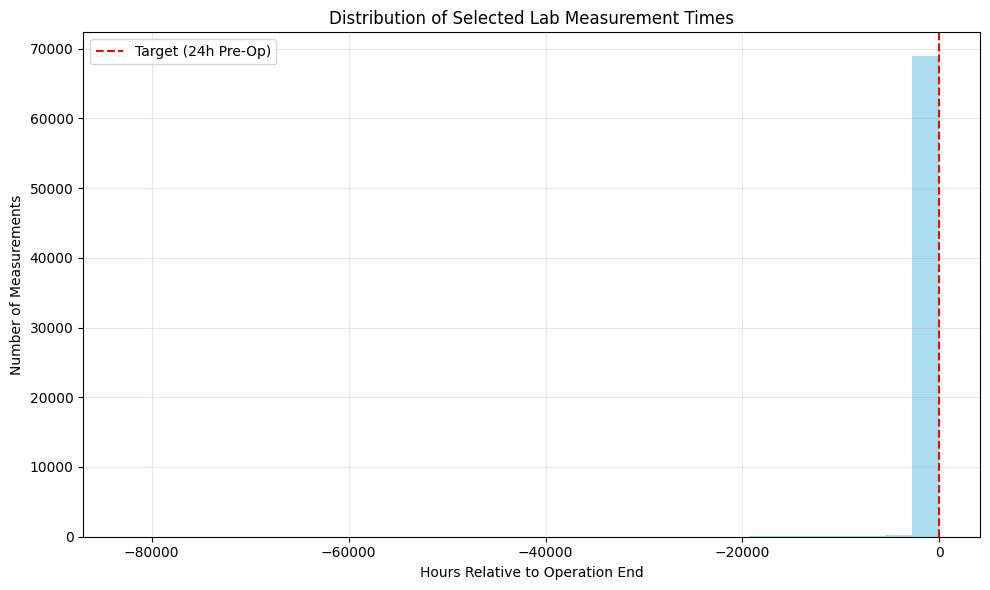

In [13]:
# First process operations data
operations = operations[(operations['height'] > 0) & (operations['weight'] > 0) &
                         operations['height'].notna() & operations['weight'].notna()]

operations_features = []
for col in ['op_id','subject_id','age','height','weight','anstart_time','anend_time','icd10_pcs','antype']:
  if col not in operations.columns:
    print(f'{col} not in columns')
  else:
    operations_features.append(col)

# Create a copy of the filtered data
valid_heights = operations['height'].between(50, 250, inclusive='both')
valid_weights = operations['weight'].between(20, 300, inclusive='both')
operations_filtered = operations[valid_heights & valid_weights].copy()

# Select columns
operations_sub = operations_filtered[operations_features].copy()
print(f"Shape after column selection: {operations_sub.shape}")

# Convert height from cm to meters for BMI calculation
operations_sub['height_m'] = operations_sub['height']/100  # Convert cm to meters

# Calculate BMI
operations_sub['BMI'] = operations_sub.apply(
    lambda row: row['weight'] / (row['height_m'] ** 2),
    axis=1
)
operations_sub['BMI'] = operations_sub.apply(
    lambda row: np.nan if (row['BMI'] > 70 or row['BMI'] < 10) else row['BMI'],
    axis=1
)

# Process anesthesia times
if 'anstart_time' in operations_sub.columns and 'anend_time' in operations_sub.columns:
    try:
        # Convert float military time to minutes
        def military_time_to_minutes(time_float):
            if pd.isna(time_float):
                return np.nan

            # Extract hours and minutes
            hours = int(time_float // 100)
            minutes = int(time_float % 100)

            # Handle potential overflow (e.g., 2400 should be 0)
            hours = hours % 24

            # Convert to total minutes
            return hours * 60 + minutes

        # Calculate start and end times in minutes
        operations_sub['start_minutes'] = operations_sub['anstart_time'].apply(military_time_to_minutes)
        operations_sub['end_minutes'] = operations_sub['anend_time'].apply(military_time_to_minutes)

        # Calculate duration - handling cases where end time is on the next day
        operations_sub['anesthesia_duration'] = operations_sub.apply(
            lambda row: row['end_minutes'] - row['start_minutes'] if row['end_minutes'] >= row['start_minutes']
                        else row['end_minutes'] + 24*60 - row['start_minutes'],
            axis=1
        )

        # Filter out invalid durations
        operations_sub = operations_sub[operations_sub['anesthesia_duration'] >= 60]
        print(f"Shape after duration filtering: {operations_sub.shape}")

        # Optionally drop the intermediate columns
        operations_sub = operations_sub.drop(['start_minutes', 'end_minutes'], axis=1)

    except Exception as e:
        print(f"Error processing times: {e}")
        operations_sub['anesthesia_duration'] = np.nan
else:
    print("Time columns not found in dataframe")

print(f"Final shape of operations_sub: {operations_sub.shape}")




def select_preop_lab_values(operations_df, labs_df, lab_features, target_hours_before=-24):
    """
    Select lab values closest to the target hours before surgery for each patient.
    Returns both a dataframe of selected values and a dictionary mapping for easy lookup.
    """
    # Create empty lists to store results
    selected_labs_rows = []
    
    # Create a dictionary to store selected measurements by patient and feature
    selected_labs_dict = {}
    
    # Process each patient
    for _, operation_row in operations_df.iterrows():
        patient_id = operation_row['subject_id']
        anend_time = operation_row['anend_time']
        
        # Initialize patient dictionary if not exists
        if patient_id not in selected_labs_dict:
            selected_labs_dict[patient_id] = {}
        
        # Get labs for this patient
        patient_labs = labs_df[labs_df['subject_id'] == patient_id]
        
        # For each lab feature
        for feature in lab_features:
            feature_data = patient_labs[patient_labs['item_name'] == feature]
            
            if feature_data.empty:
                continue
                
            # Calculate relative time in hours
            feature_data = feature_data.copy()
            feature_data['relative_time'] = (feature_data['chart_time'] - anend_time) / 60  # Convert to hours
            
            # Find pre-op measurements
            pre_op = feature_data[feature_data['relative_time'] < 0]
            
            if not pre_op.empty:
                # Find measurement closest to target hours before surgery
                closest_idx = (pre_op['relative_time'] - target_hours_before).abs().idxmin()
                selected = pre_op.loc[closest_idx]
                
                # Store in dictionary
                selected_labs_dict[patient_id][feature] = {
                    'value': selected['value'],
                    'chart_time': selected['chart_time'],
                    'relative_time': selected['relative_time']
                }
                
                # Create a row for the result DataFrame
                result_row = {
                    'subject_id': patient_id,
                    'operation_id': operation_row['op_id'] if 'op_id' in operation_row else None,
                    'lab_feature': feature,
                    'lab_value': selected['value'],
                    'lab_time': selected['chart_time'],
                    'op_time': anend_time,
                    'relative_time_hours': selected['relative_time'],
                    'BMI': operation_row['BMI'] if 'BMI' in operation_row else None,
                    'age': operation_row['age'] if 'age' in operation_row else None,
                    'anesthesia_duration': operation_row['anesthesia_duration'] if 'anesthesia_duration' in operation_row else None
                }
                
                selected_labs_rows.append(result_row)
    
    # Convert to DataFrame
    if selected_labs_rows:
        selected_labs_df = pd.DataFrame(selected_labs_rows)
        return selected_labs_df, selected_labs_dict
    else:
        return pd.DataFrame(), {}

# Select pre-op lab values
selected_labs_df, selected_labs_dict = select_preop_lab_values(operations_sub, labs, lab_features)

# Print summary statistics
print(f"\nSelected lab values summary:")
print(f"Total patients with operations: {operations_sub['subject_id'].nunique()}")
print(f"Patients with at least one selected lab: {selected_labs_df['subject_id'].nunique()}")
print(f"Total selected lab measurements: {len(selected_labs_df)}")

# Print lab feature statistics
for feature in lab_features:
    feature_count = len(selected_labs_df[selected_labs_df['lab_feature'] == feature])
    feature_pct = (feature_count / operations_sub['subject_id'].nunique()) * 100
    print(f"  - {feature}: {feature_count} values ({feature_pct:.1f}% of patients)")

# Optionally: Visualize time distribution of selected labs
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.hist(selected_labs_df['relative_time_hours'], bins=30, alpha=0.7, color='skyblue')
    plt.axvline(x=-24, color='red', linestyle='--', label='Target (24h Pre-Op)')
    plt.xlabel('Hours Relative to Operation End')
    plt.ylabel('Number of Measurements')
    plt.title('Distribution of Selected Lab Measurement Times')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    #plt.savefig(f'{}.png', transparent=True, dpi=500)
    plt.show()
except Exception as e:
    print(f"Error creating visualization: {e}")

# Example of accessing values from the dictionary:
# To get glucose value for patient 12345:
# if 12345 in selected_labs_dict and 'glucose' in selected_labs_dict[12345]:
#     glucose_value = selected_labs_dict[12345]['glucose']['value']

age: min = 20, max = 90 


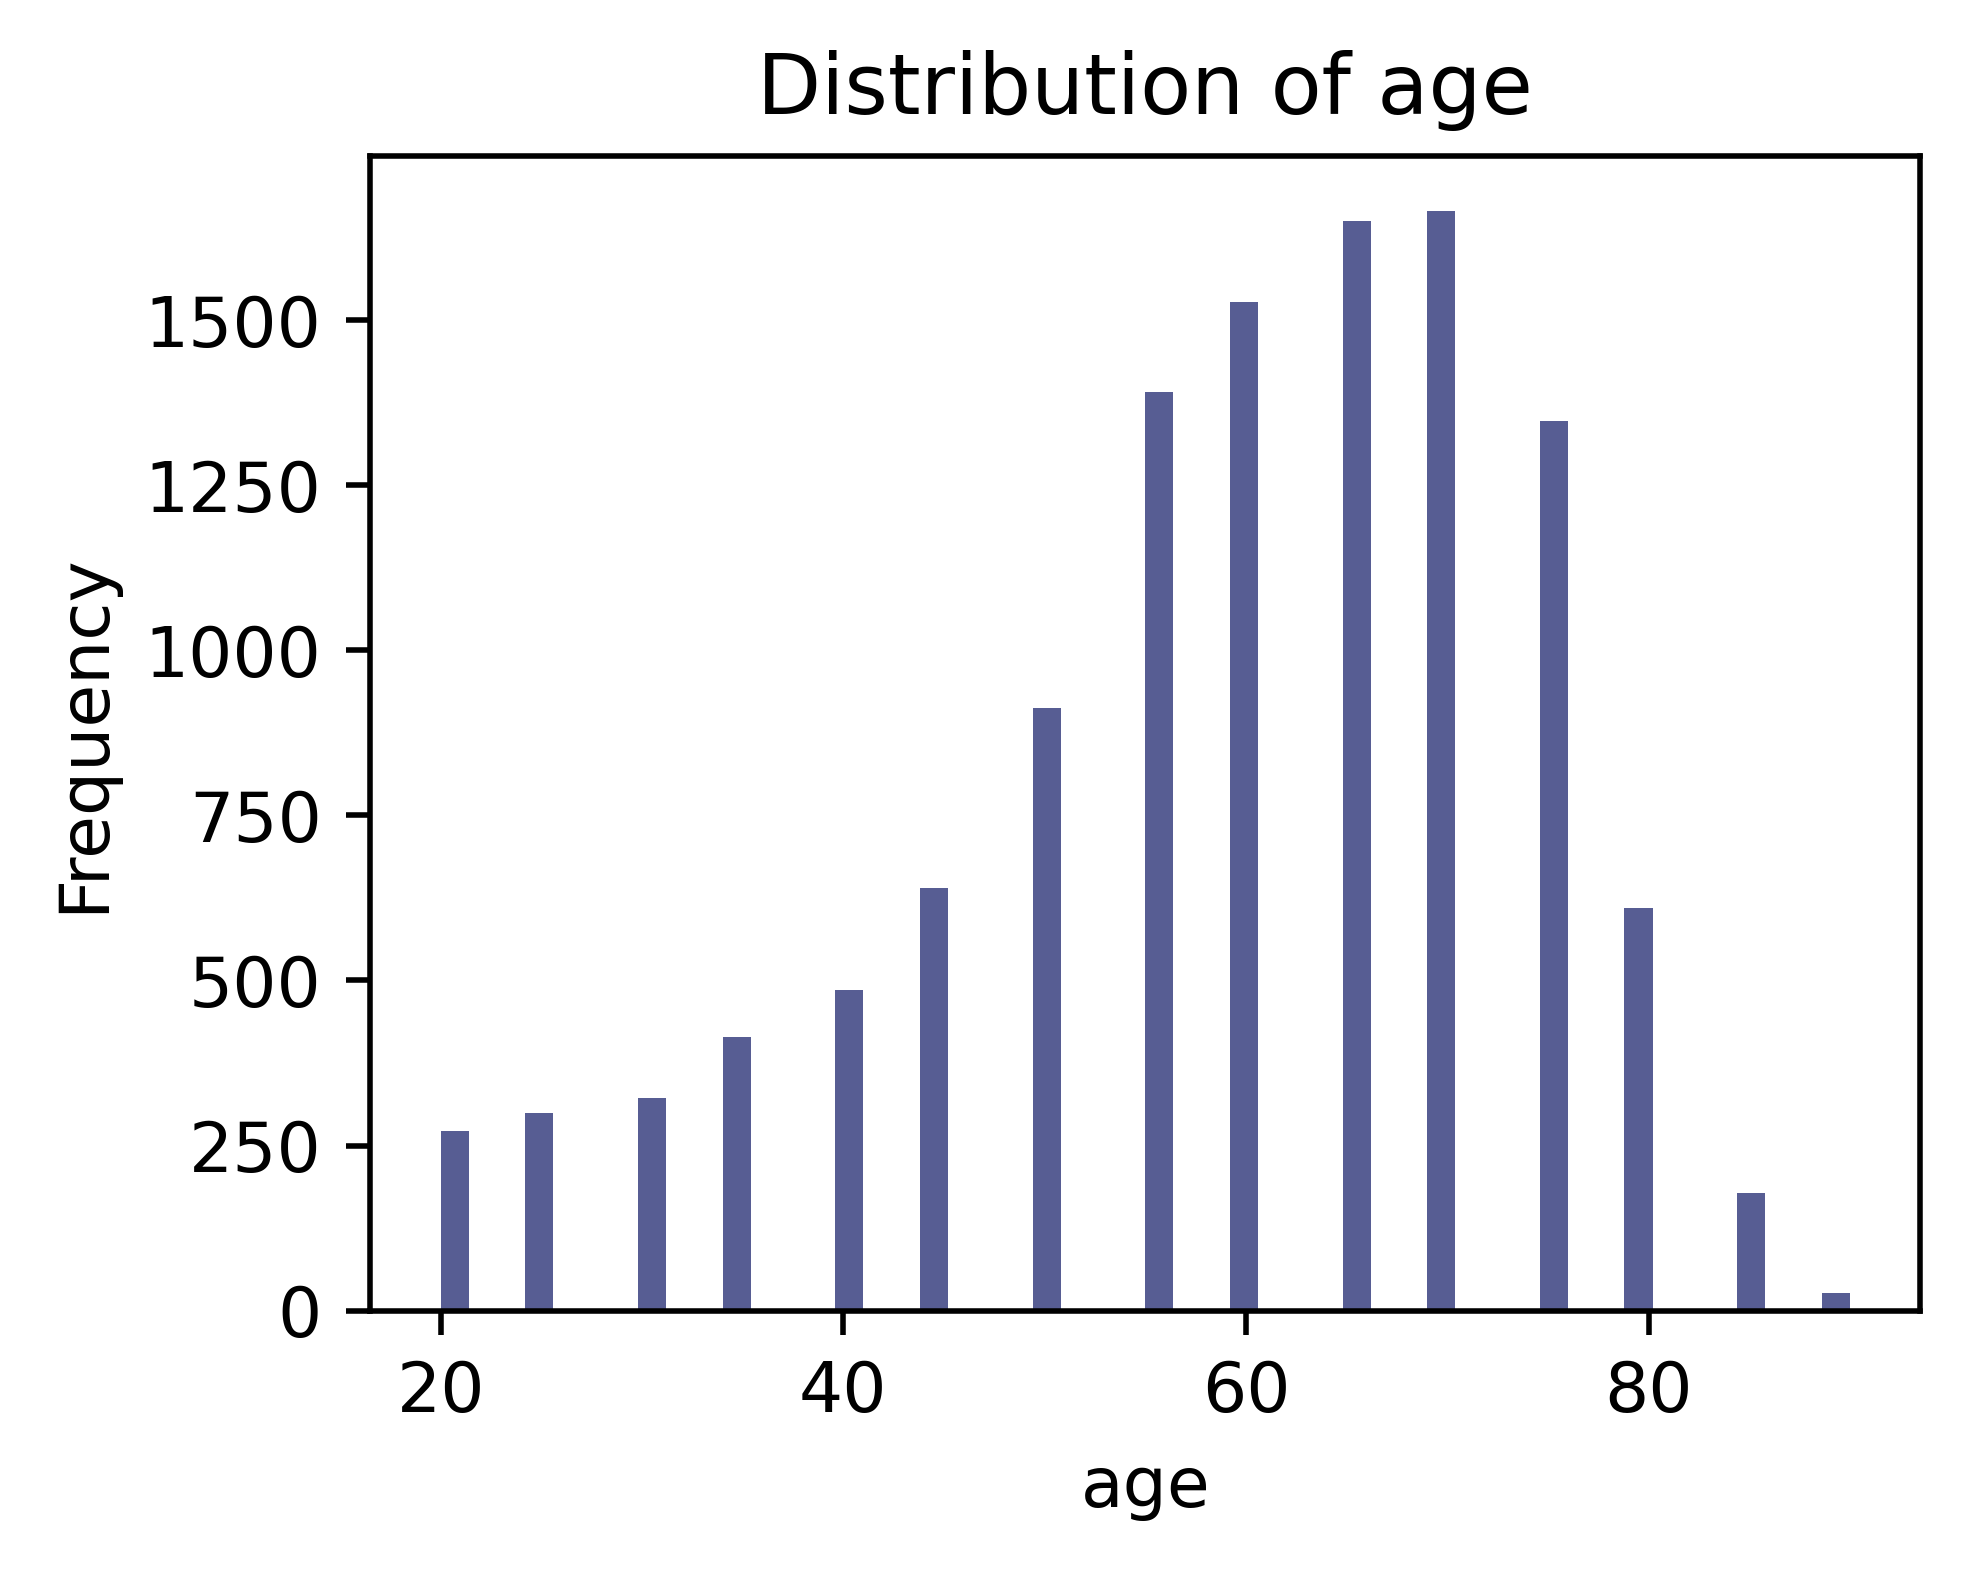

height: min = 50.0, max = 200.0 


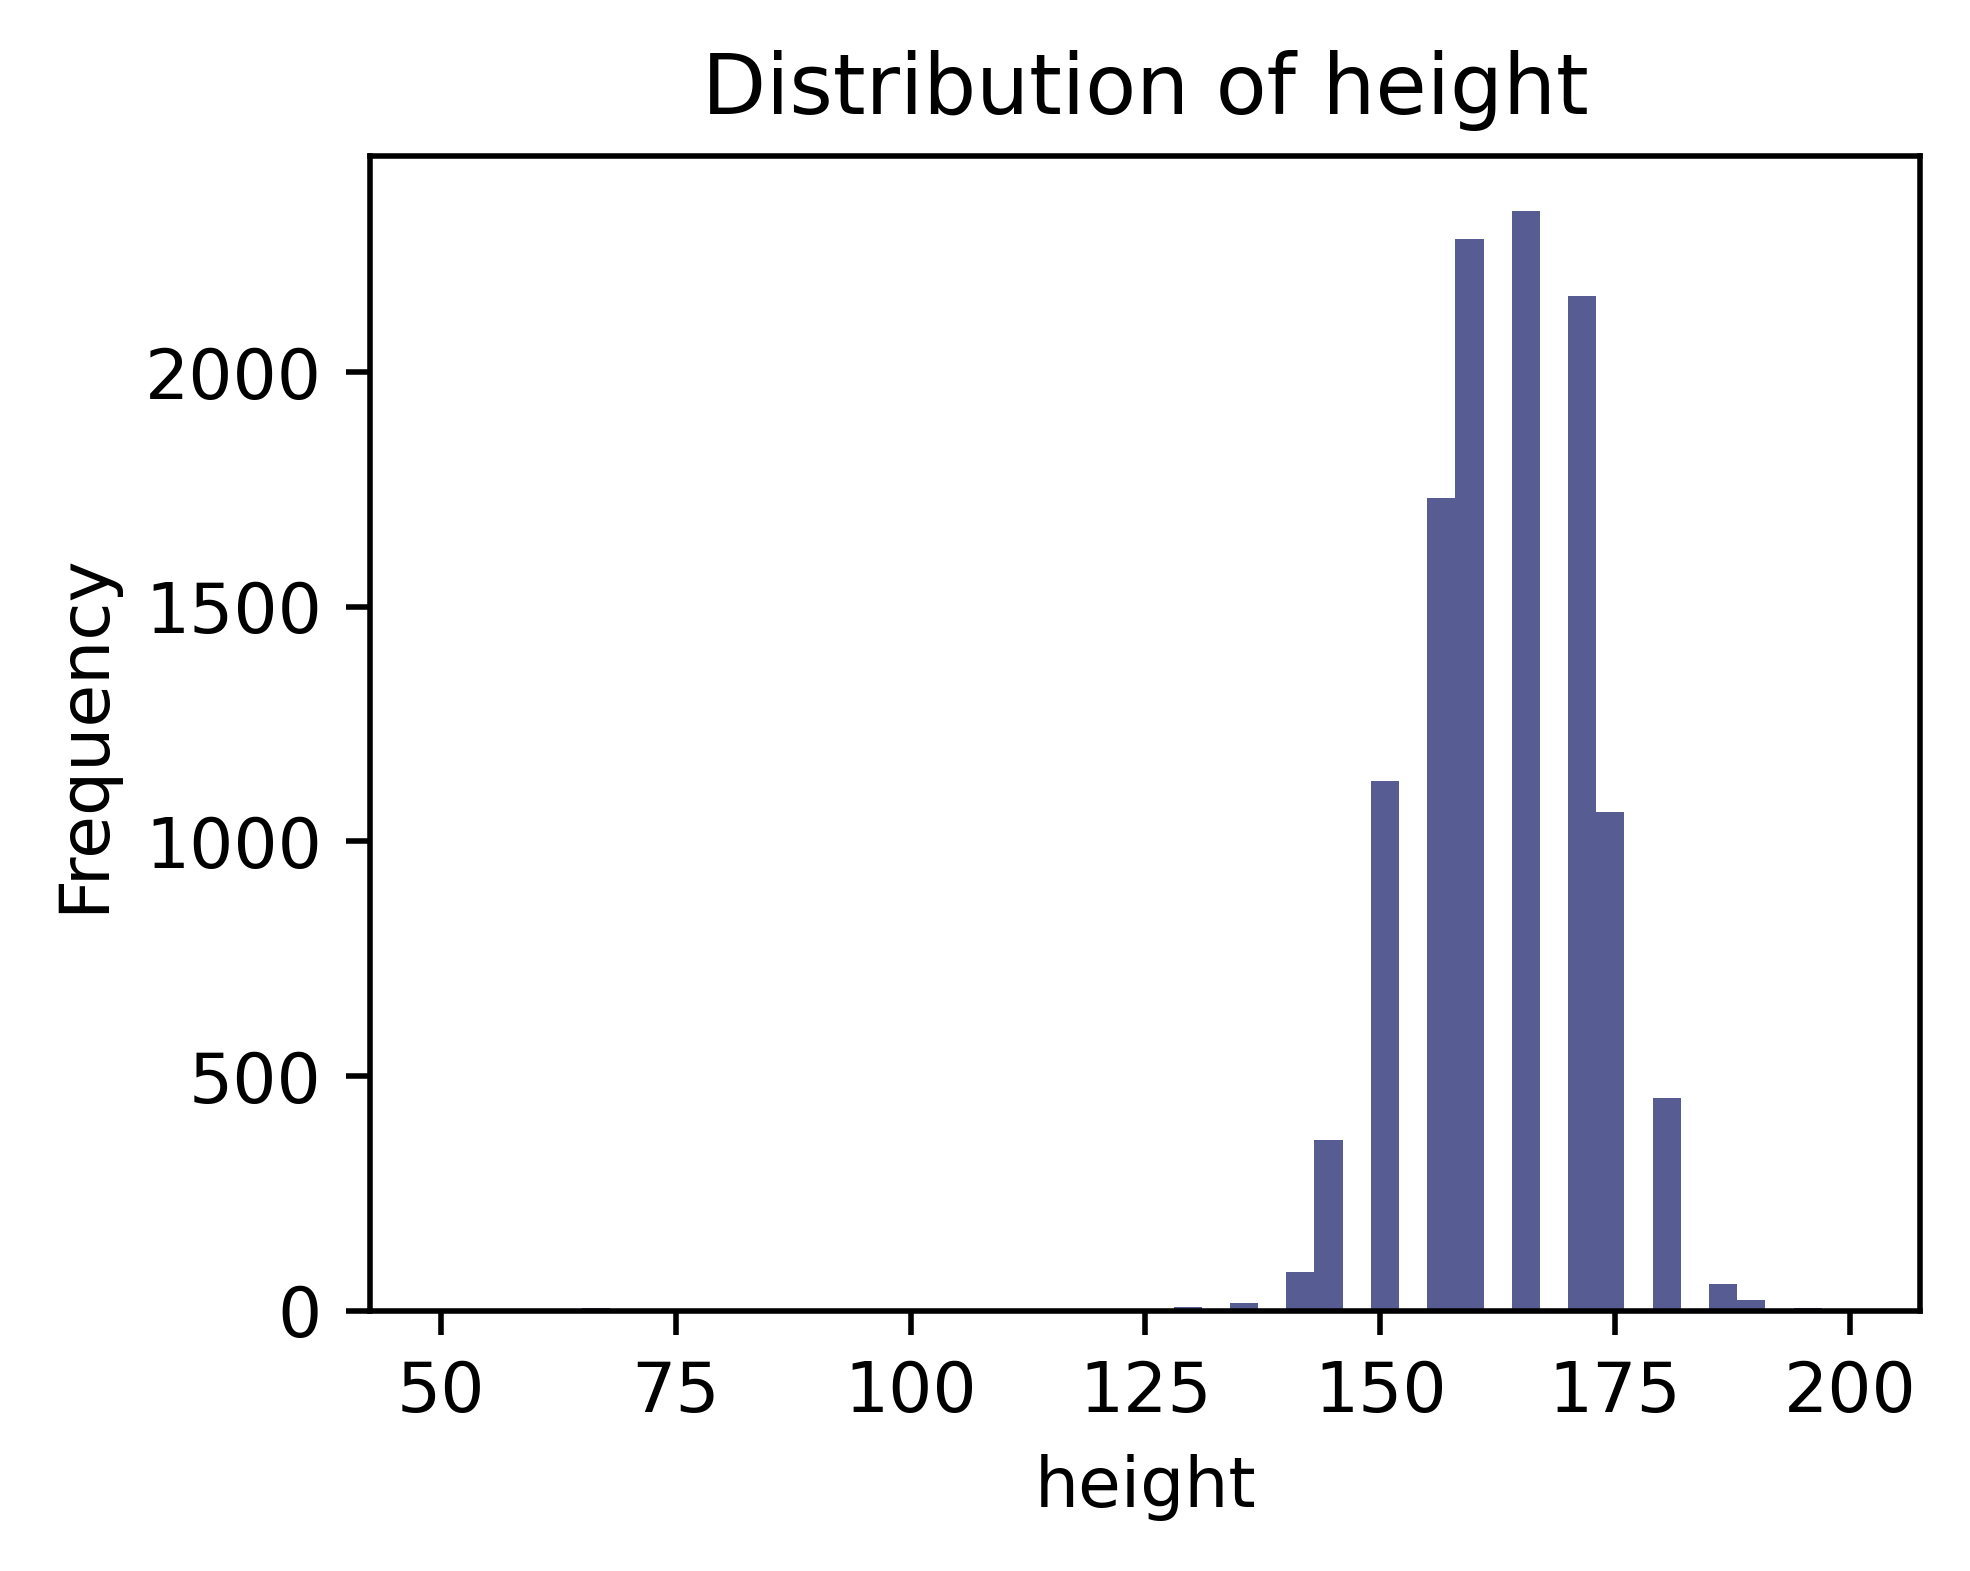

weight: min = 20.0, max = 175.0 


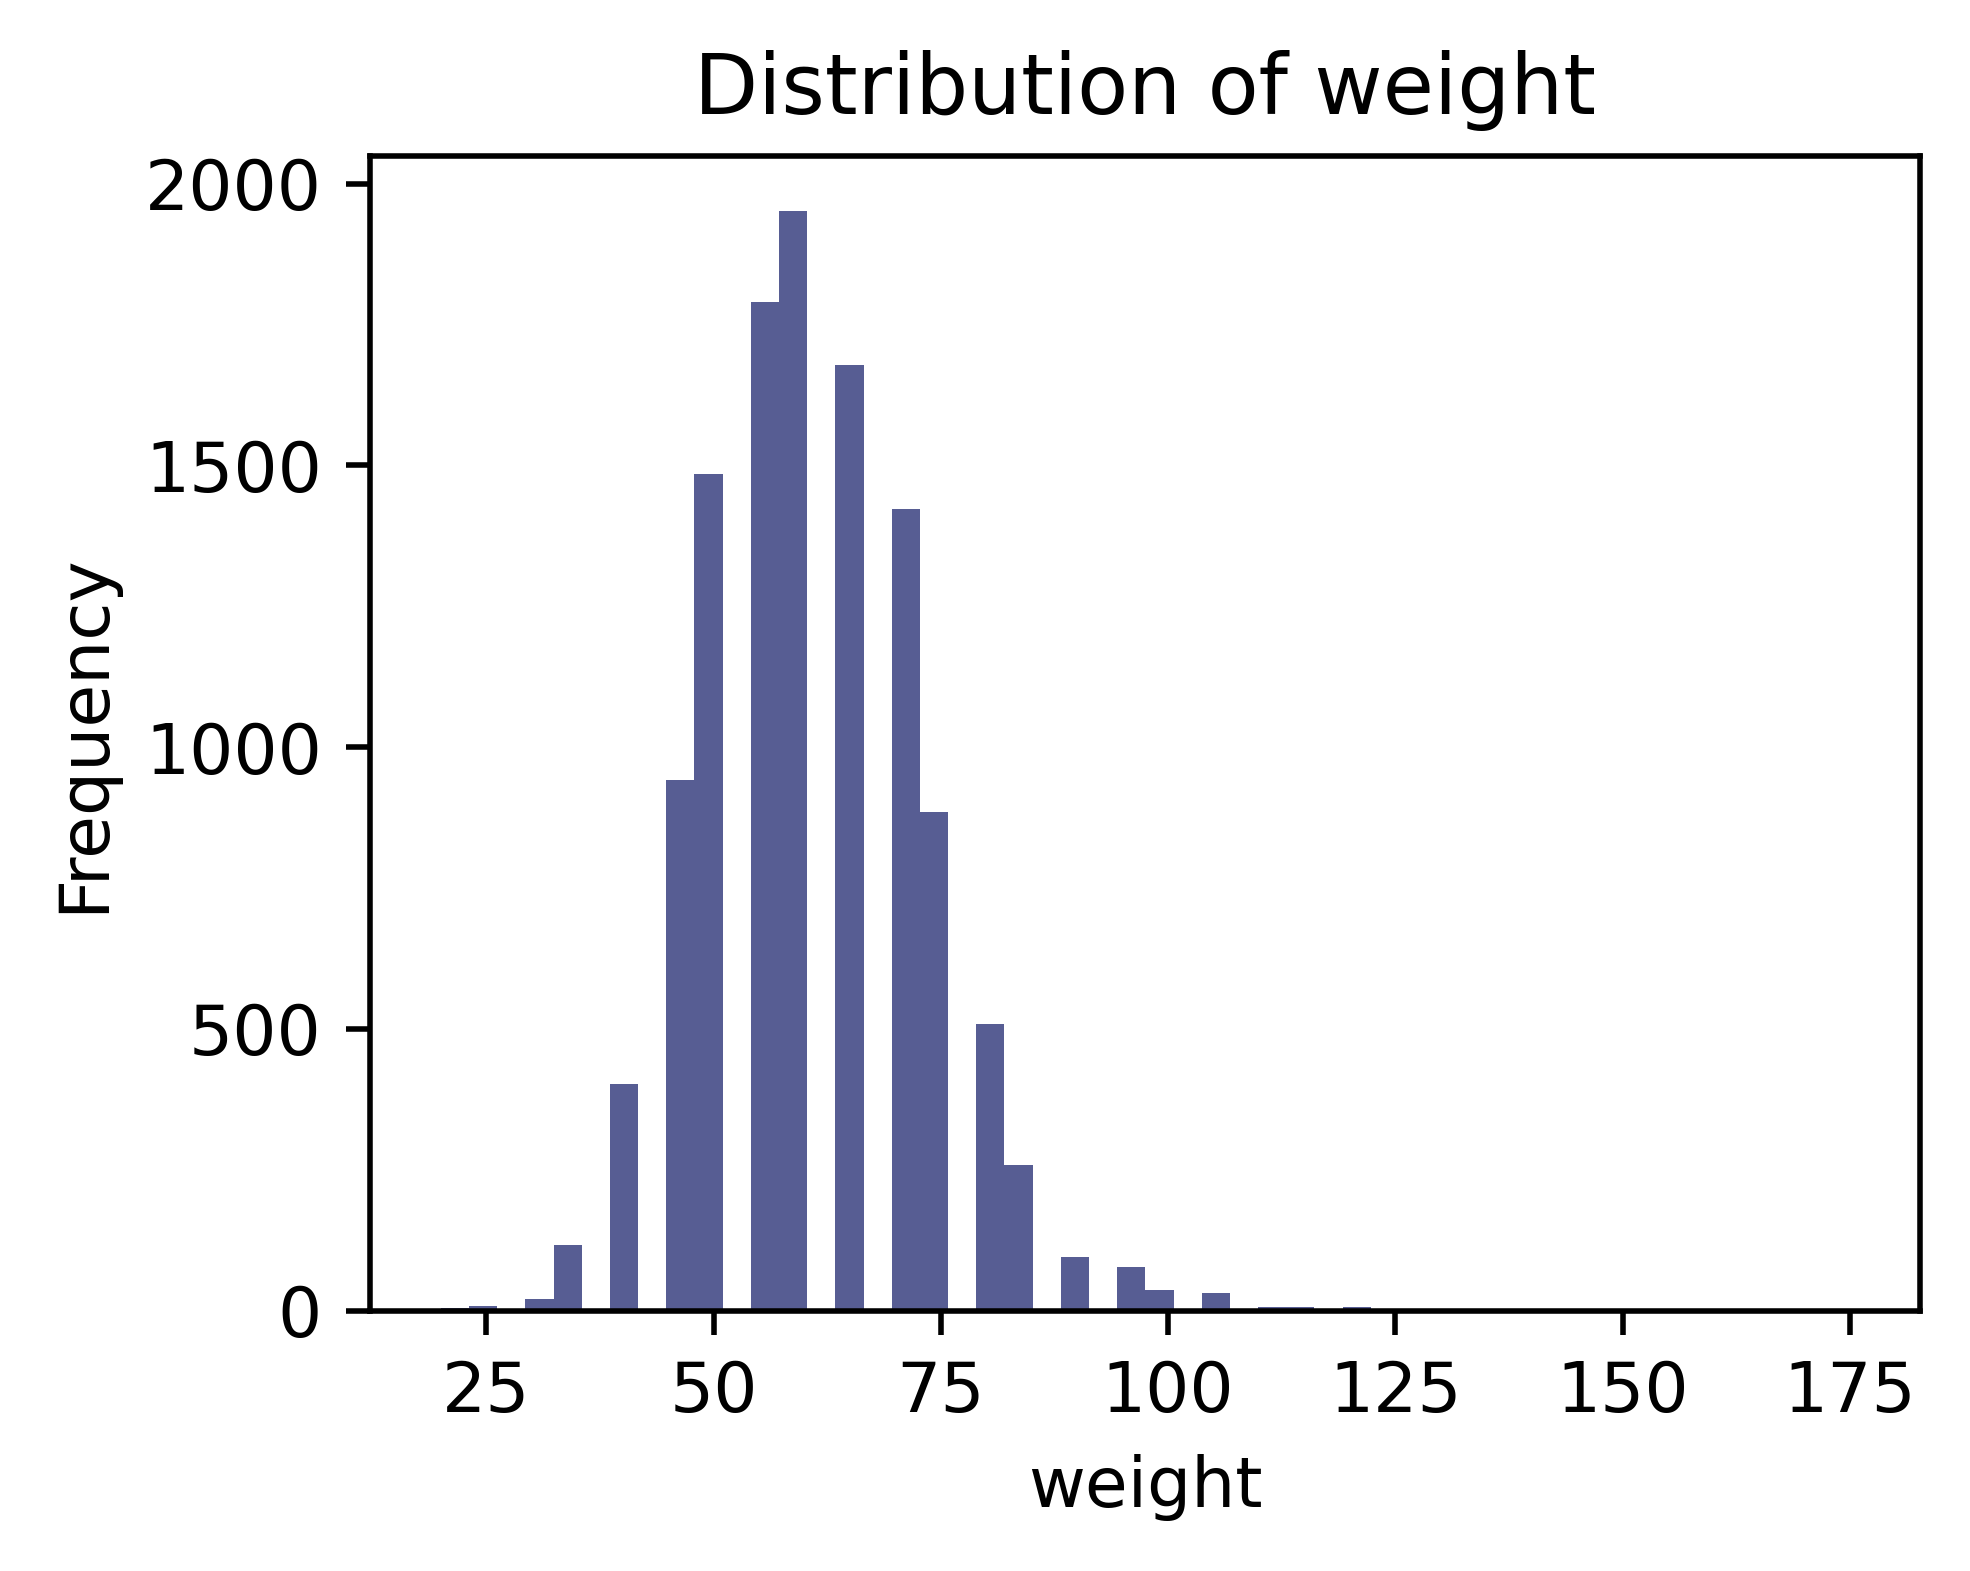

anstart_time: min = 5.0, max = 5133090.0 


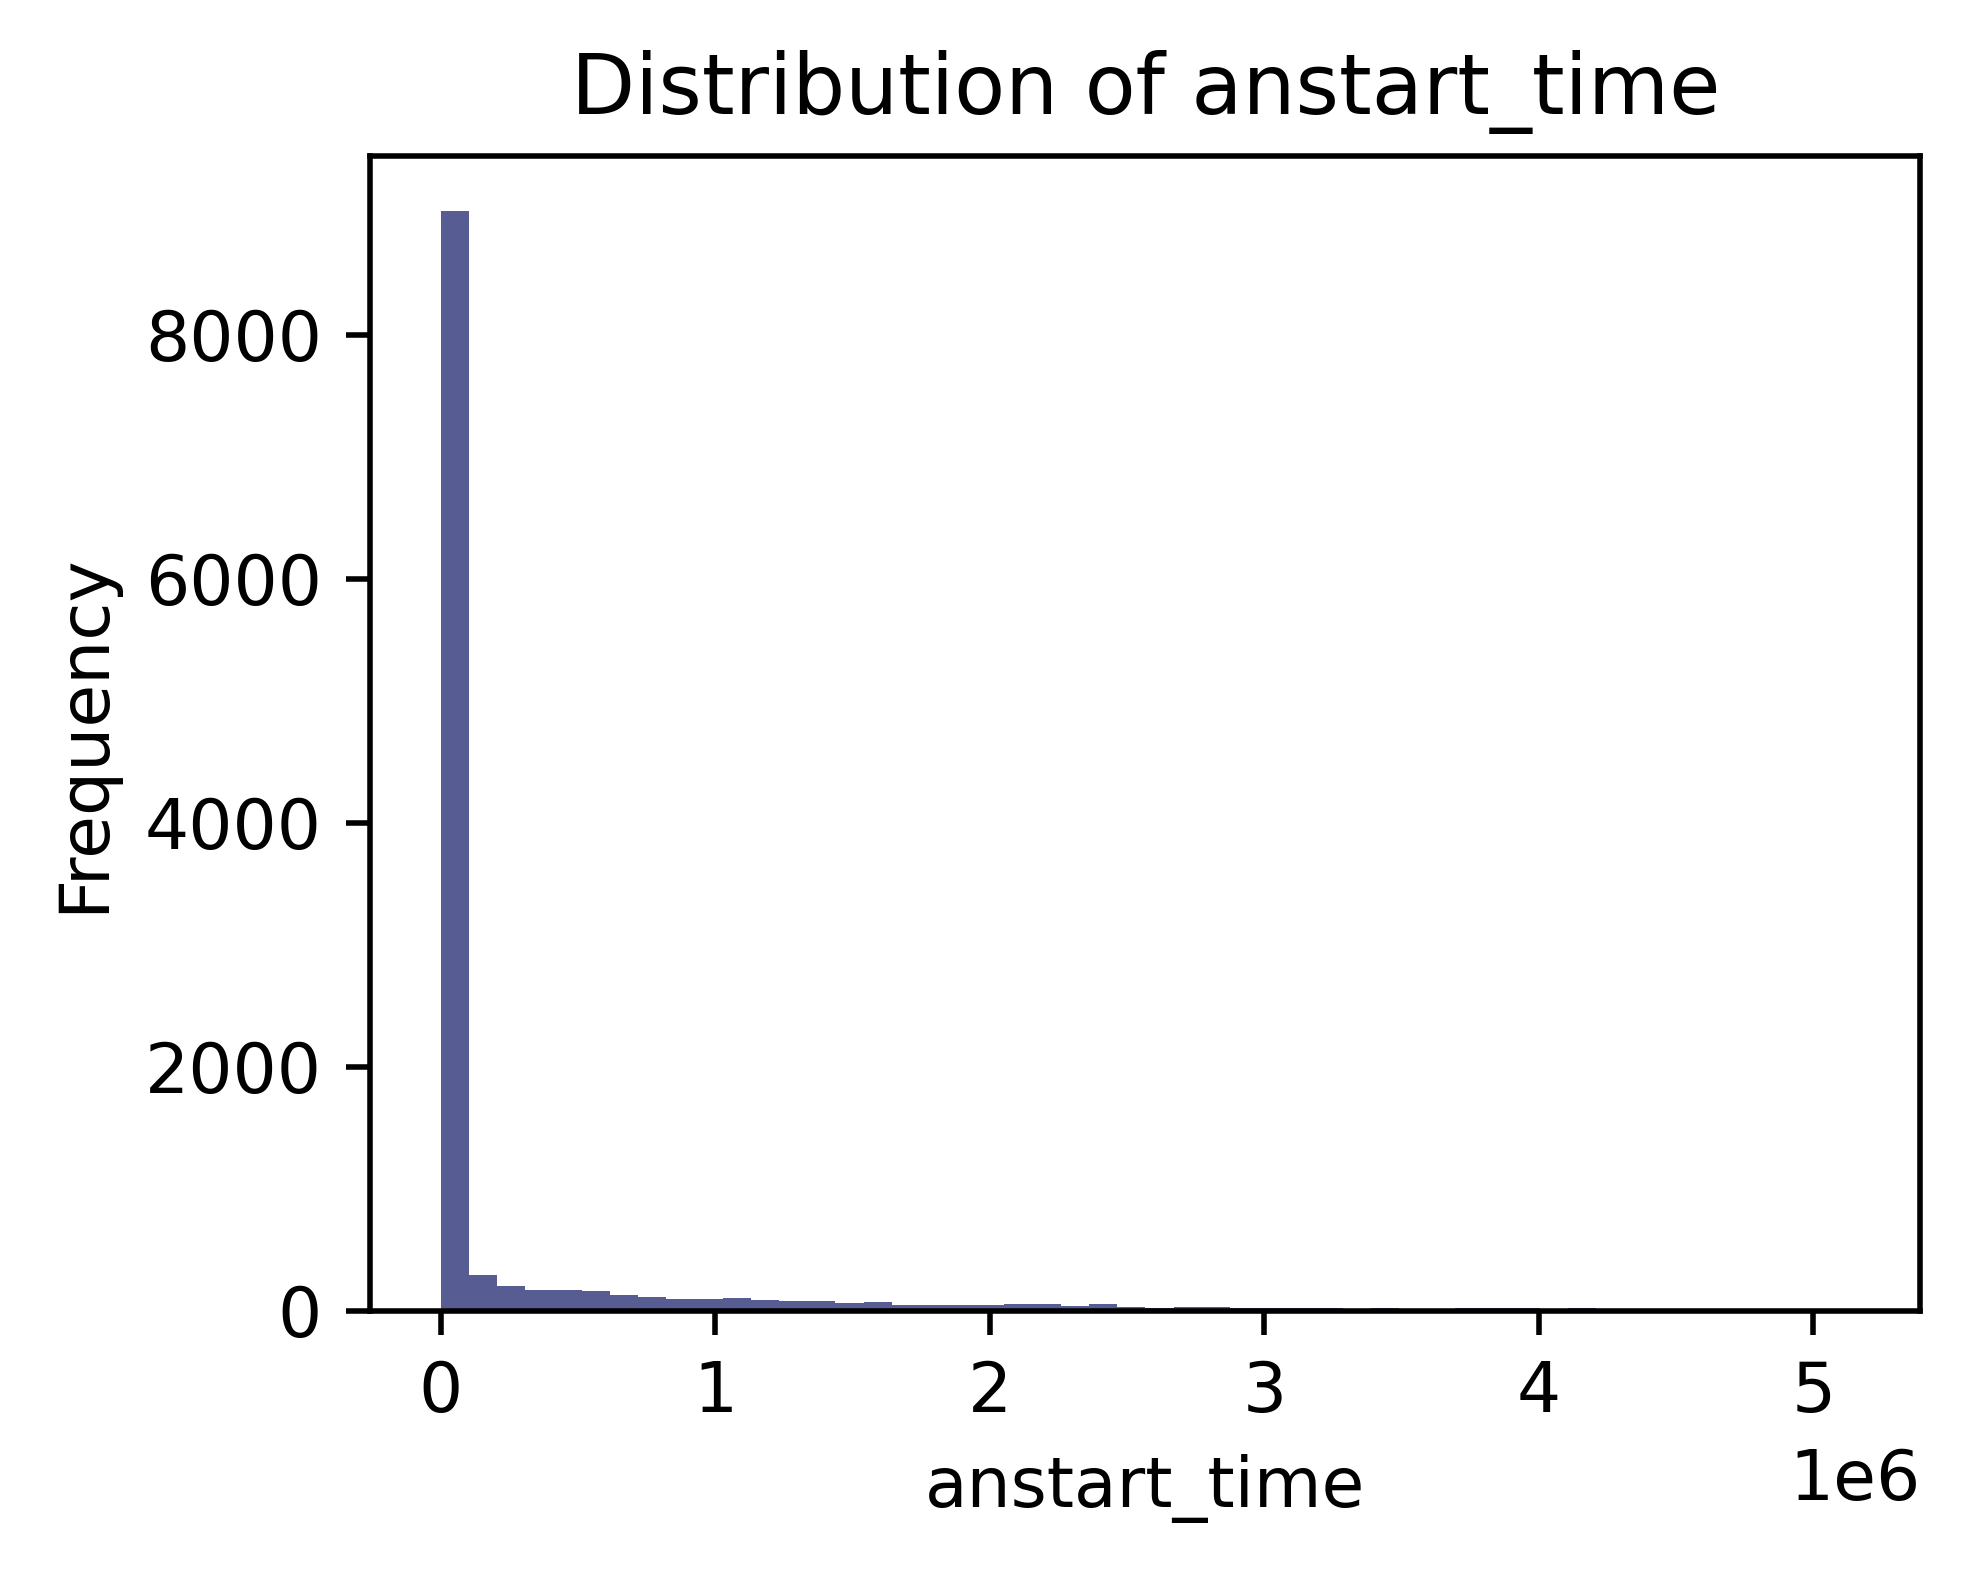

anend_time: min = 105.0, max = 5133570.0 


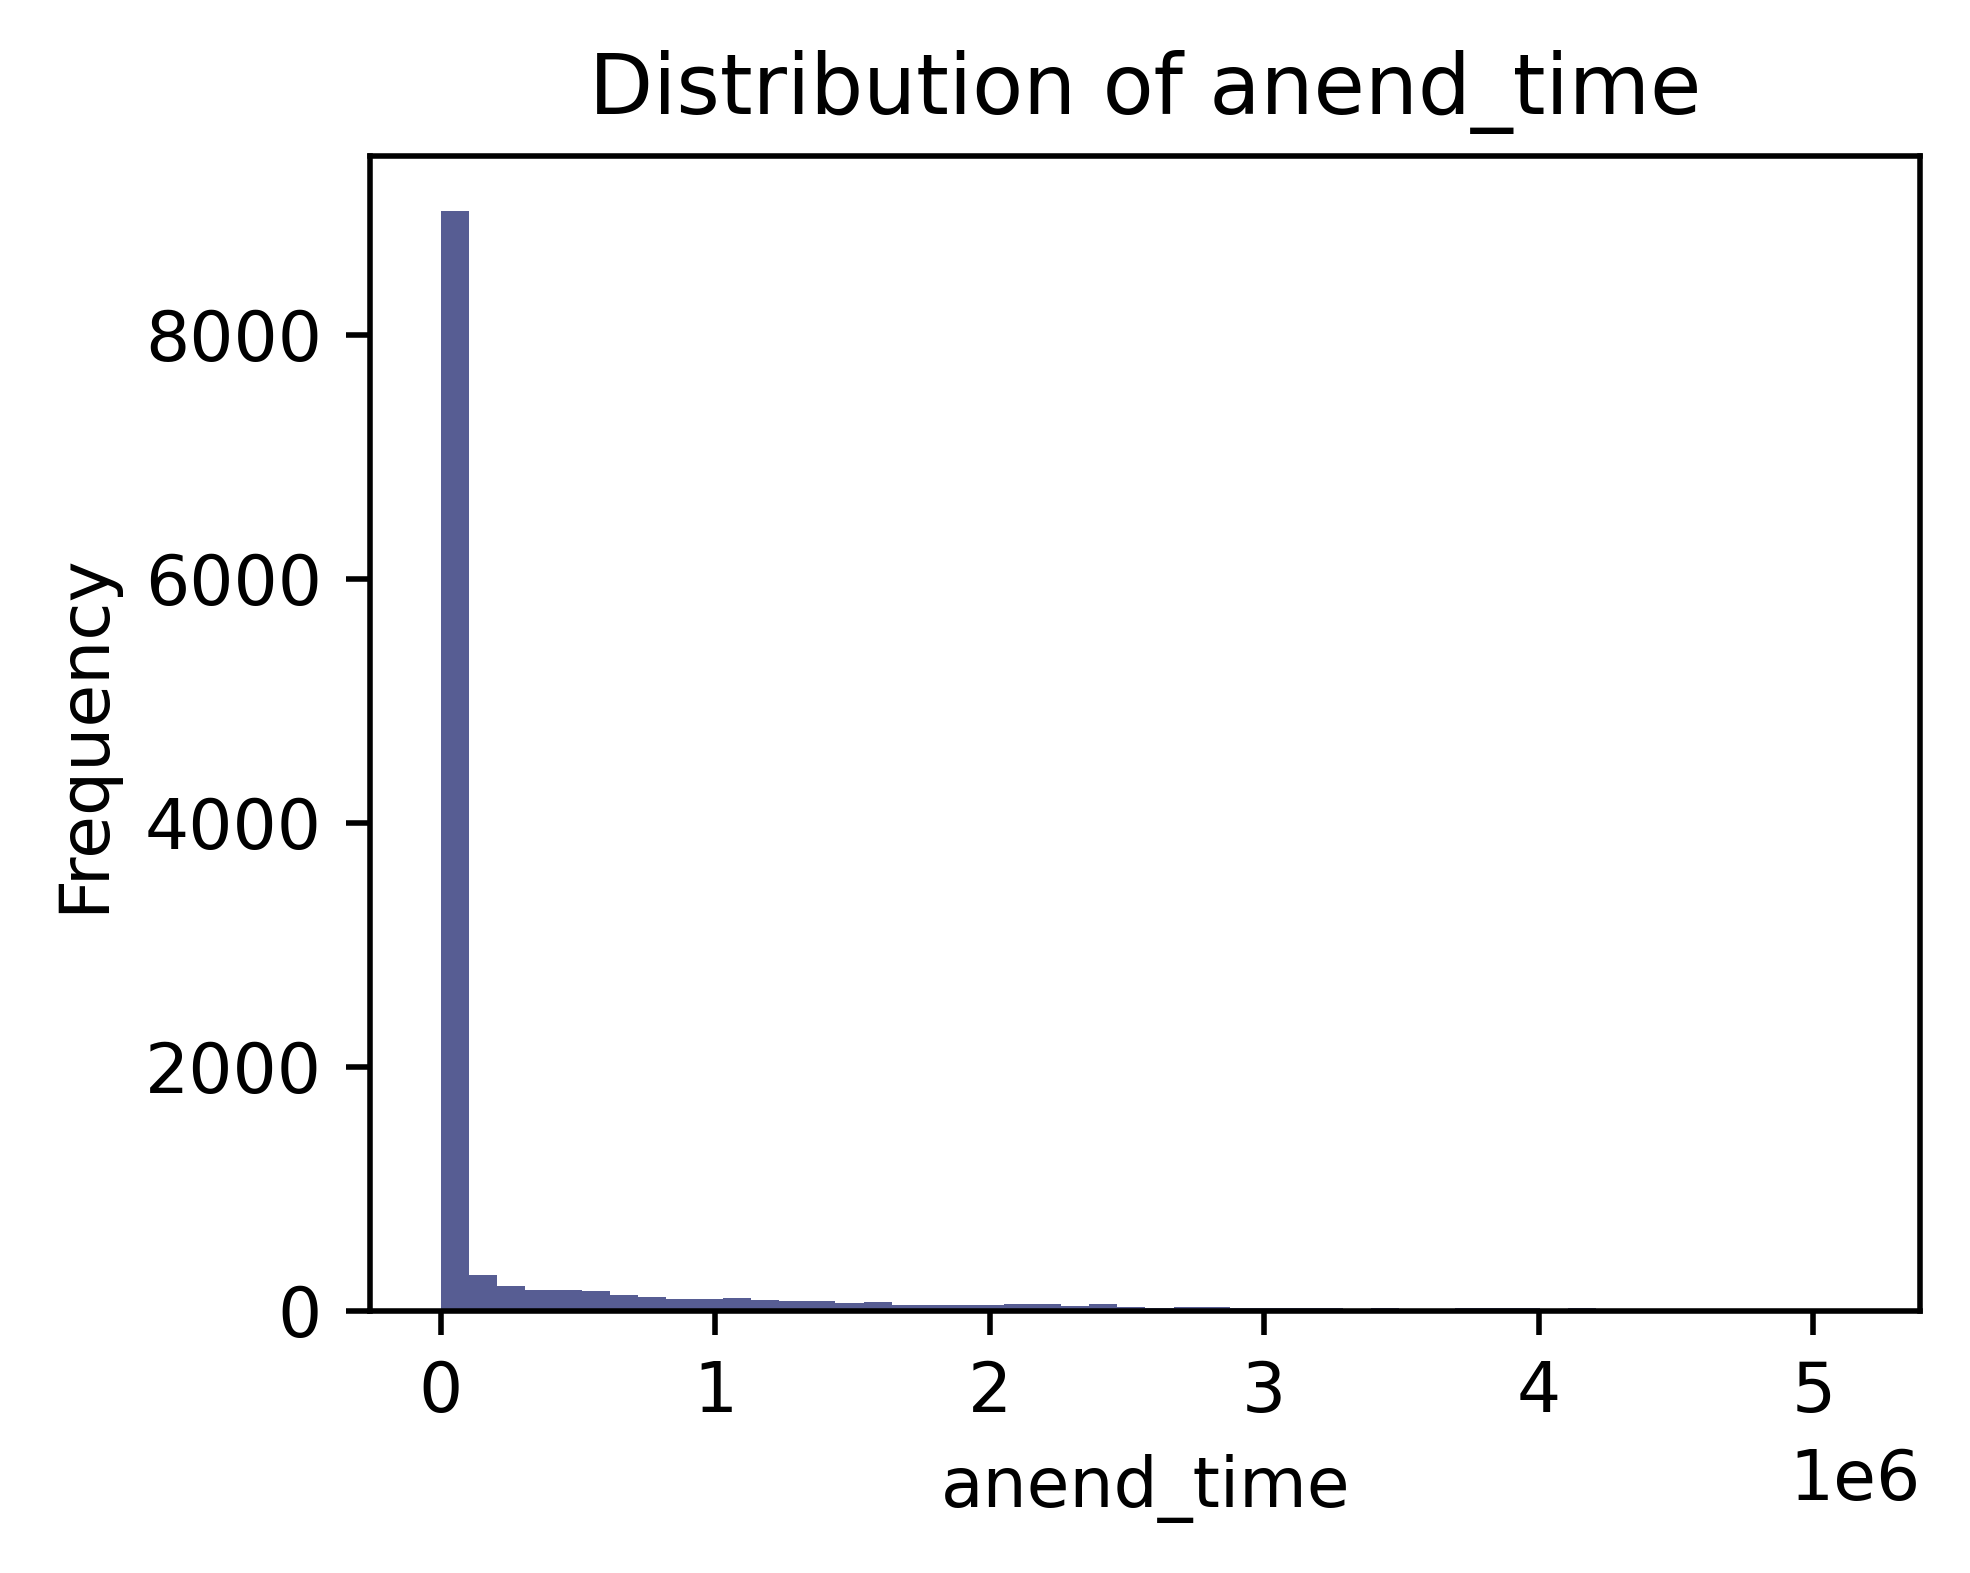

icd10_pcs: min = 00110, max = 10D00 


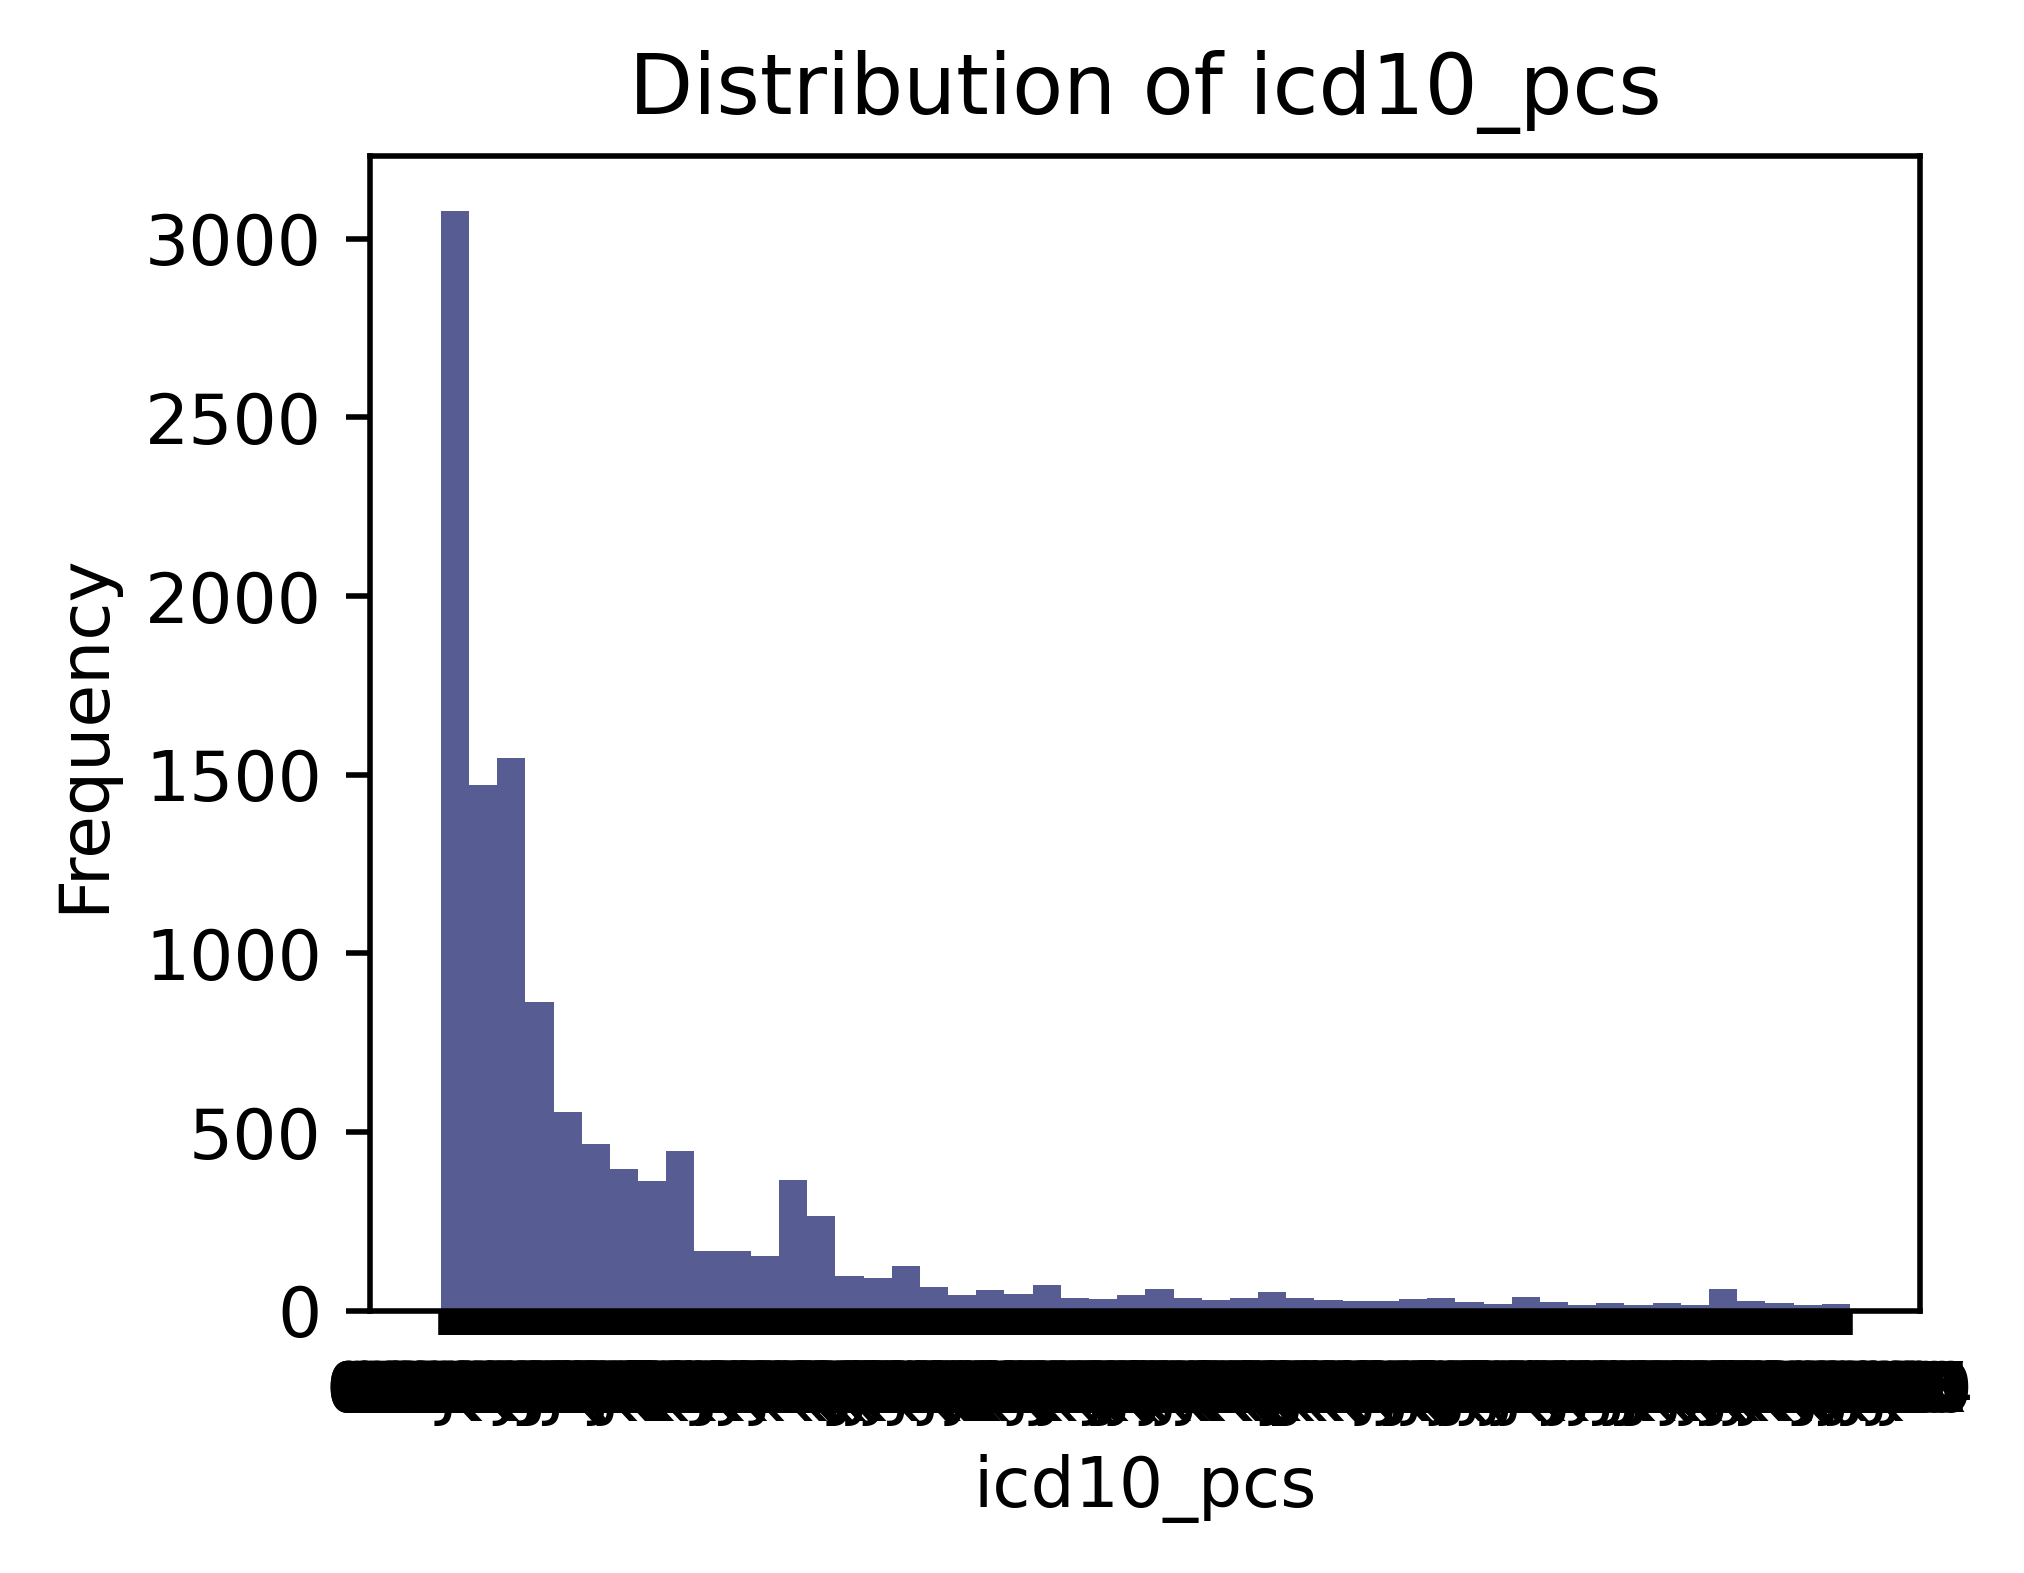

antype: min = General, max = Regional 


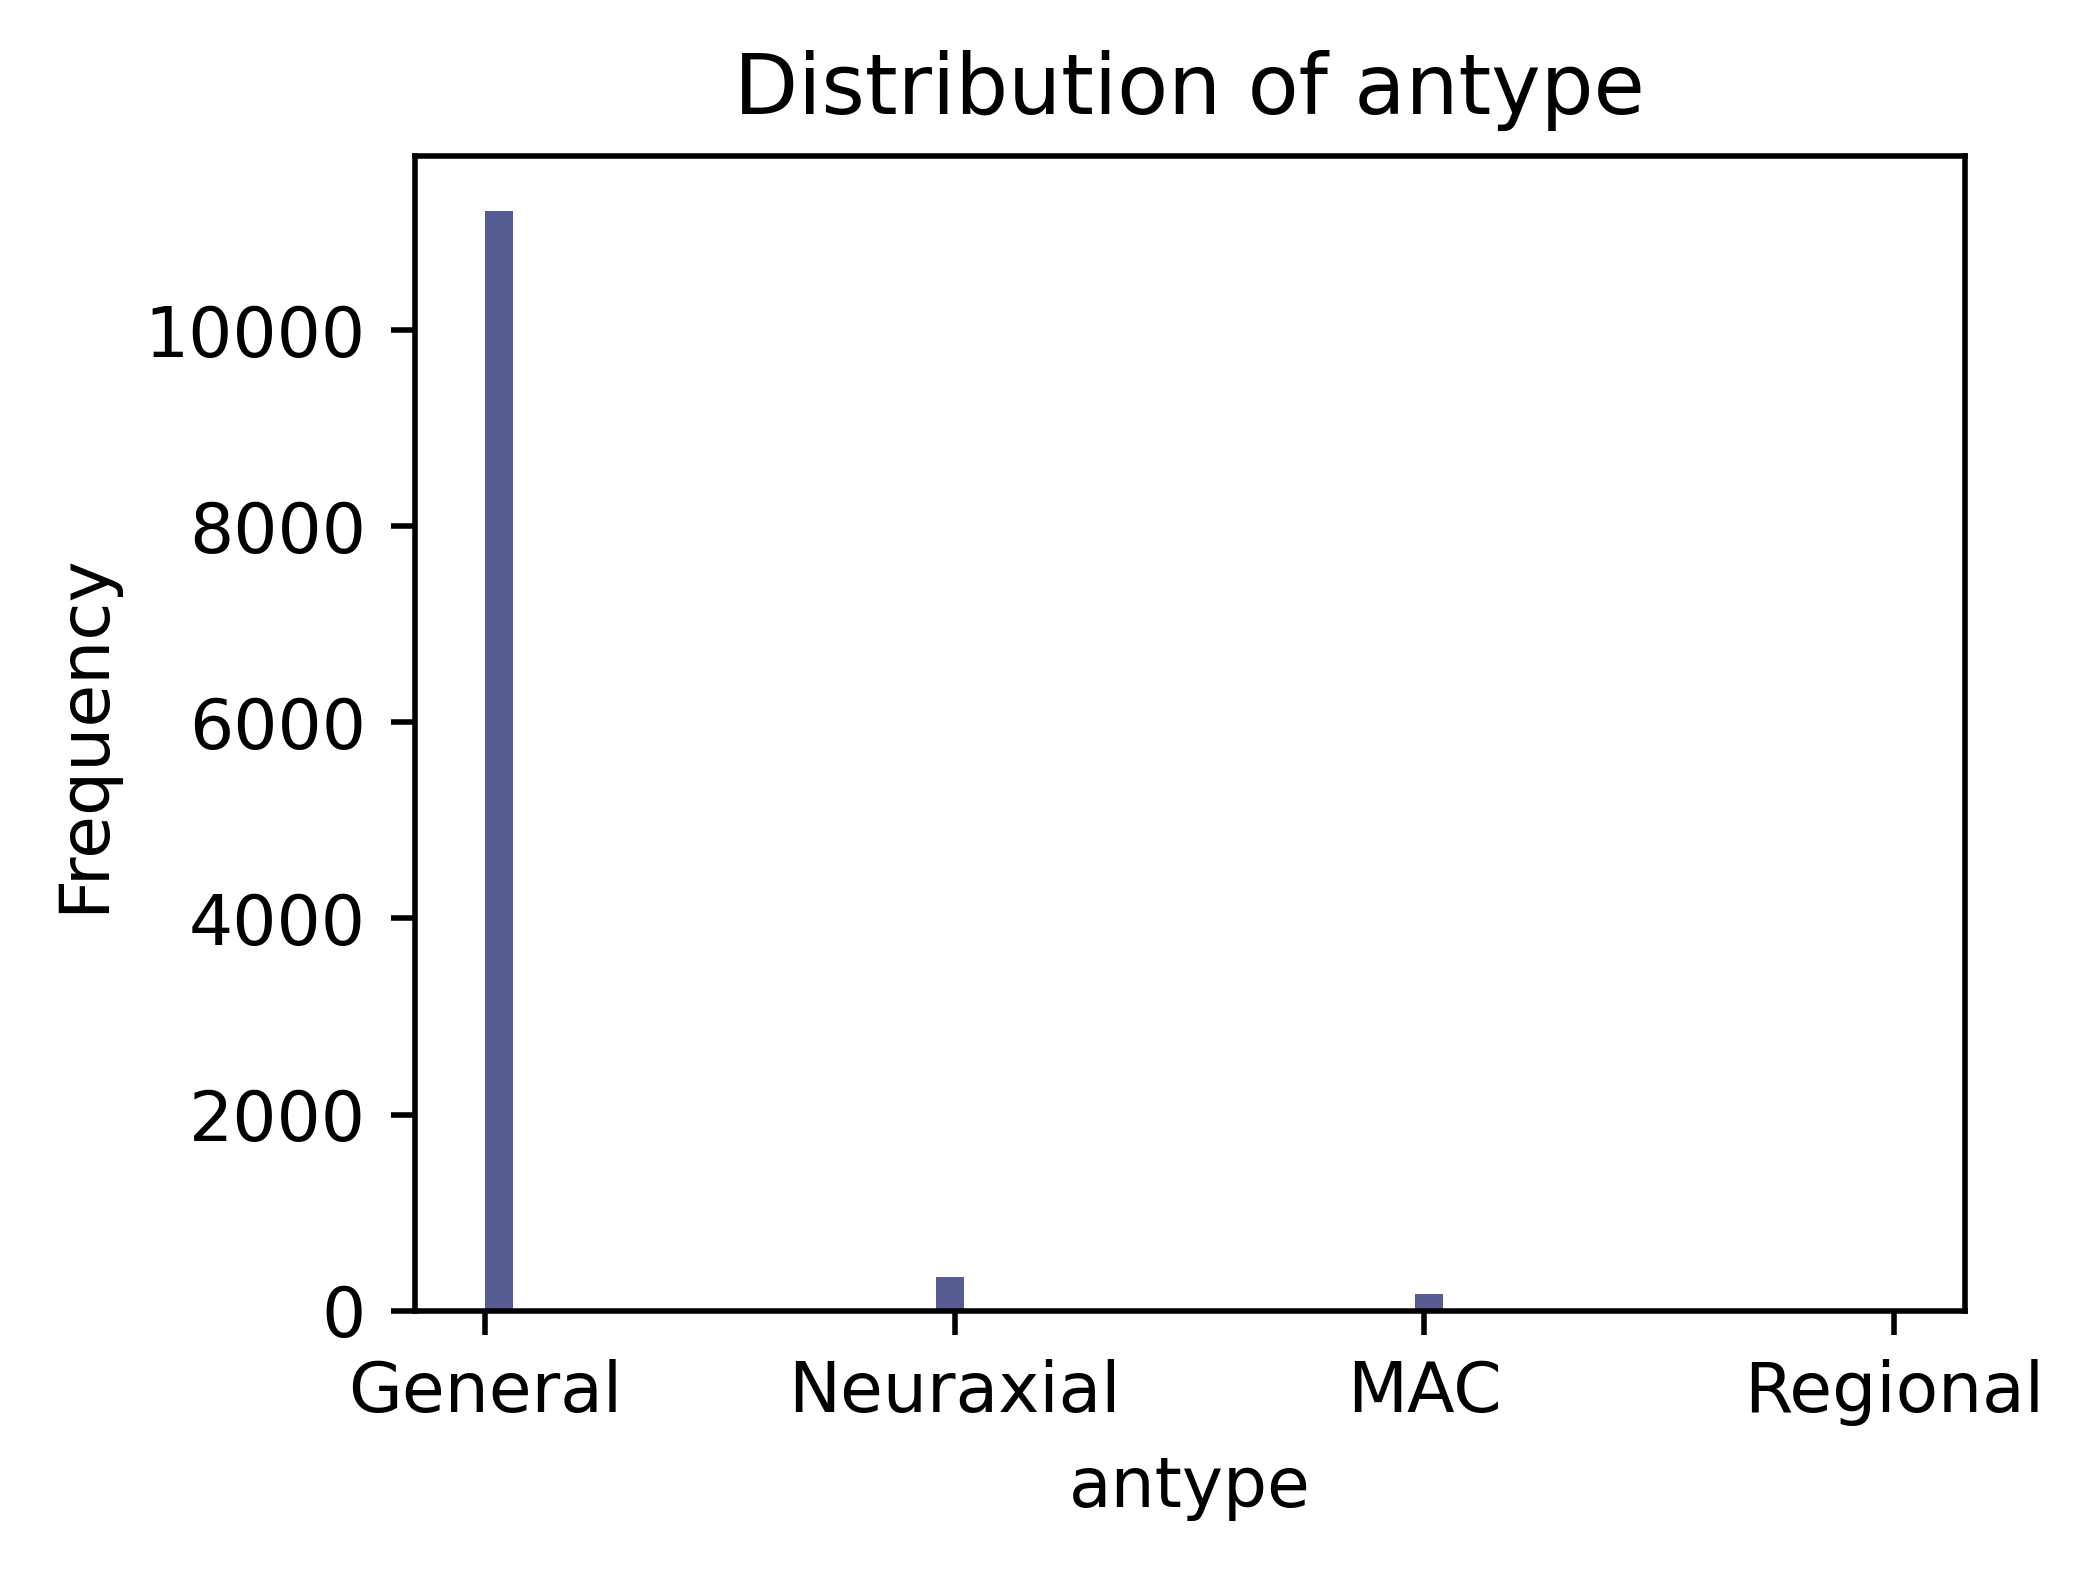

height_m: min = 0.5, max = 2.0 


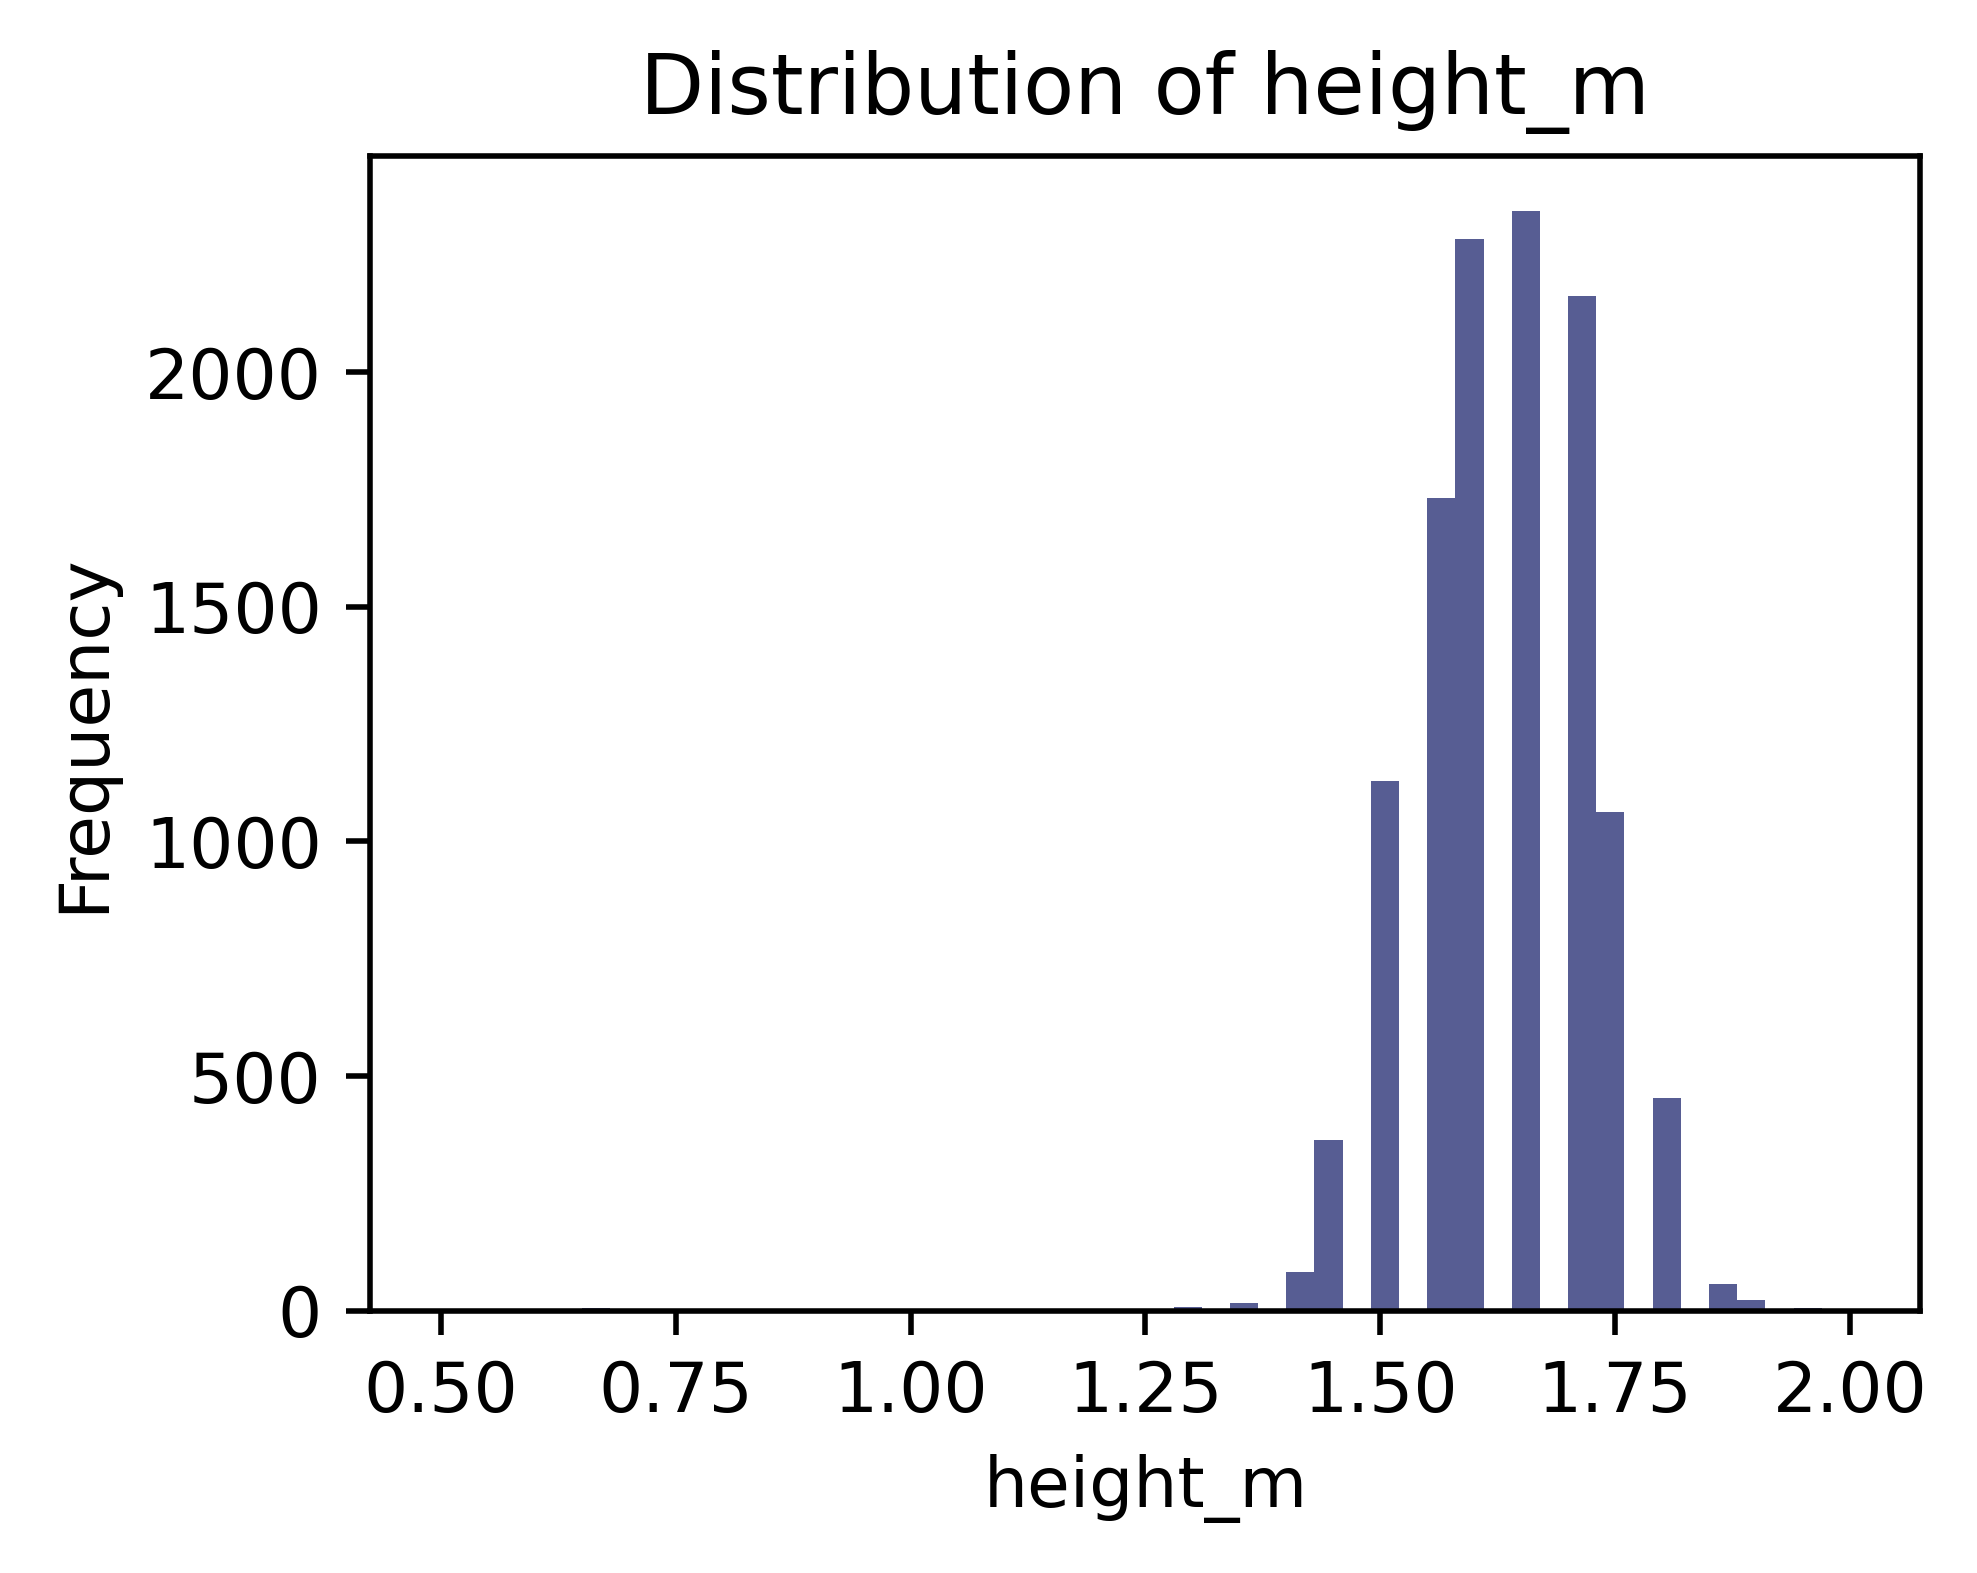

BMI: min = 10.802469135802468, max = 64.51612903225805 


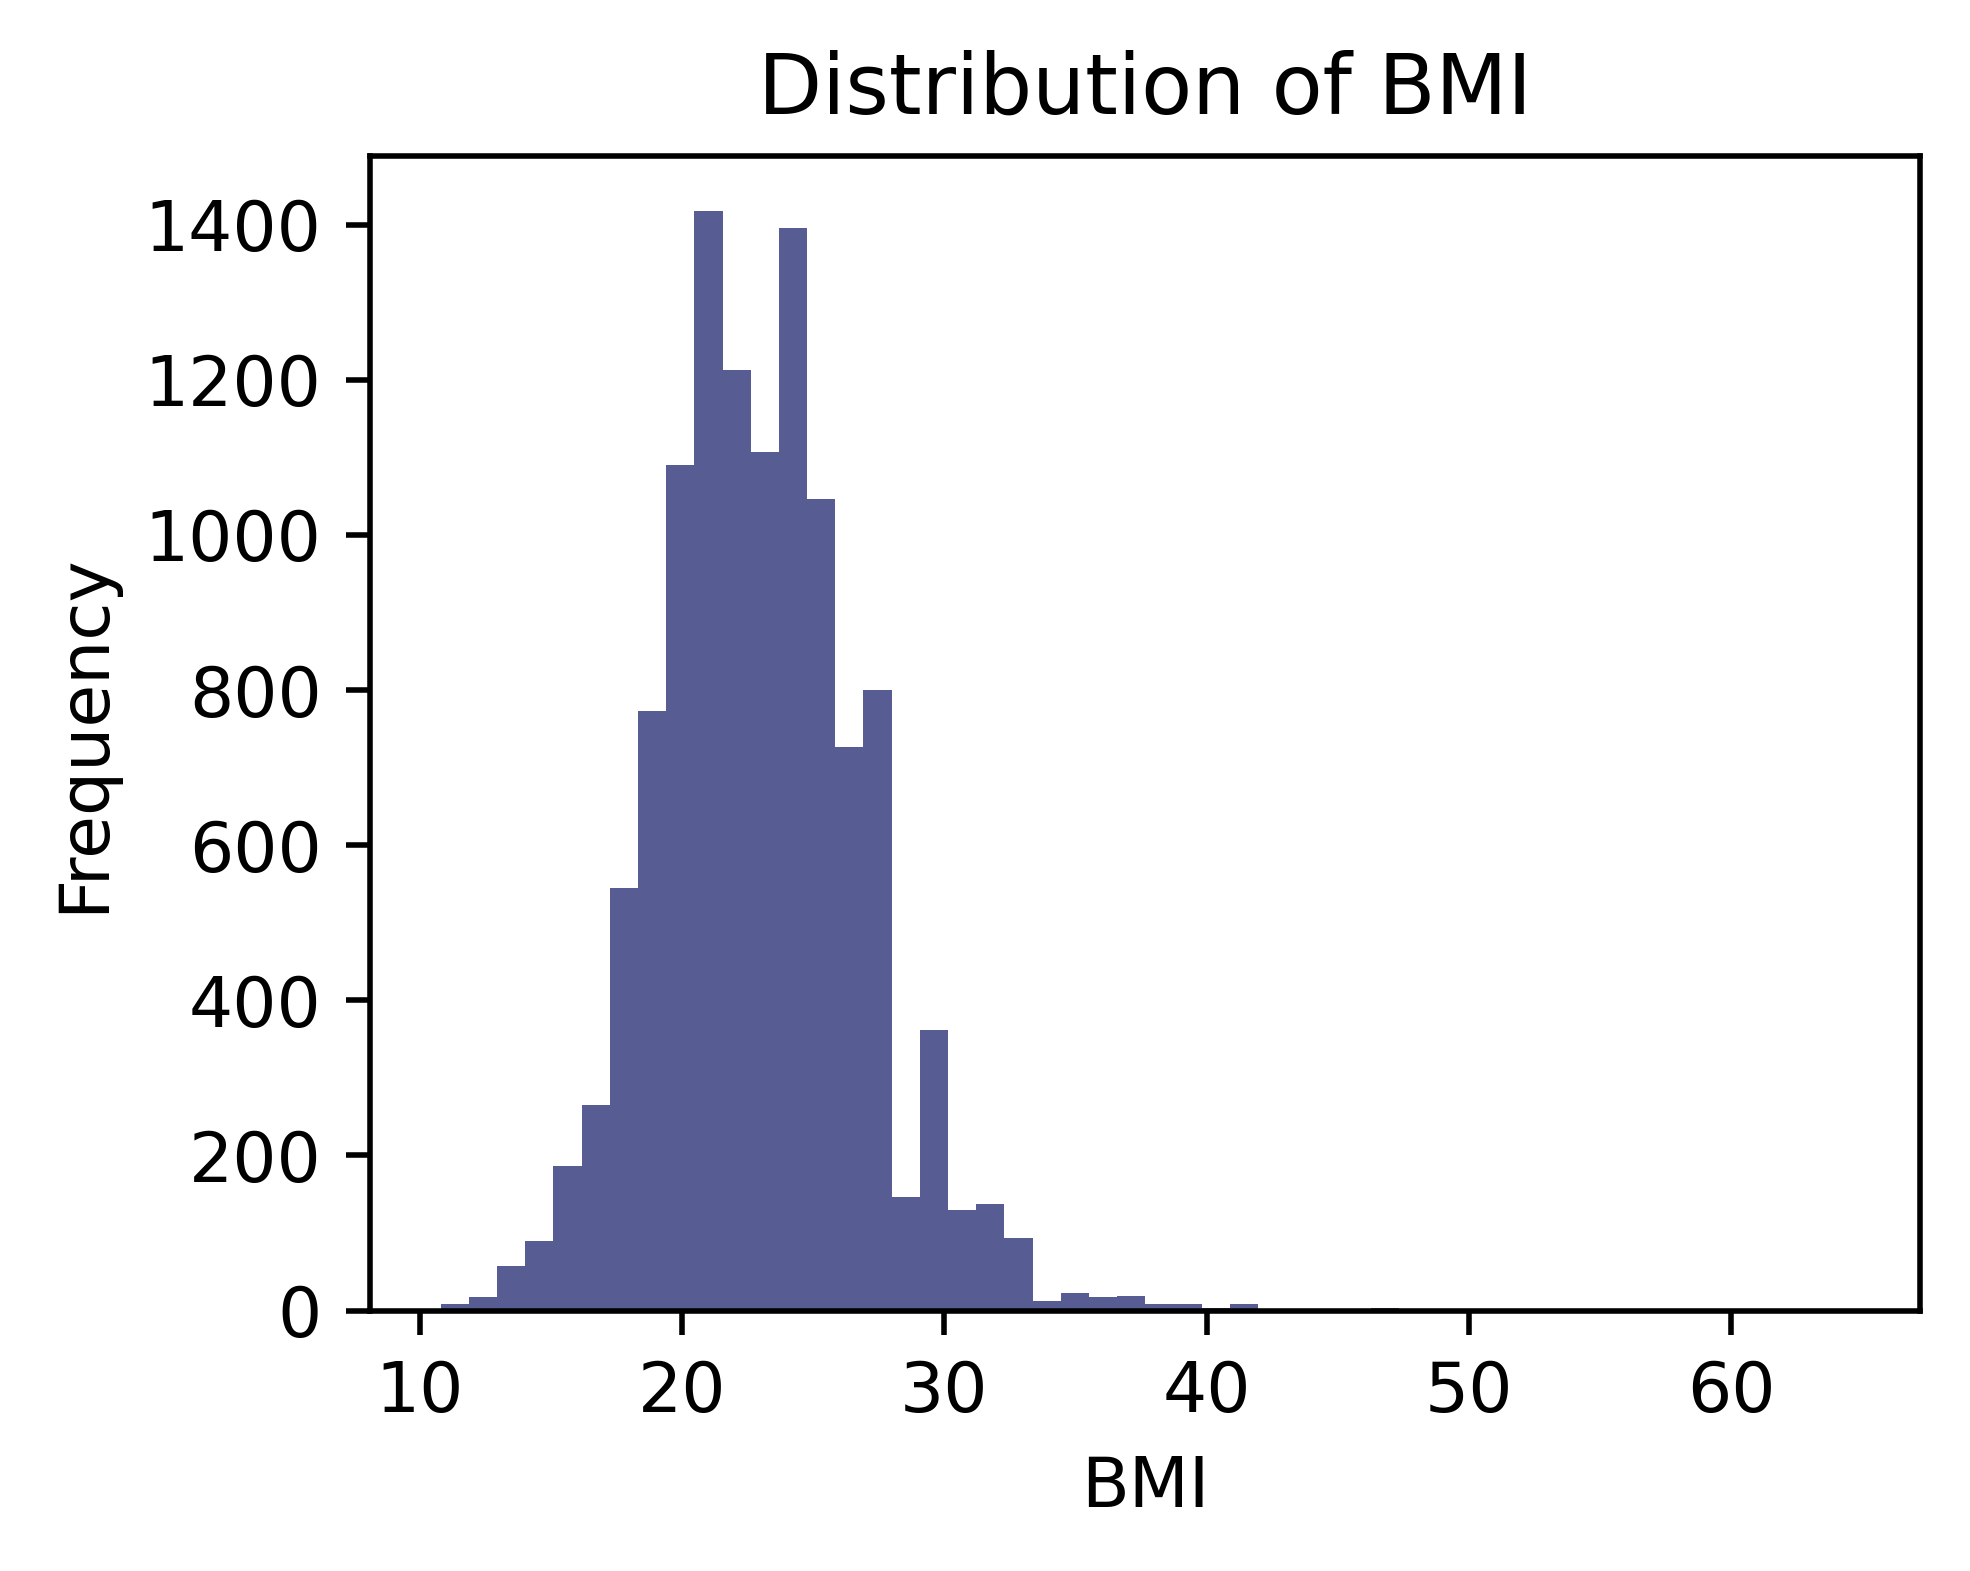

anesthesia_duration: min = 60.0, max = 1435.0 


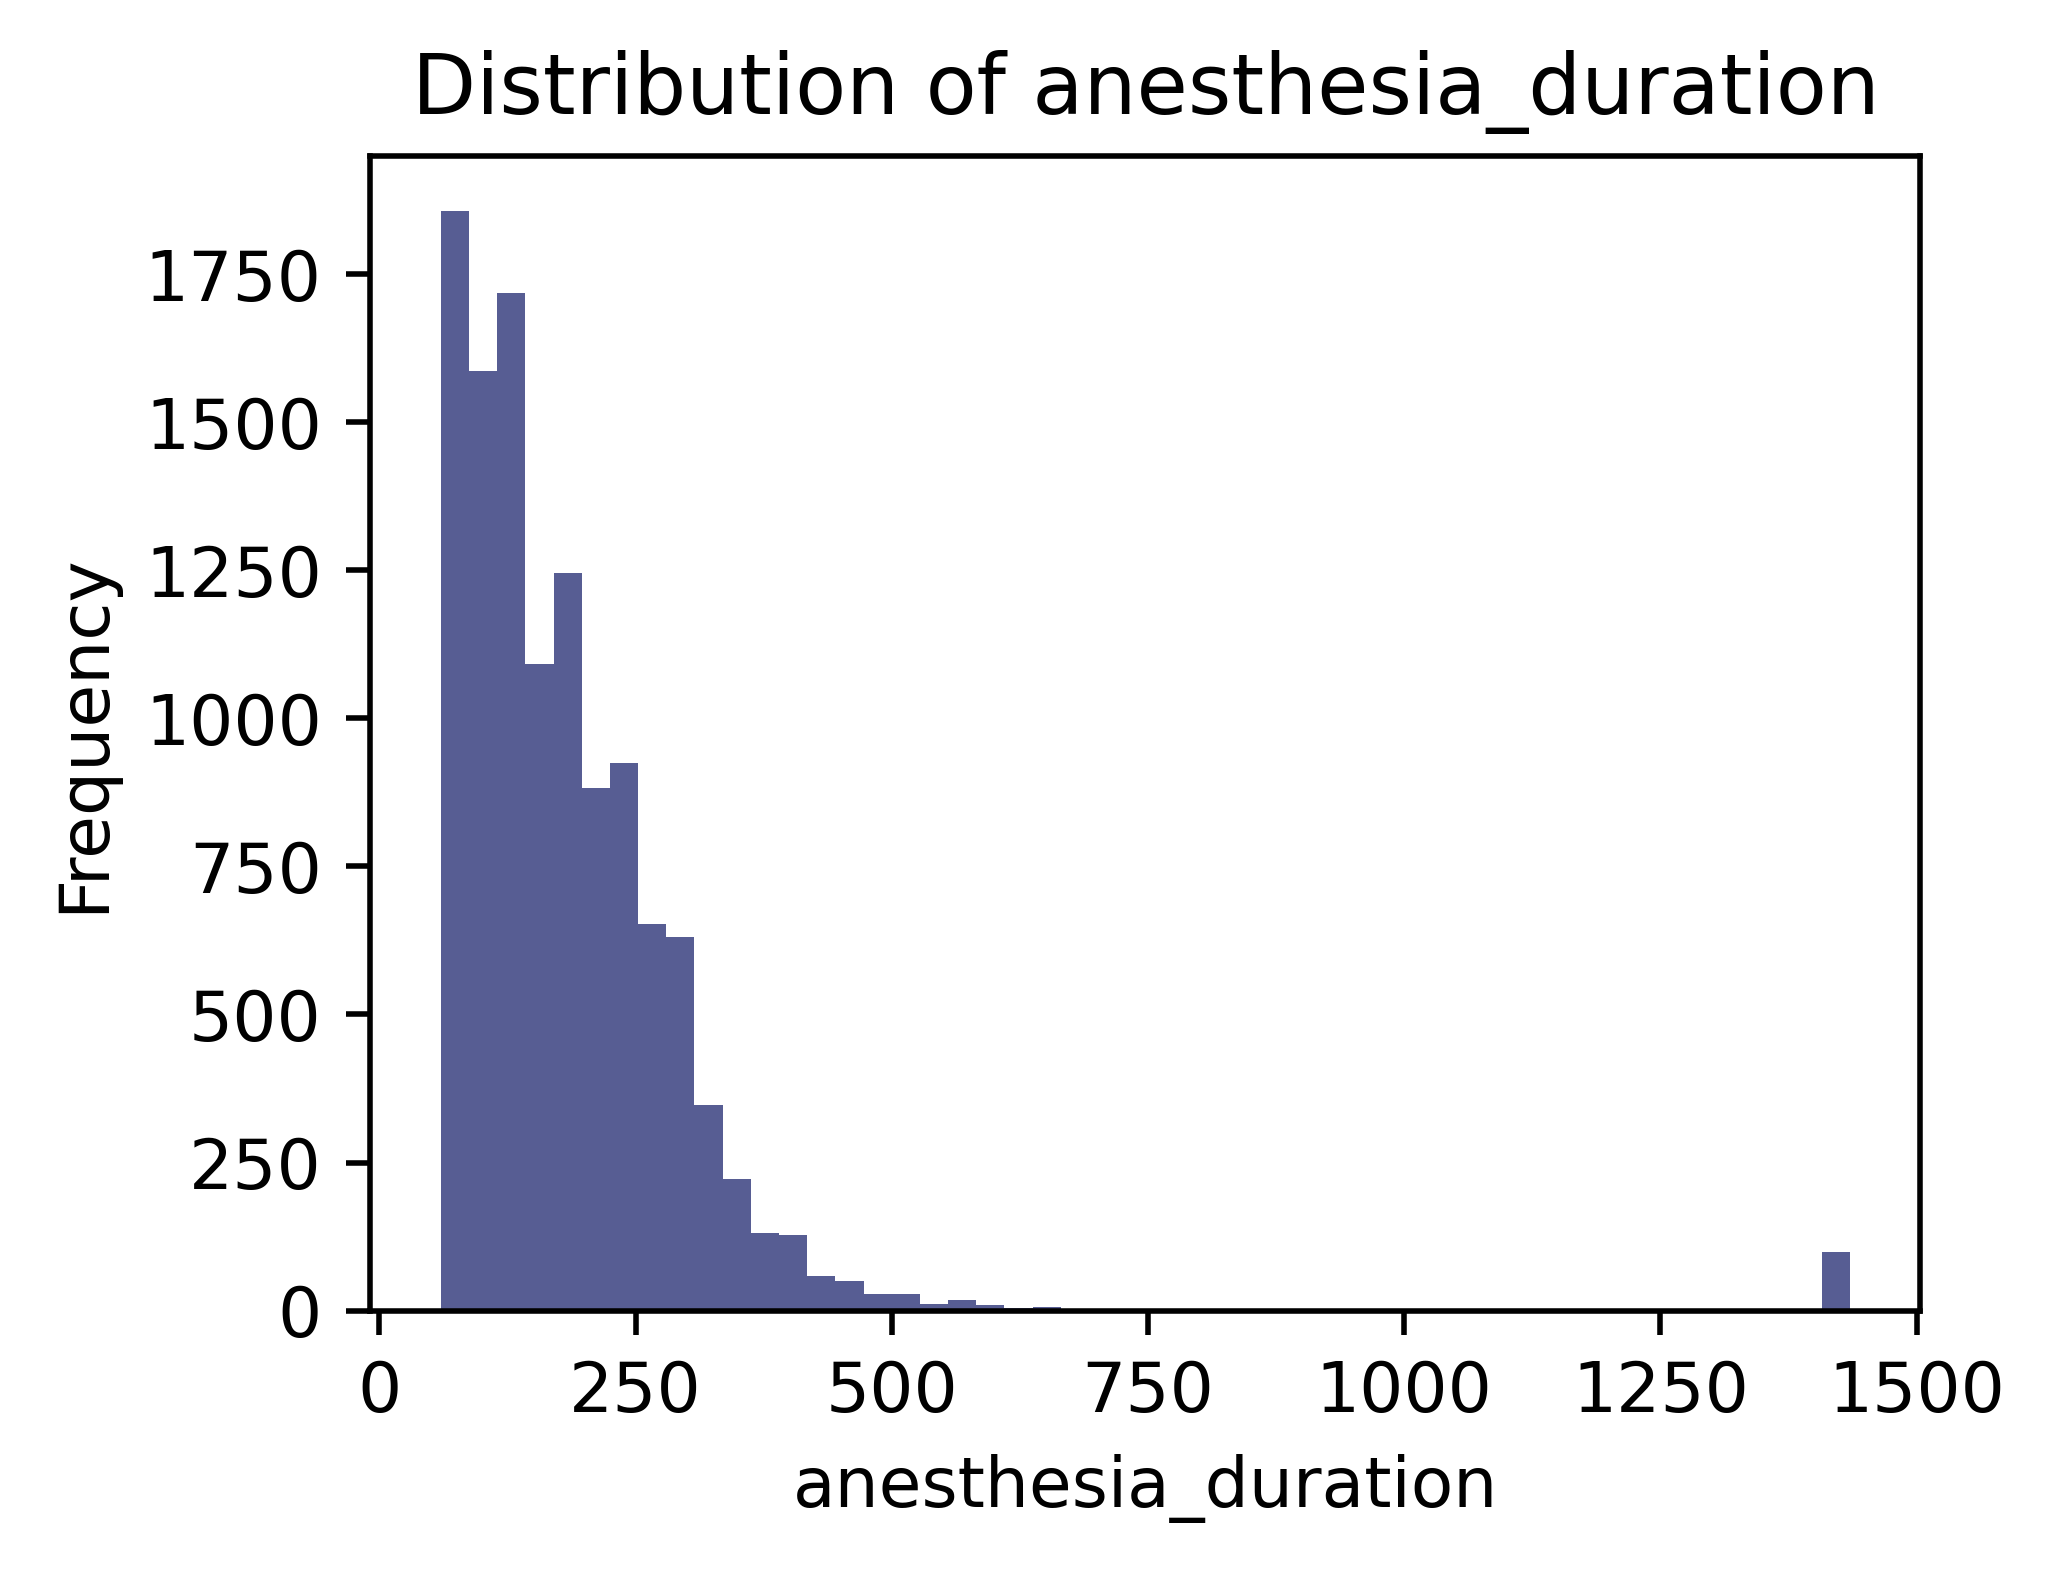

In [14]:
for feat in operations_sub.columns[2:]:
  print(f'{feat}: min = {np.min(operations_sub[feat])}, max = {np.max(operations_sub[feat])} ')
  plt.figure(figsize=(4,3), dpi=500)
  plt.hist(operations_sub[feat], bins=50, alpha=0.9, color=palette['INSPIRE'])
  plt.xlabel(feat)
  plt.ylabel('Frequency')
  plt.title(f'Distribution of {feat}')
  plt.savefig(f'{feat}_distribution.png', transparent=True, dpi=500)
  plt.show()

In [15]:
#lab_features = ['albumin','glucose','ptinr','creatinine','wbc','hco3']
filtered_labs = labs[labs['item_name'].isin(lab_features)]

In [16]:
# Step 1: Merge the dataframes
merged_df = pd.merge(
    filtered_labs,
    operations_sub[['subject_id', 'anstart_time']],
    on='subject_id',
    how='inner'
)

# Step 2: Calculate time difference
# Convert to integers if not already
merged_df['chart_time_sec'] = merged_df['chart_time'].astype(int)
merged_df['anstart_time_sec'] = merged_df['anstart_time'].astype(int)

# Calculate seconds difference
# Simplified version of the time difference calculation -
# if you know times are in same format and don't need wraparound handling
merged_df['seconds_diff'] = merged_df['anstart_time_sec'] - merged_df['chart_time_sec']
merged_df['hours_diff'] = merged_df['seconds_diff'] / 3600

# Step 3: Keep only labs before surgery
pre_surgery_labs = merged_df[merged_df['hours_diff'] > 0]

# Step 4: Add a column to identify optimal labs for selection
pre_surgery_labs['meets_24h'] = pre_surgery_labs['hours_diff'] >= 24
pre_surgery_labs['distance_from_24h'] = abs(pre_surgery_labs['hours_diff'] - 24)

# Step 5: Sort by selection criteria for faster processing
# First by subject_id and item_name to group them
# Then by meets_24h (True first) to prioritize labs ≥ 24 hours
# Then by hours_diff ascending (for labs ≥ 24h) or distance_from_24h ascending (for labs < 24h)
pre_surgery_labs = pre_surgery_labs.sort_values(
    ['subject_id', 'item_name', 'meets_24h', 'distance_from_24h'],
    ascending=[True, True, False, True]
)

# Step 6: Keep the first lab for each subject_id and item_name after sorting
# This will be the optimal lab based on our criteria
selected_labs = pre_surgery_labs.drop_duplicates(['subject_id', 'item_name'])

# Step 7: Pivot the data to get item_names as columns
pivoted_labs = selected_labs.pivot(
    index='subject_id',
    columns='item_name',
    values='value'
)

# Step 8: Merge with operations_sub
operations_sub_with_labs = operations_sub.merge(
    pivoted_labs,
    on='subject_id',
    how='left'
)

# Print some diagnostic information
print(f"Final DataFrame shape: {operations_sub_with_labs.shape}")
print(f"Original operations_sub shape: {operations_sub.shape}")
print(f"Number of lab columns added: {pivoted_labs.shape[1]}")

/var/folders/nl/_hsnd4n10hz02hsrvnrw30080000gn/T/ipykernel_66726/2984647863.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_surgery_labs['meets_24h'] = pre_surgery_labs['hours_diff'] >= 24
/var/folders/nl/_hsnd4n10hz02hsrvnrw30080000gn/T/ipykernel_66726/2984647863.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_surgery_labs['distance_from_24h'] = abs(pre_surgery_labs['hours_diff'] - 24)


Final DataFrame shape: (11745, 18)
Original operations_sub shape: (11745, 12)
Number of lab columns added: 6


age: min = 20, max = 90 


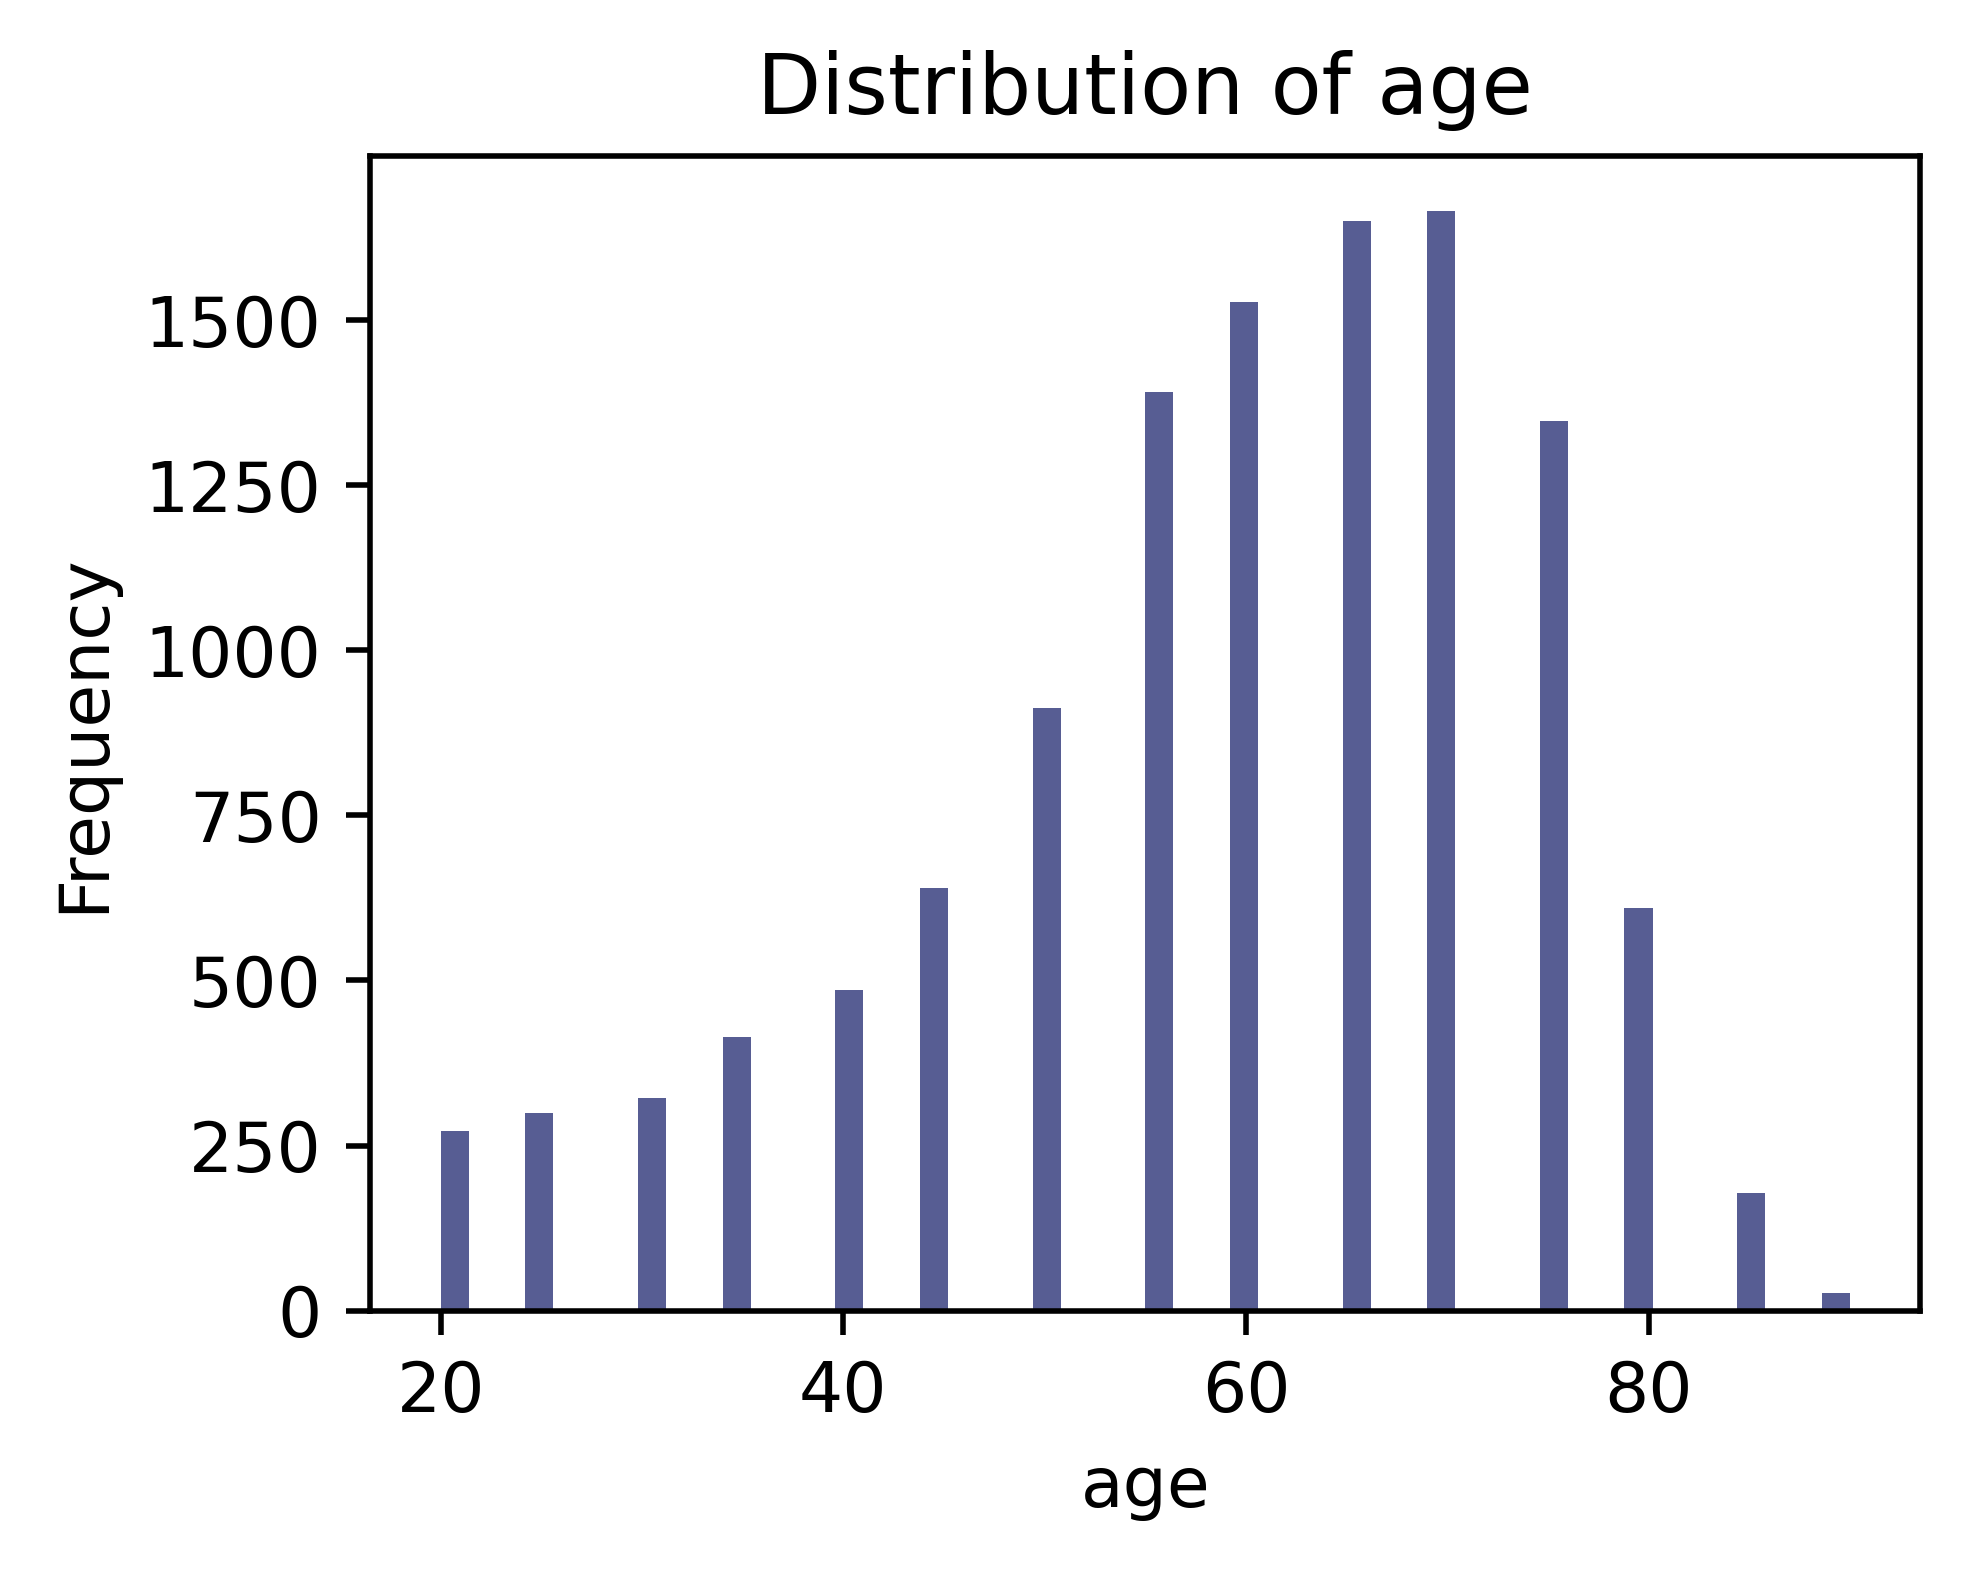

height: min = 50.0, max = 200.0 


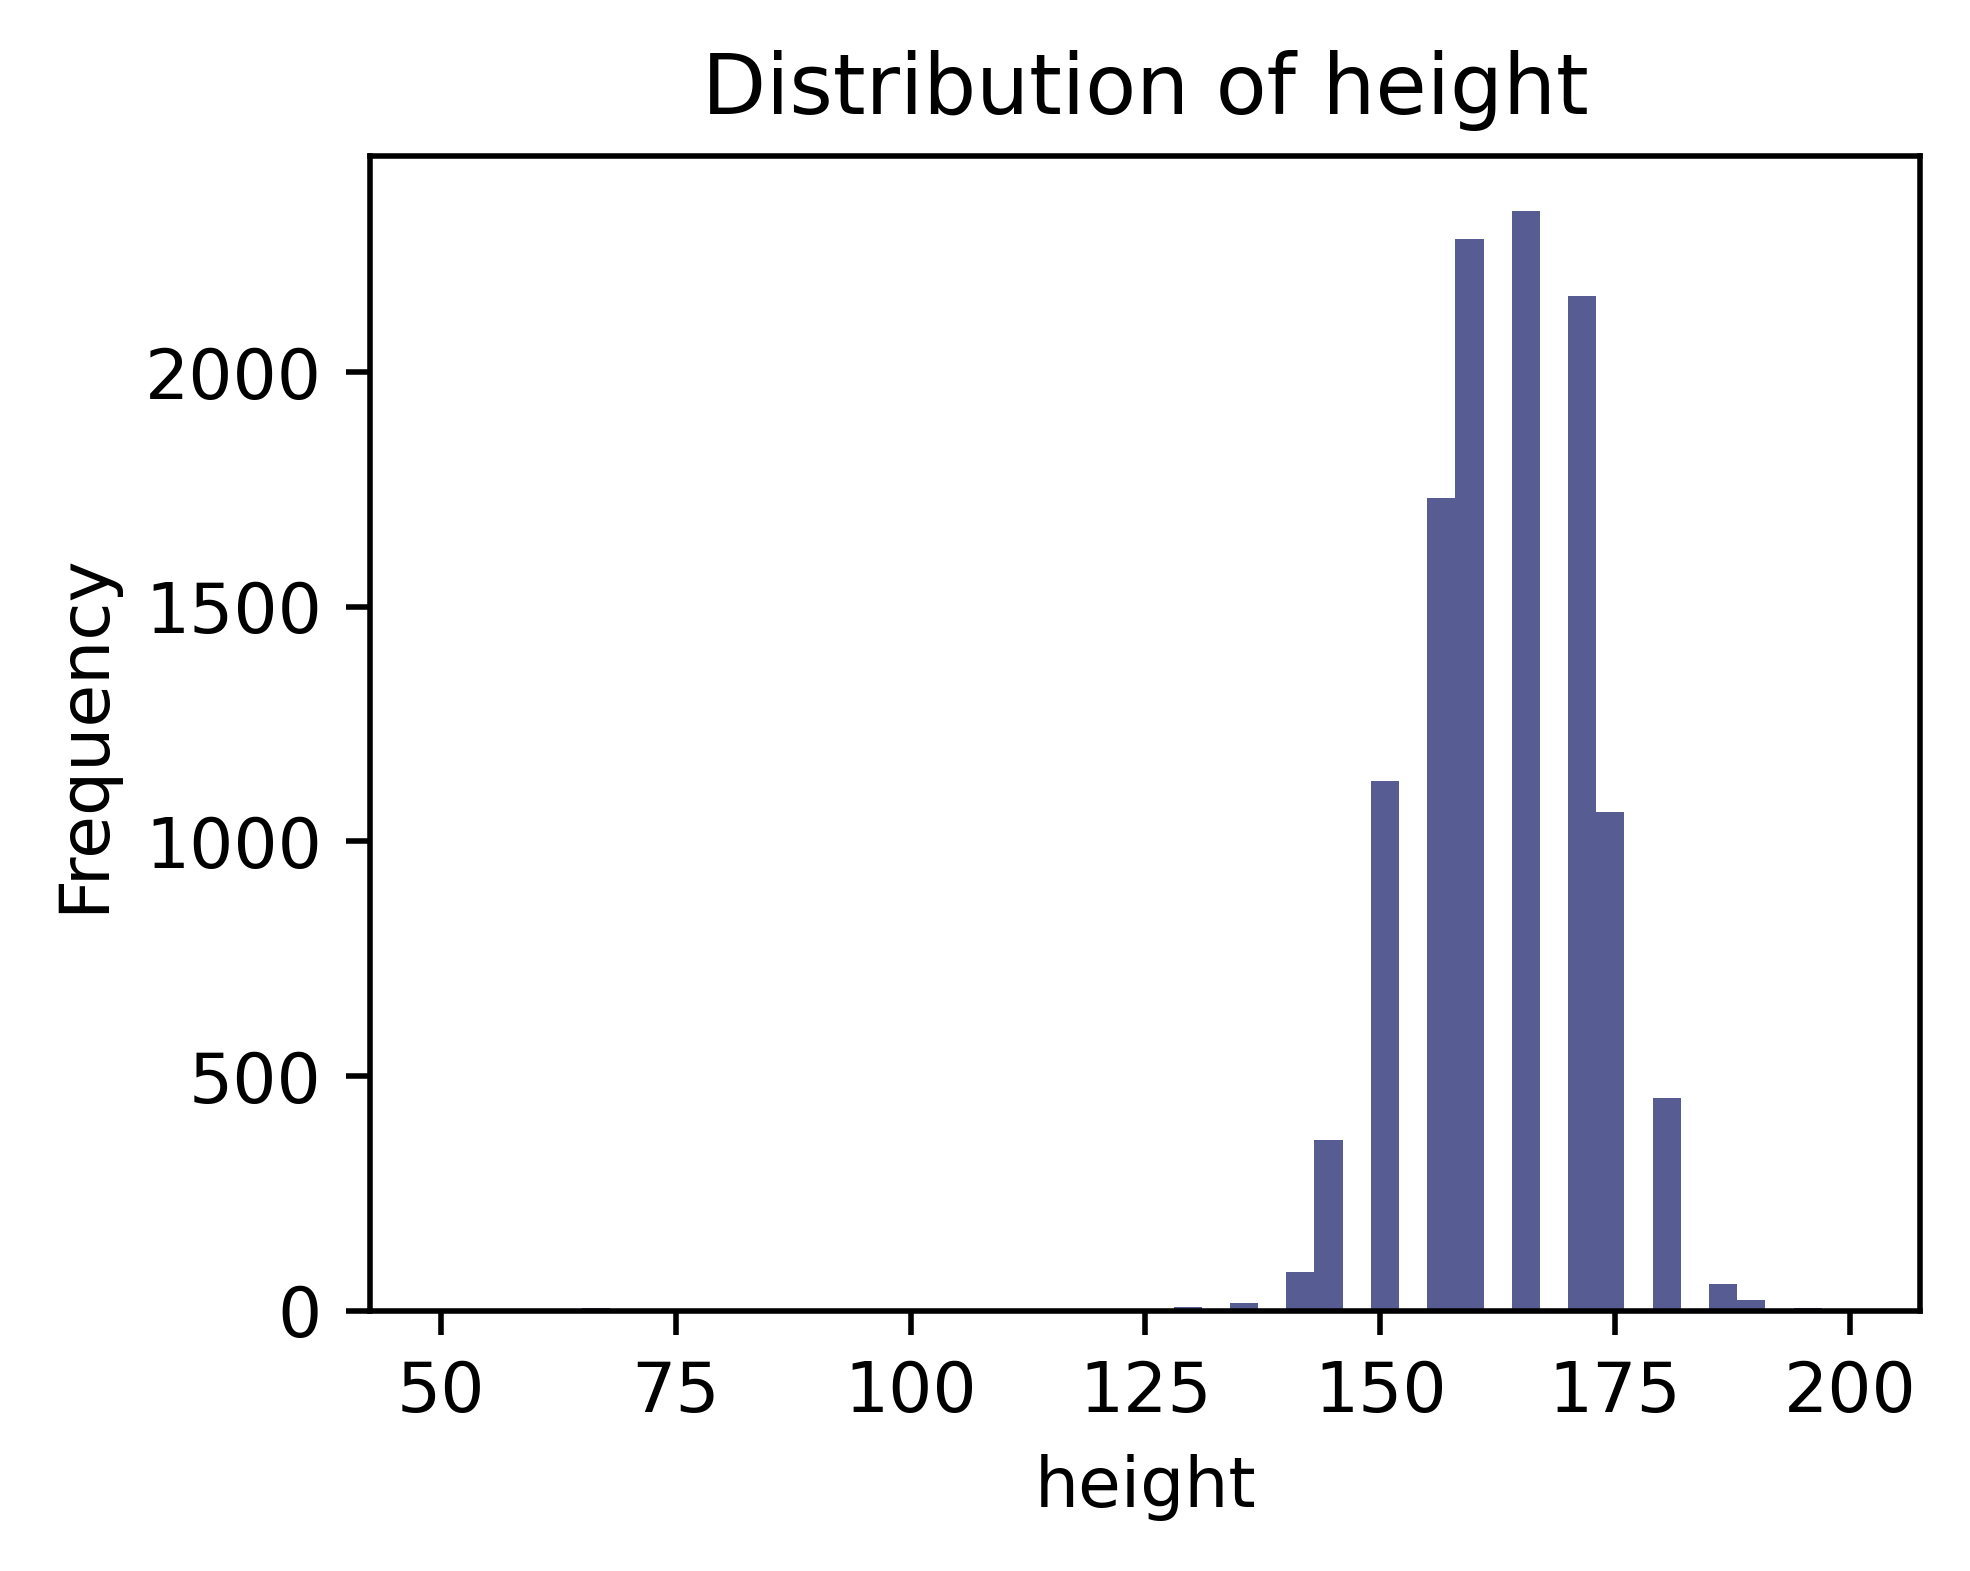

weight: min = 20.0, max = 175.0 


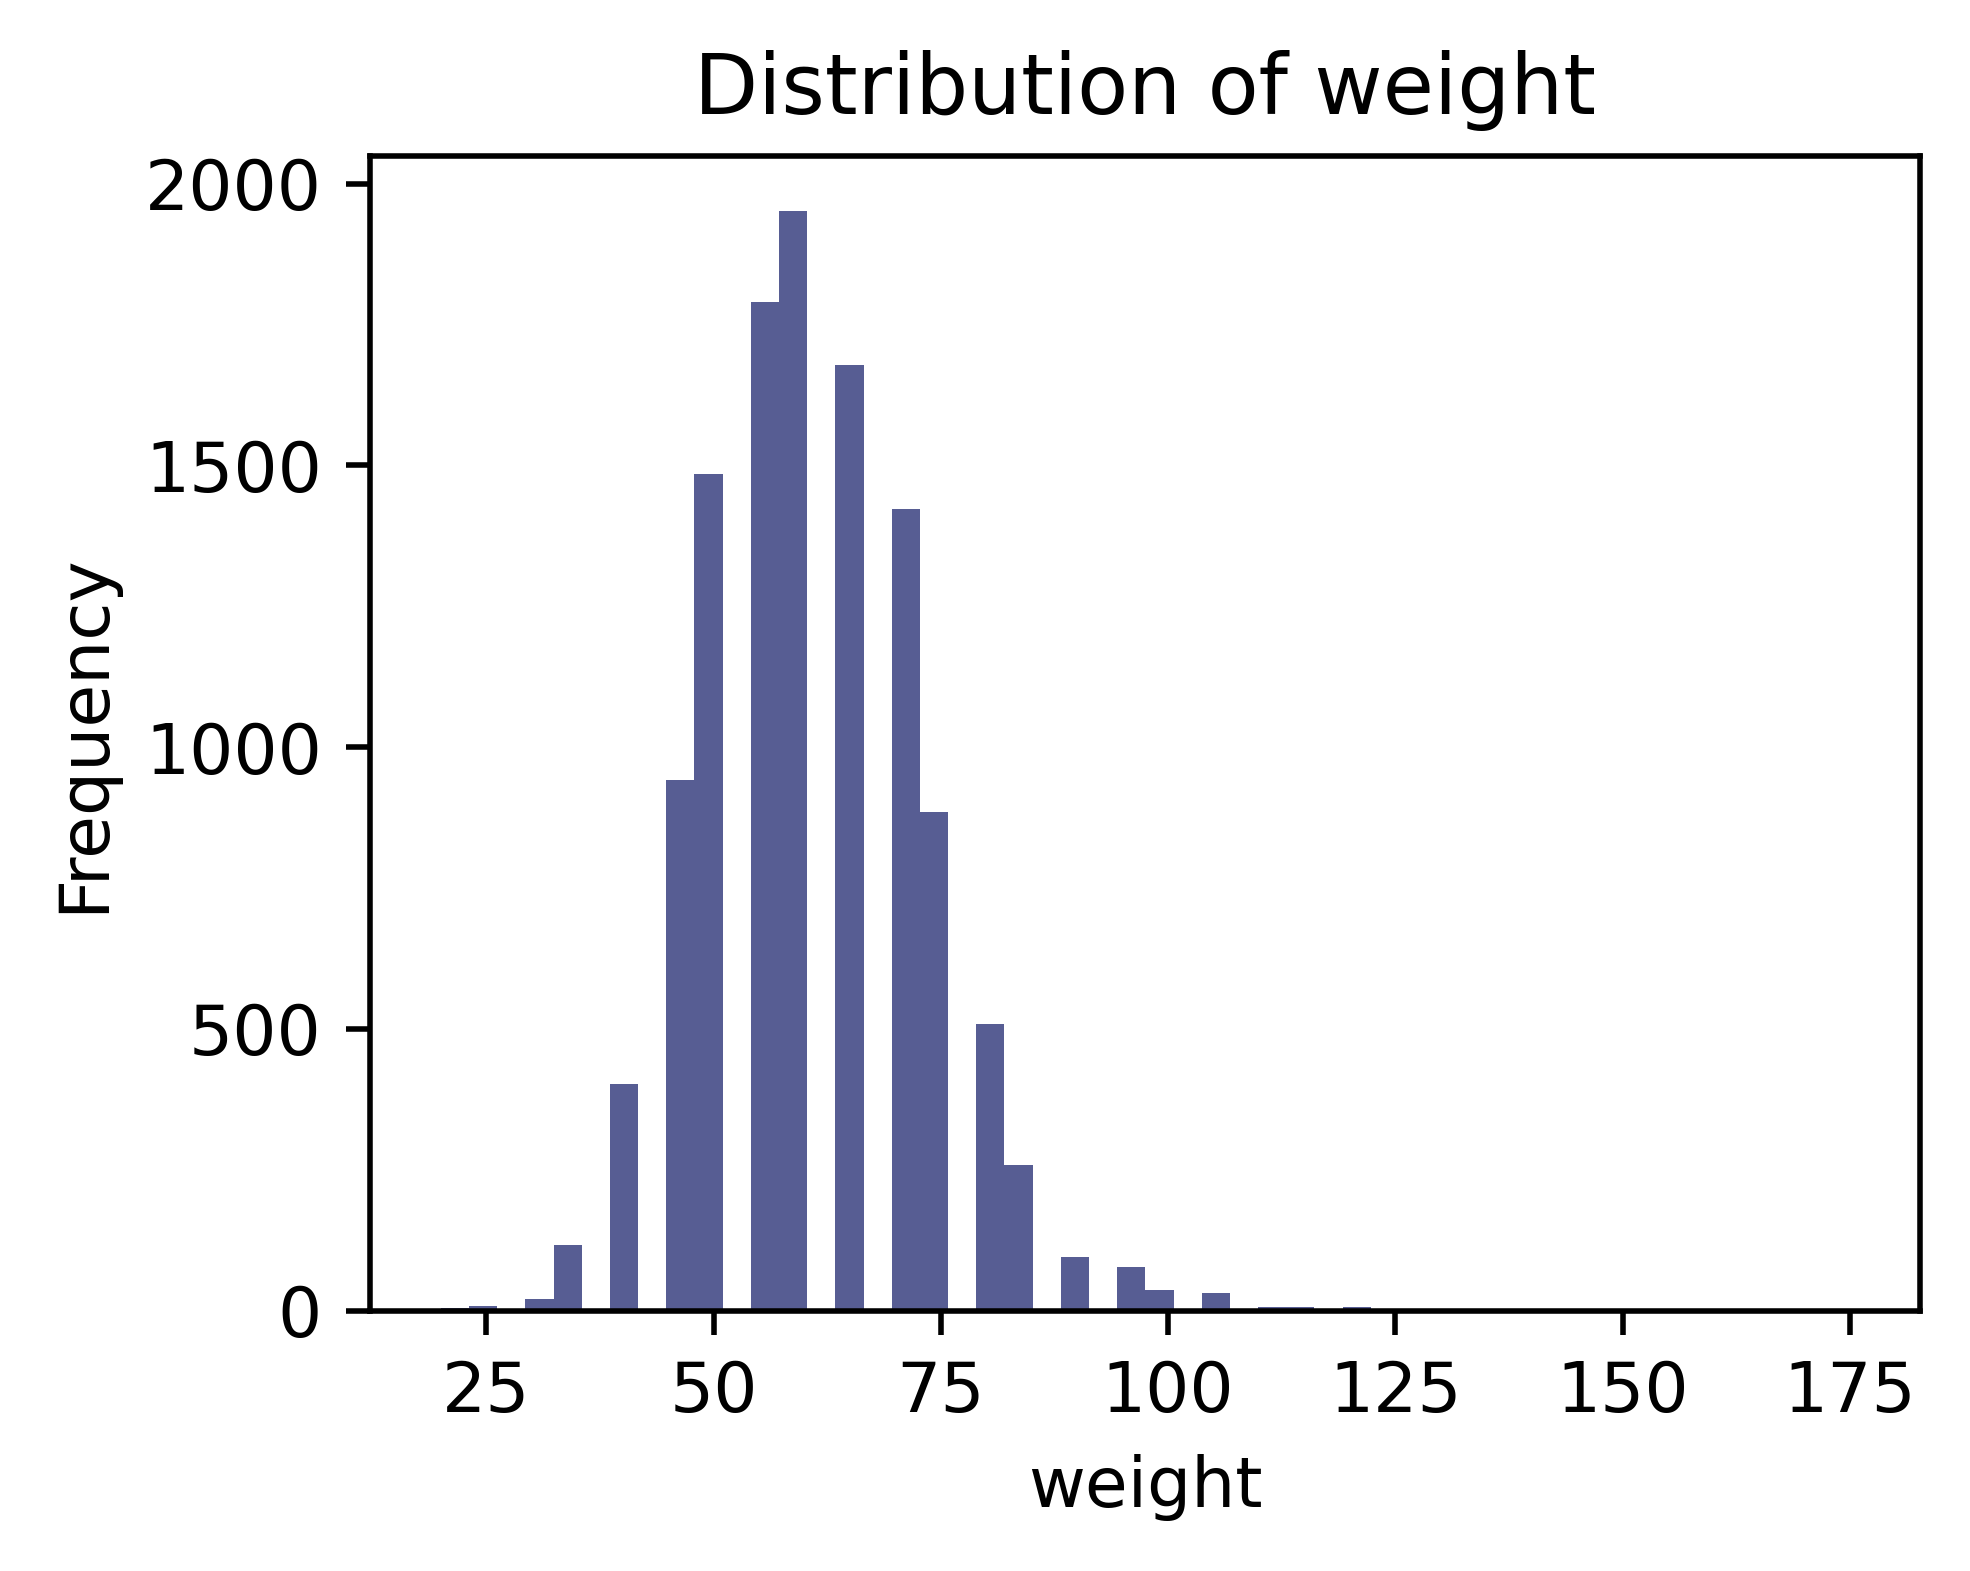

anstart_time: min = 5.0, max = 5133090.0 


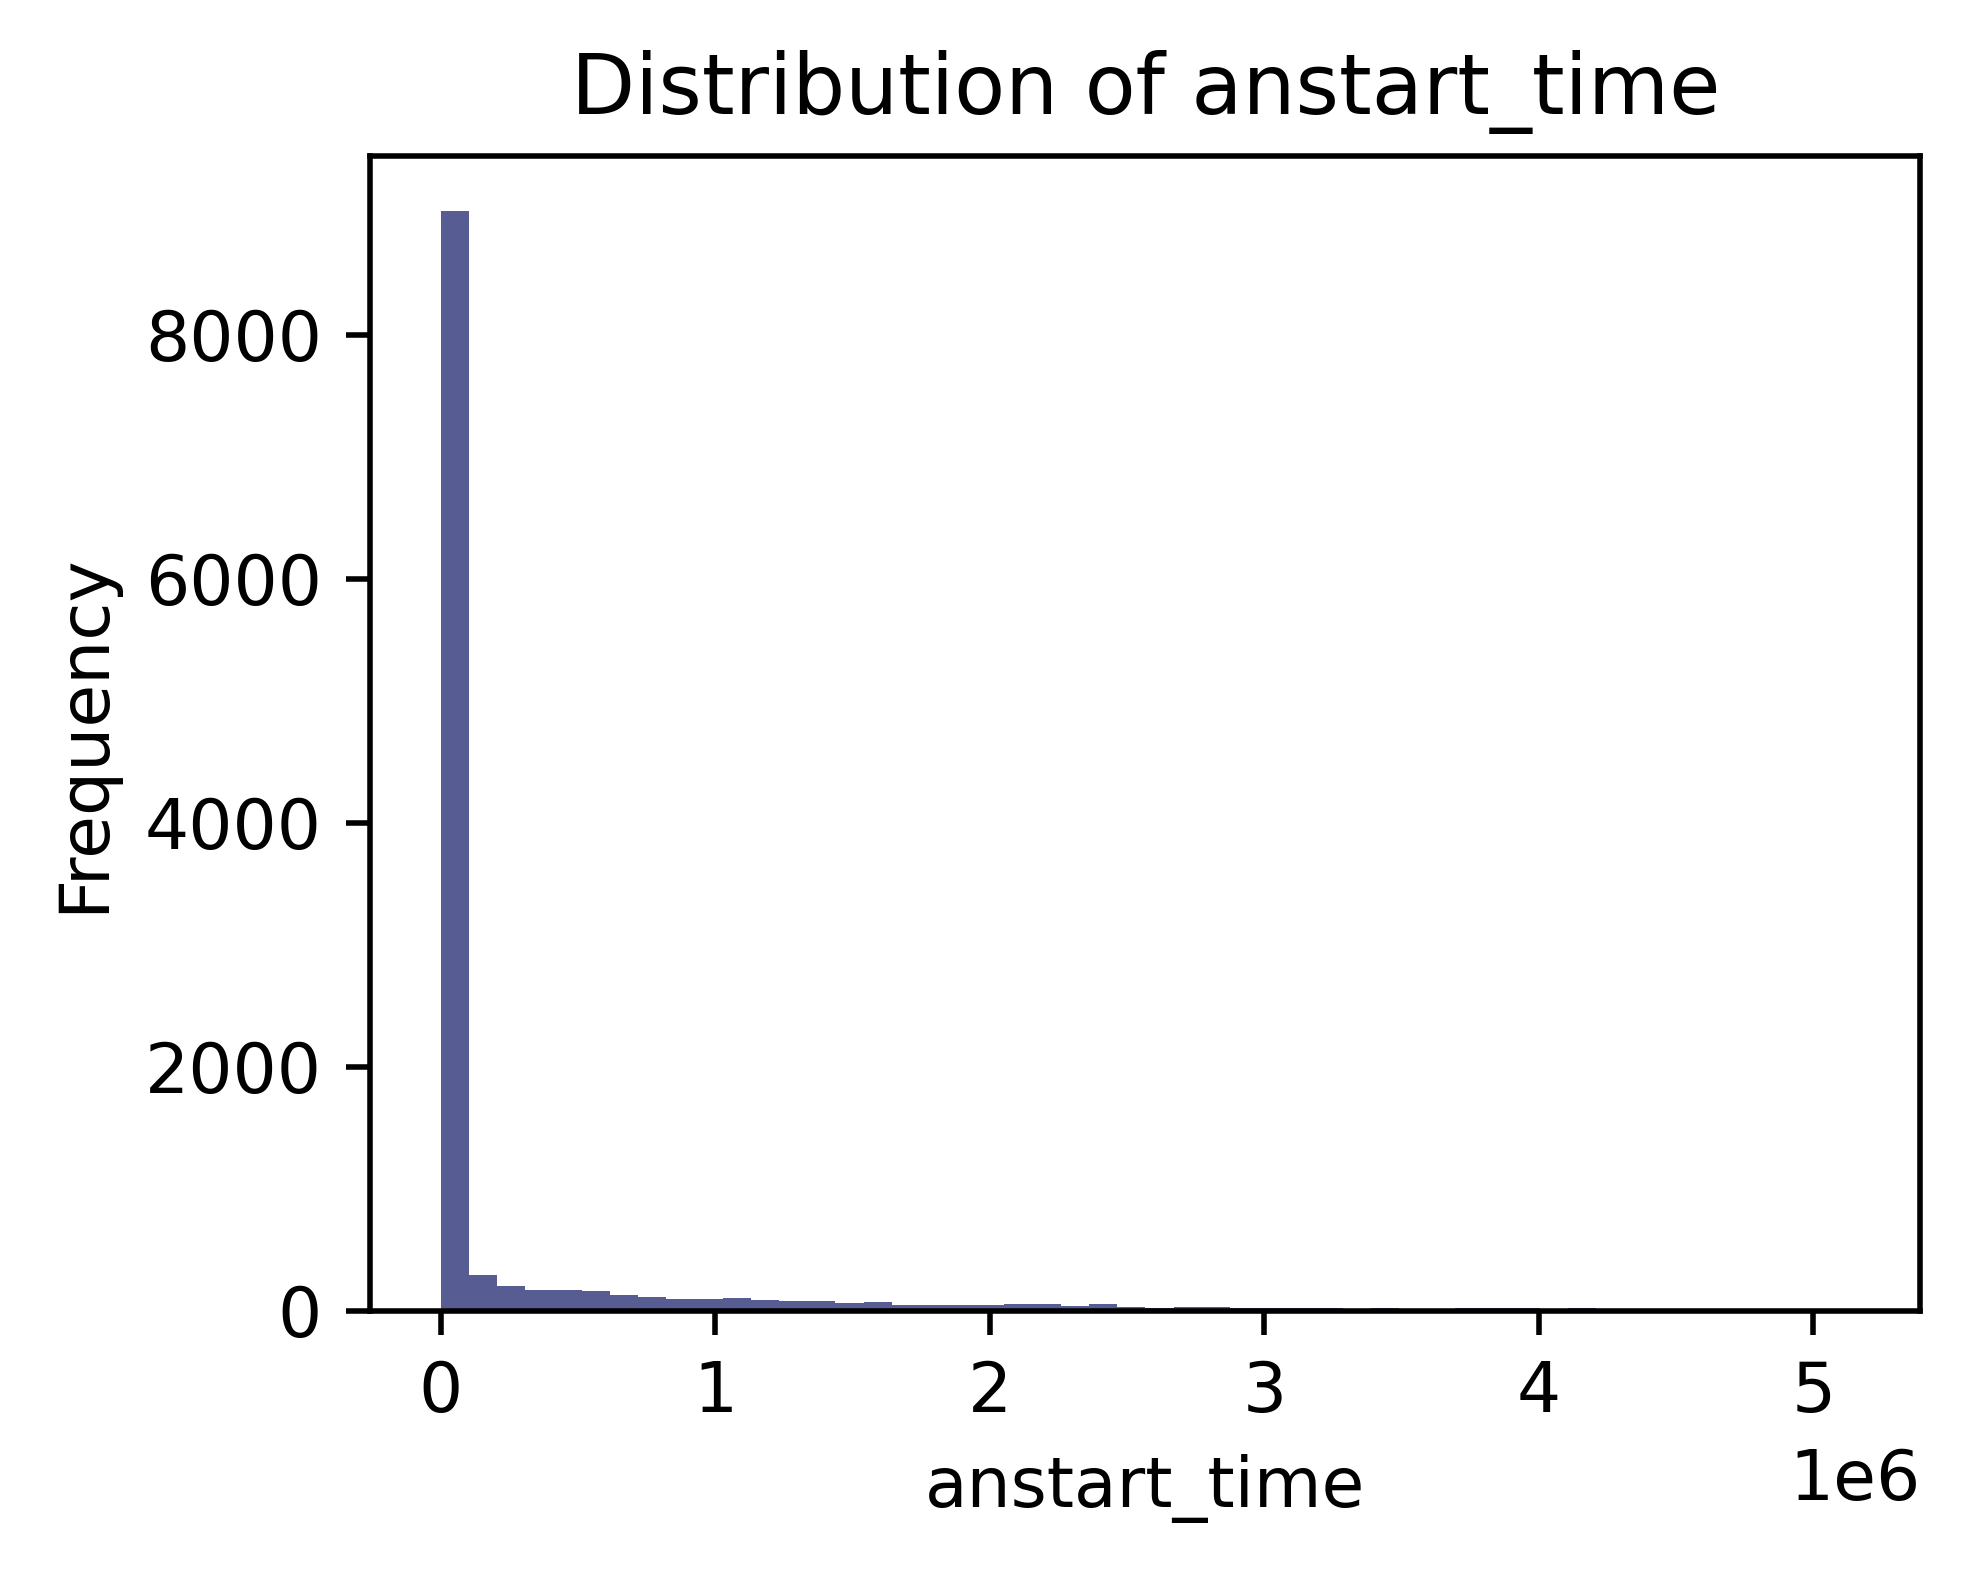

anend_time: min = 105.0, max = 5133570.0 


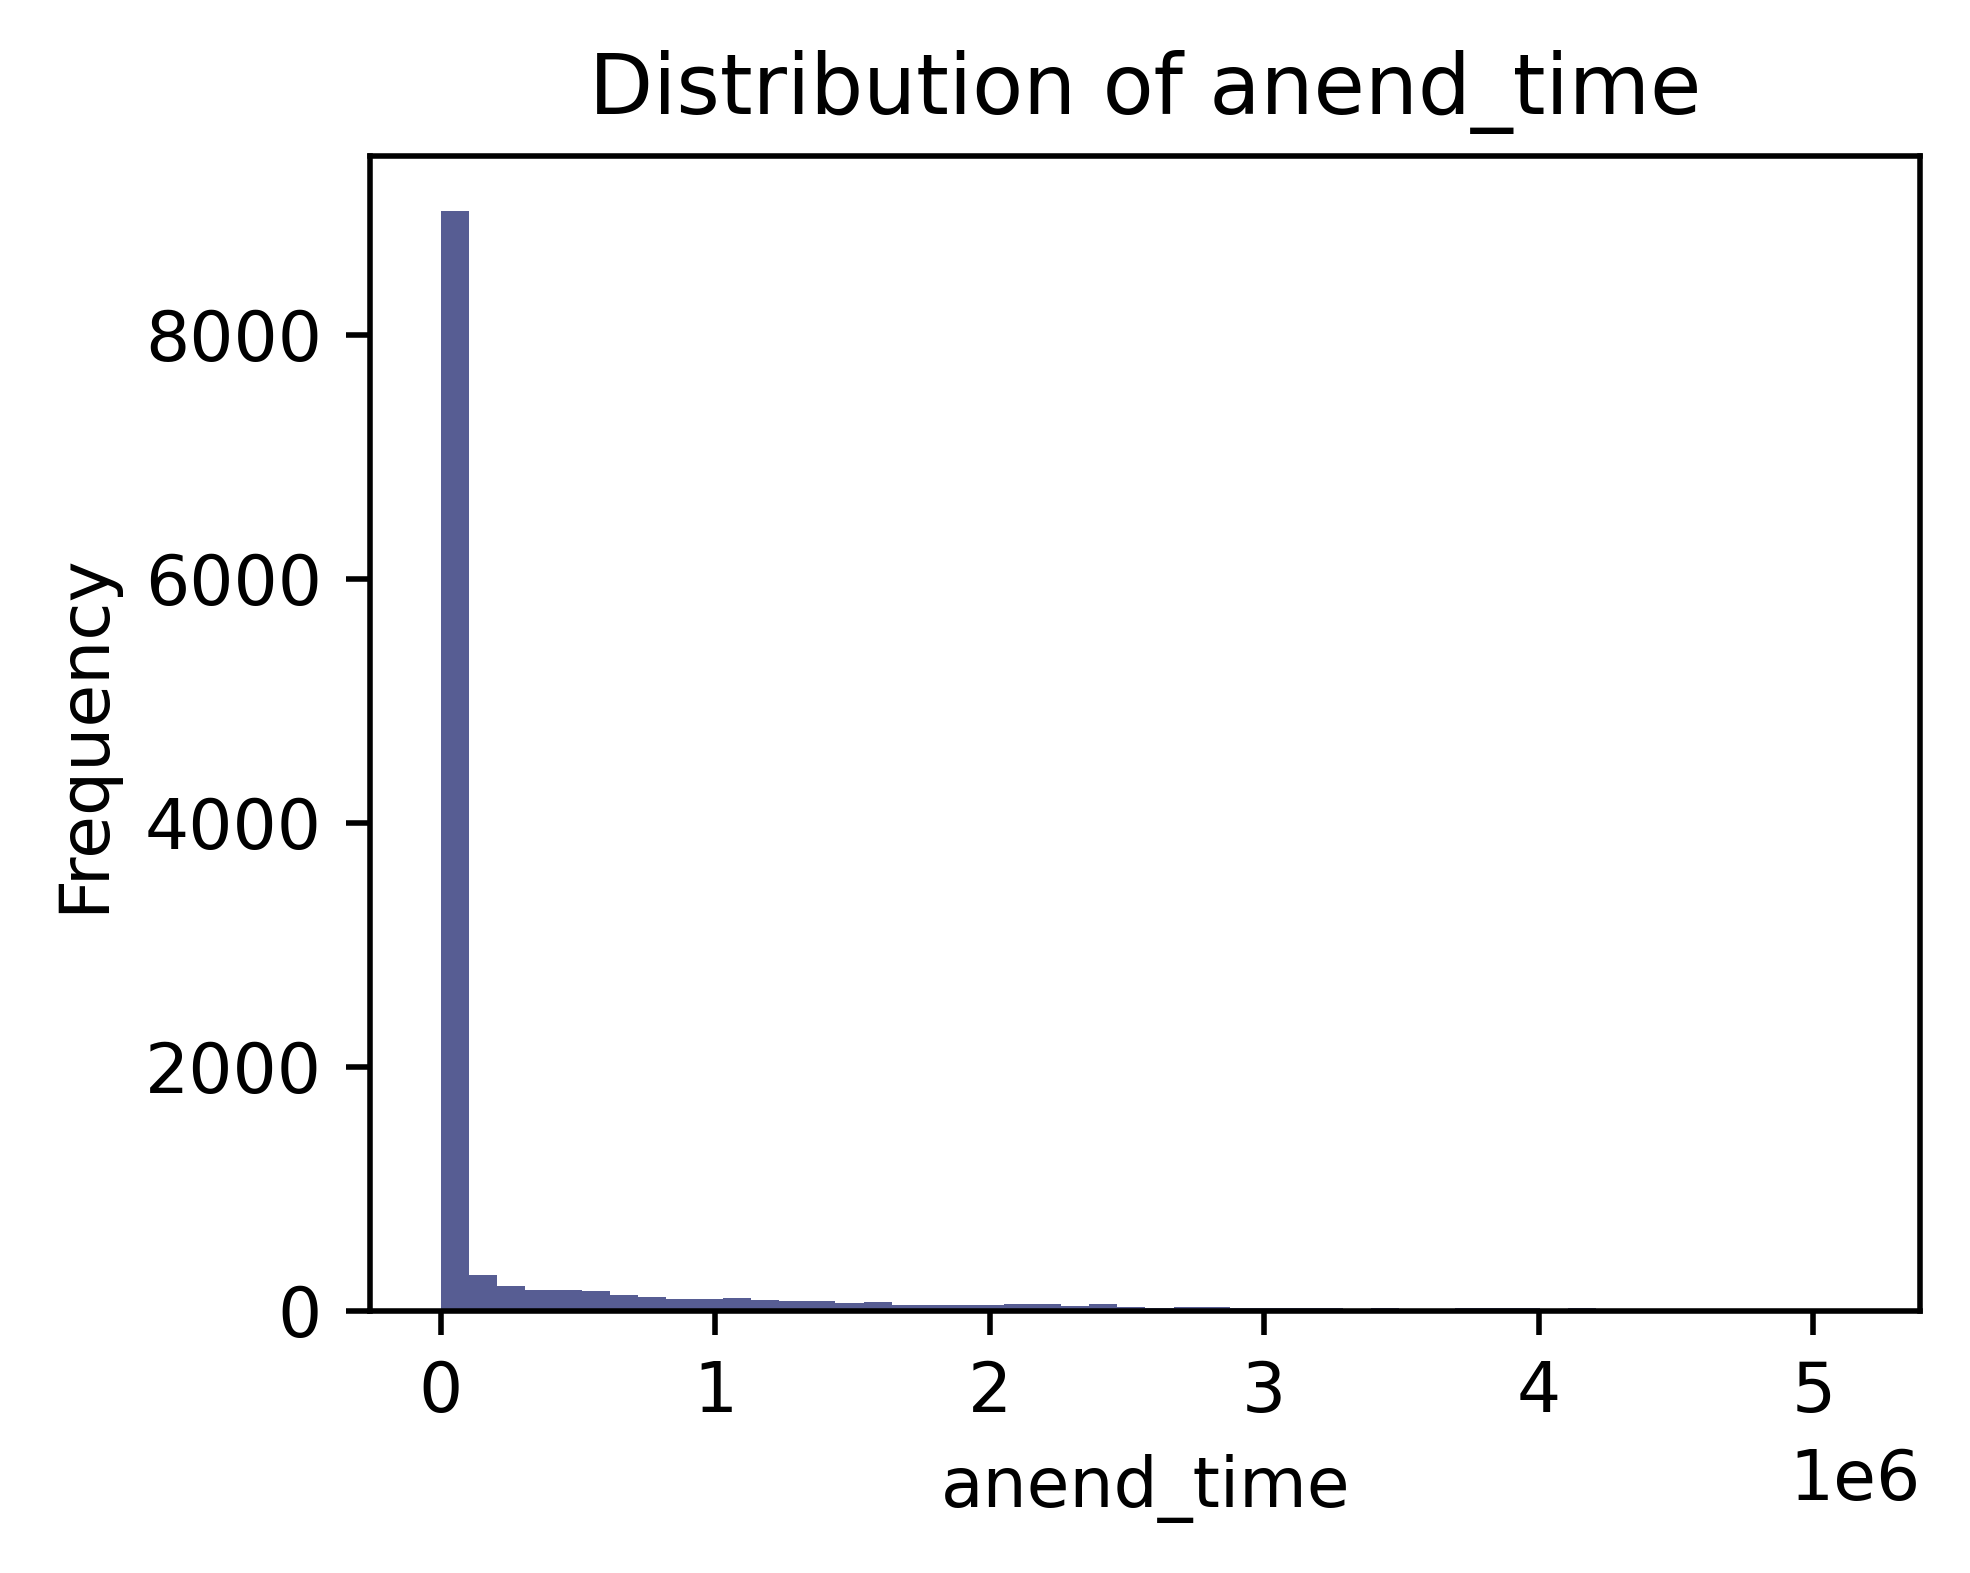

icd10_pcs: min = 00110, max = 10D00 


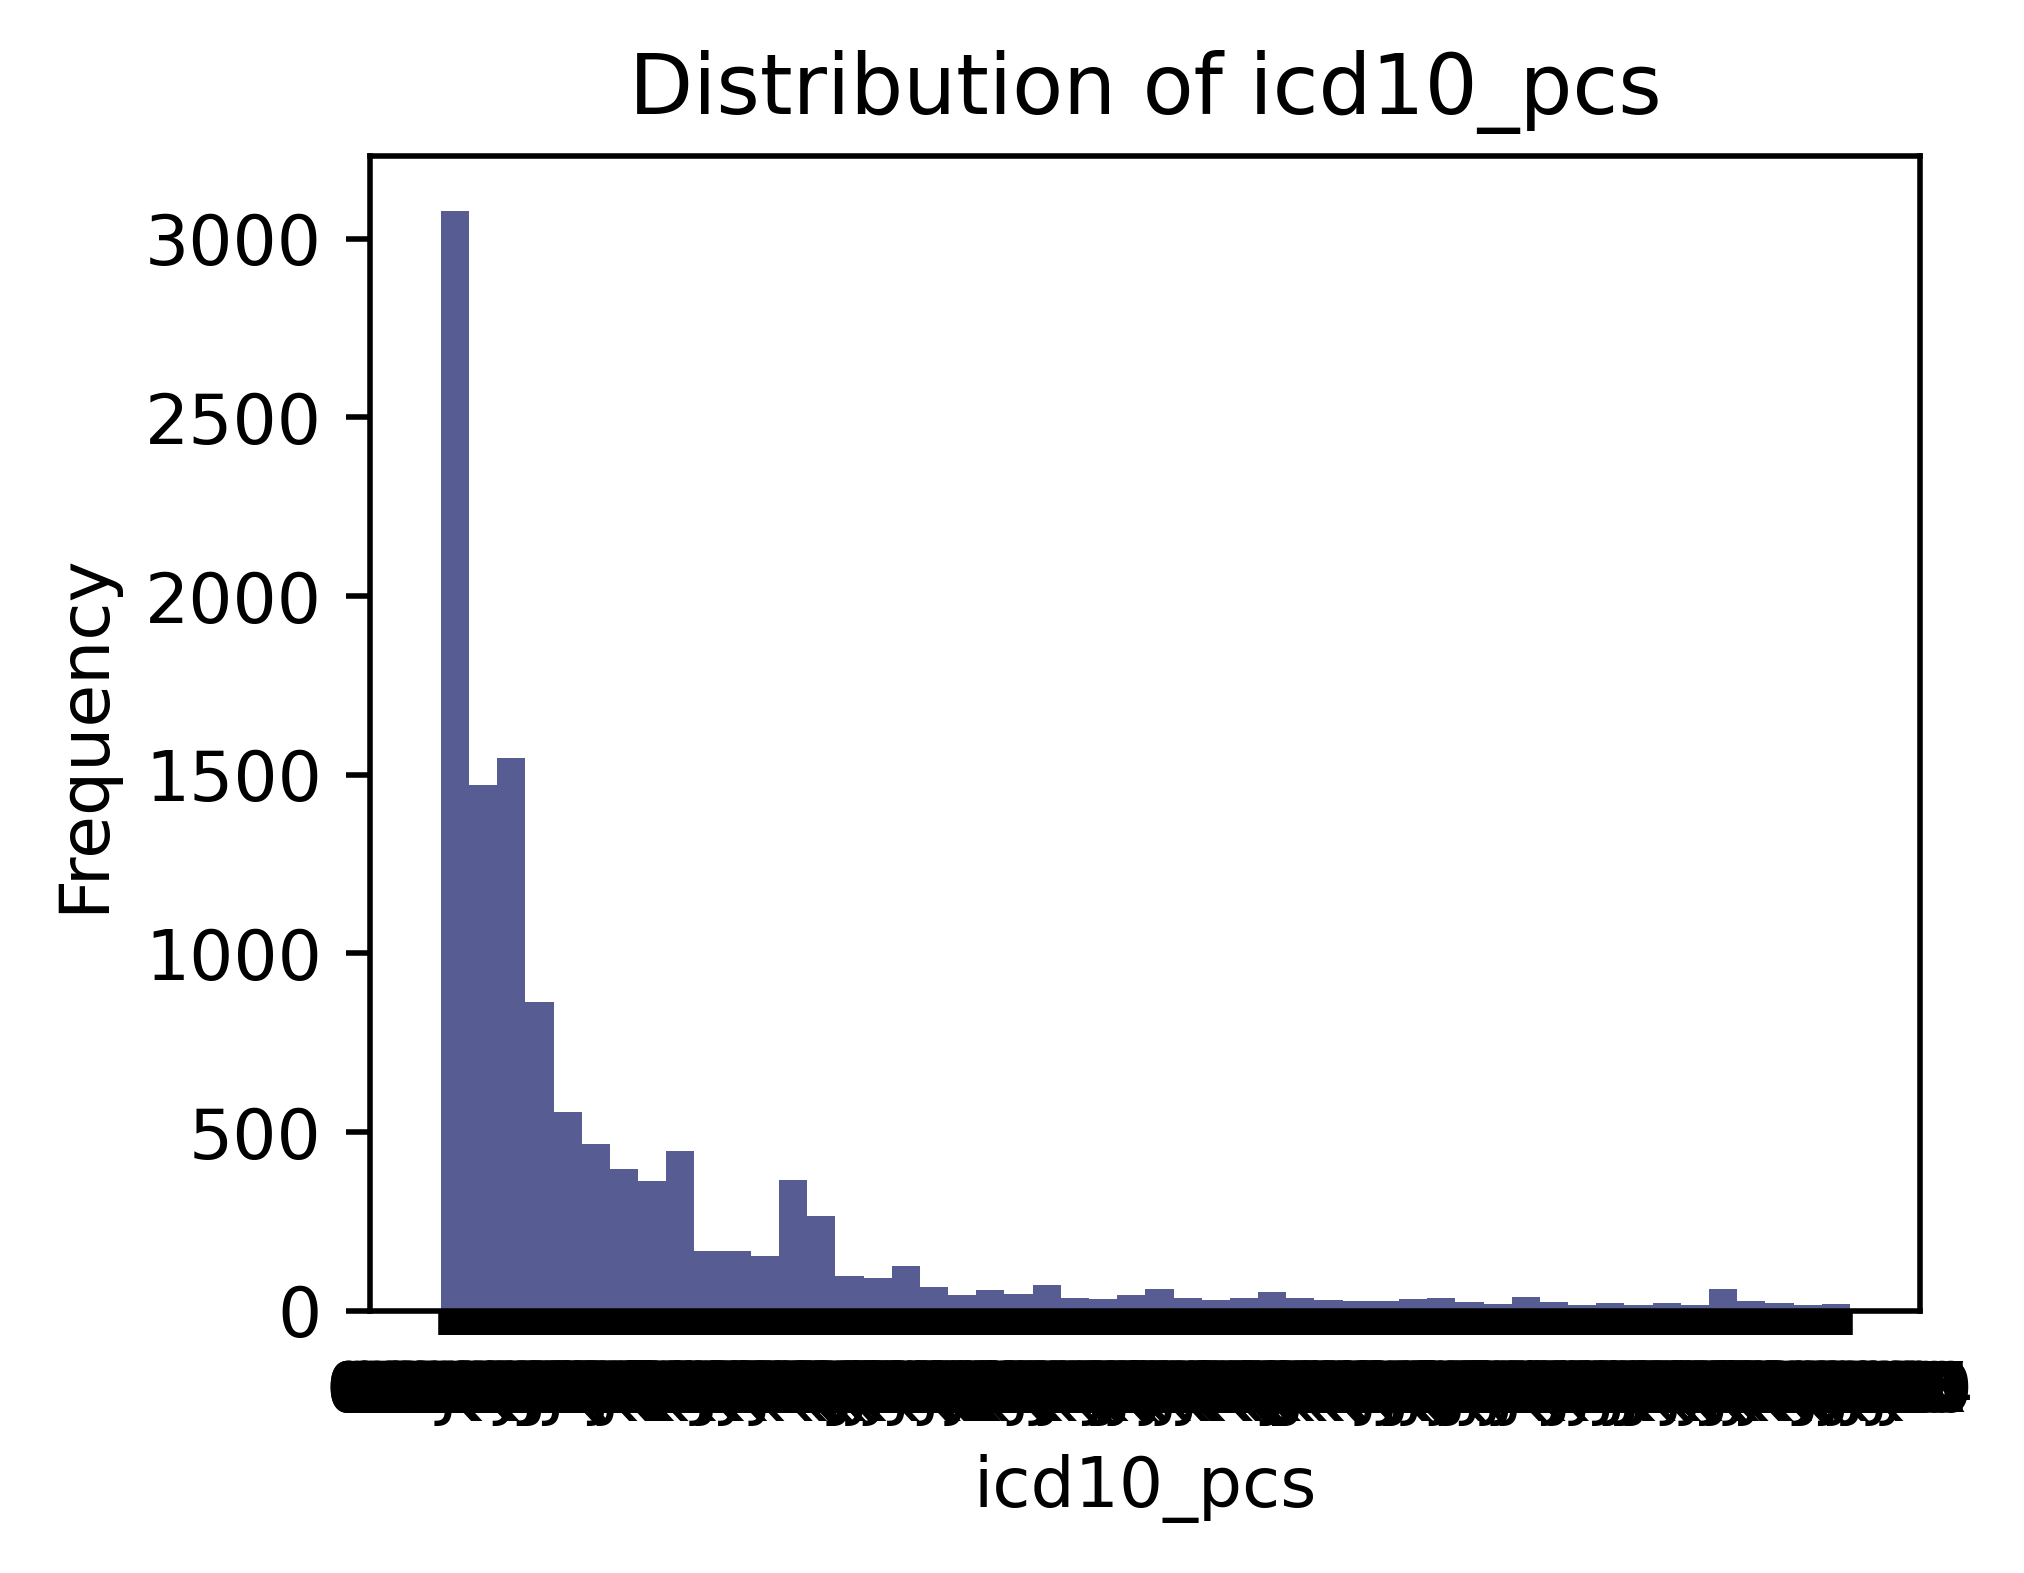

antype: min = General, max = Regional 


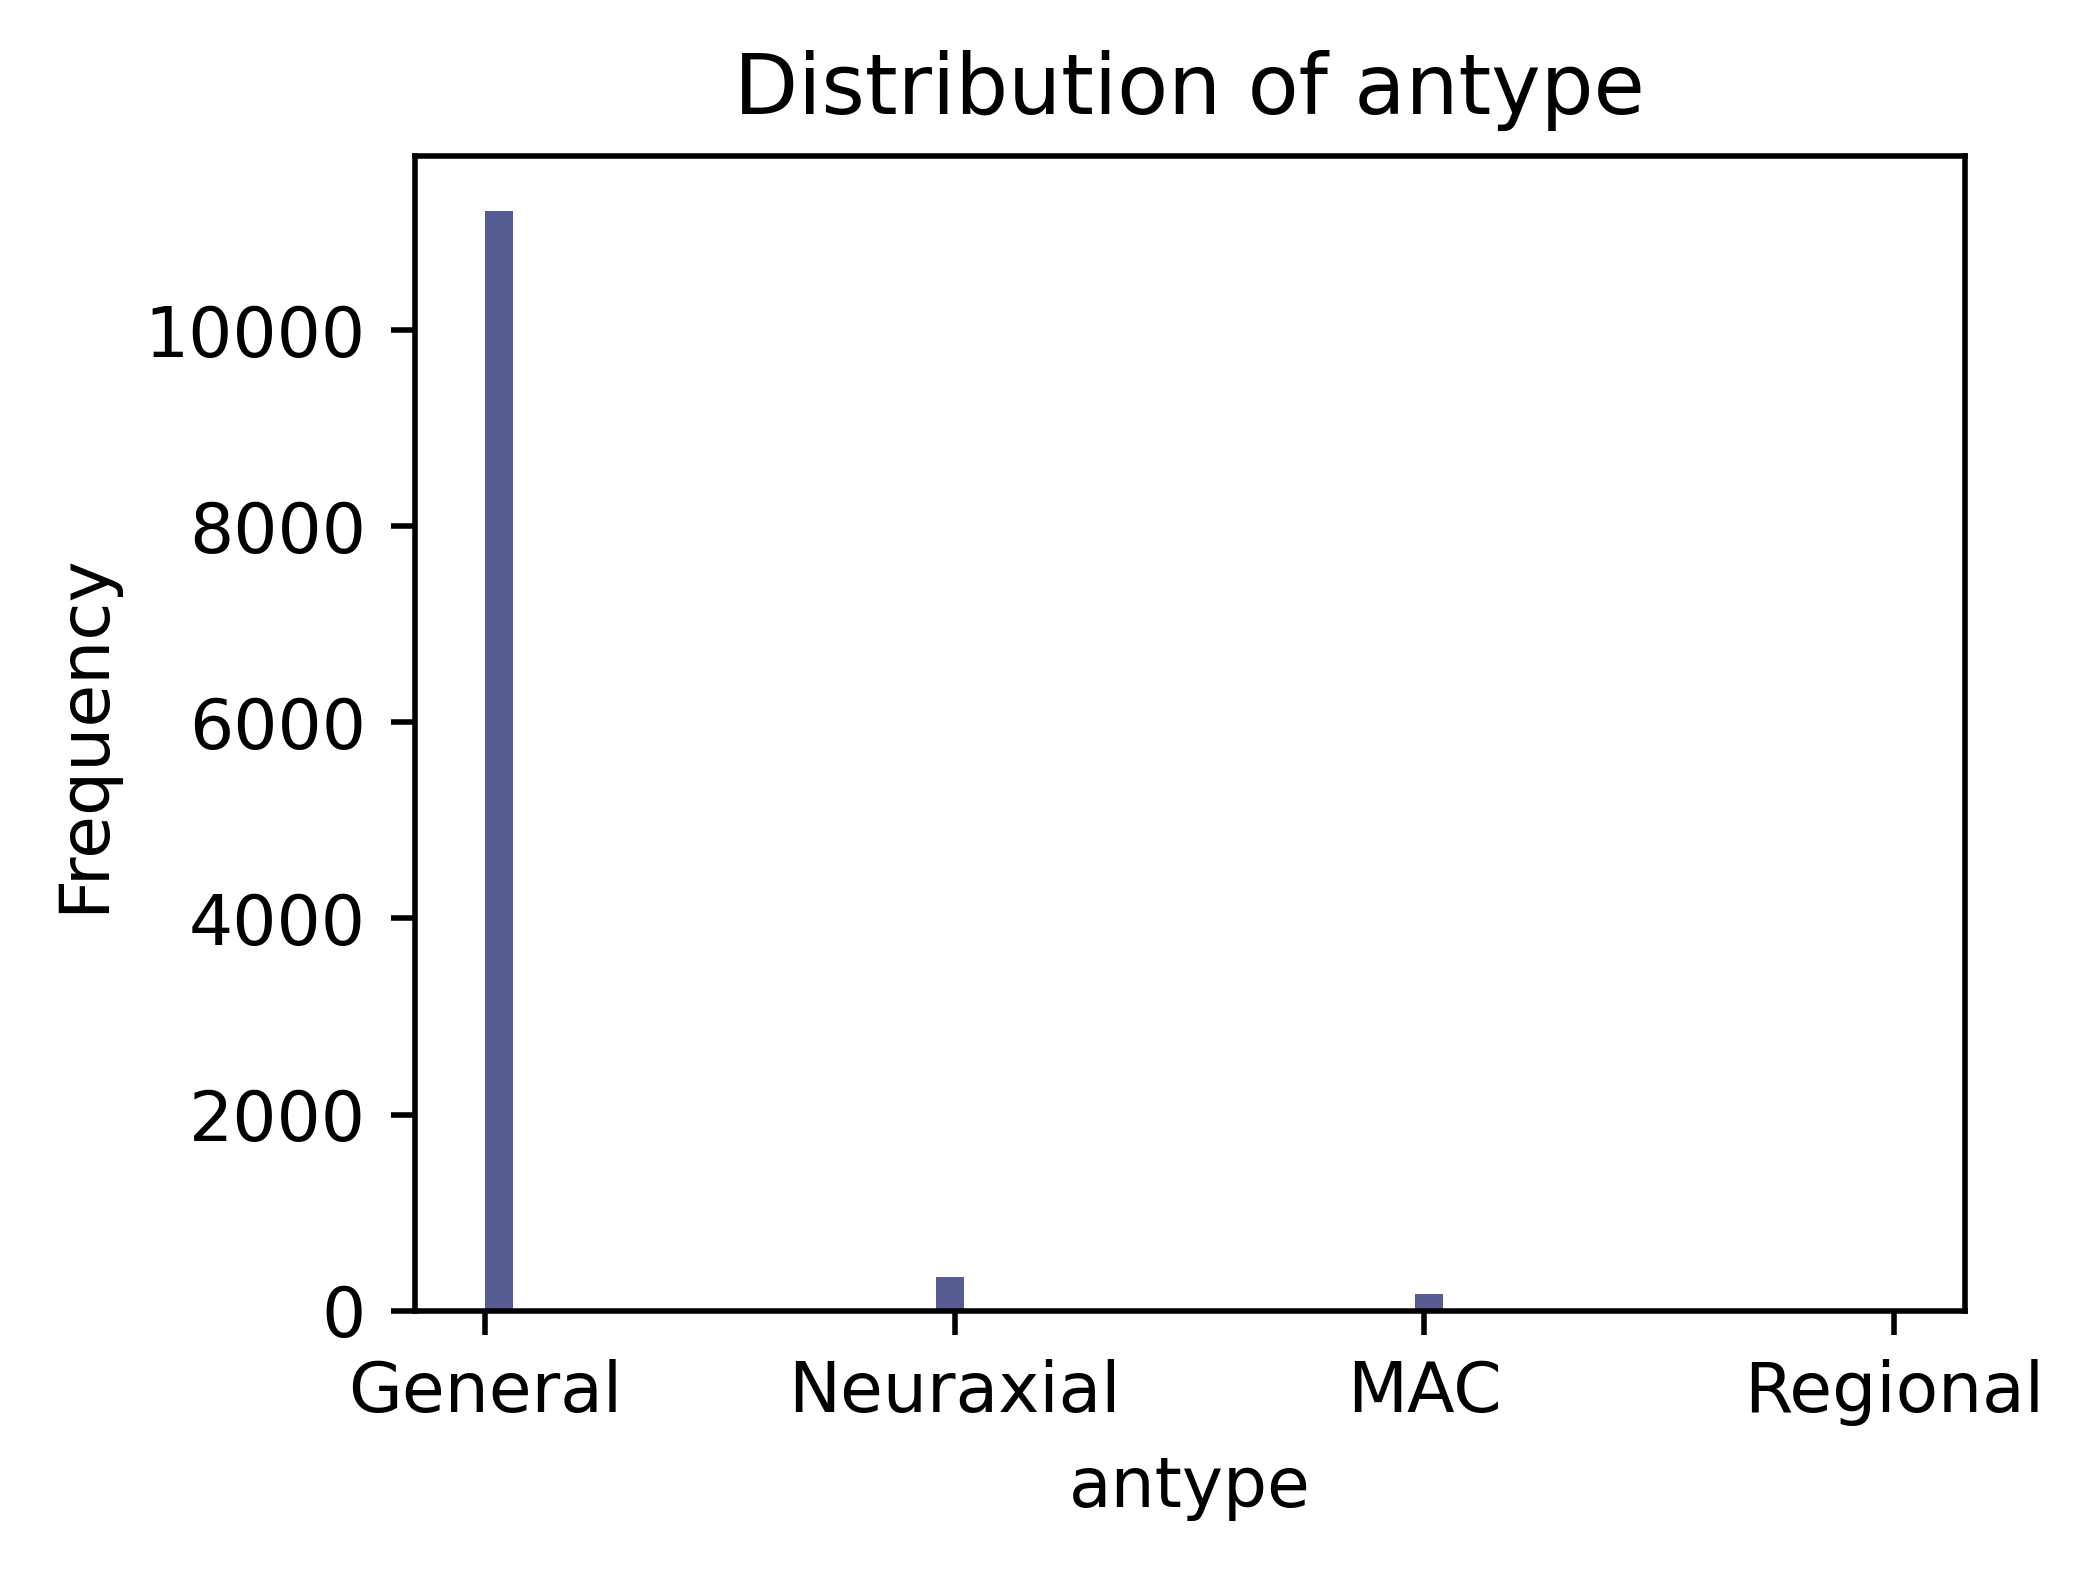

height_m: min = 0.5, max = 2.0 


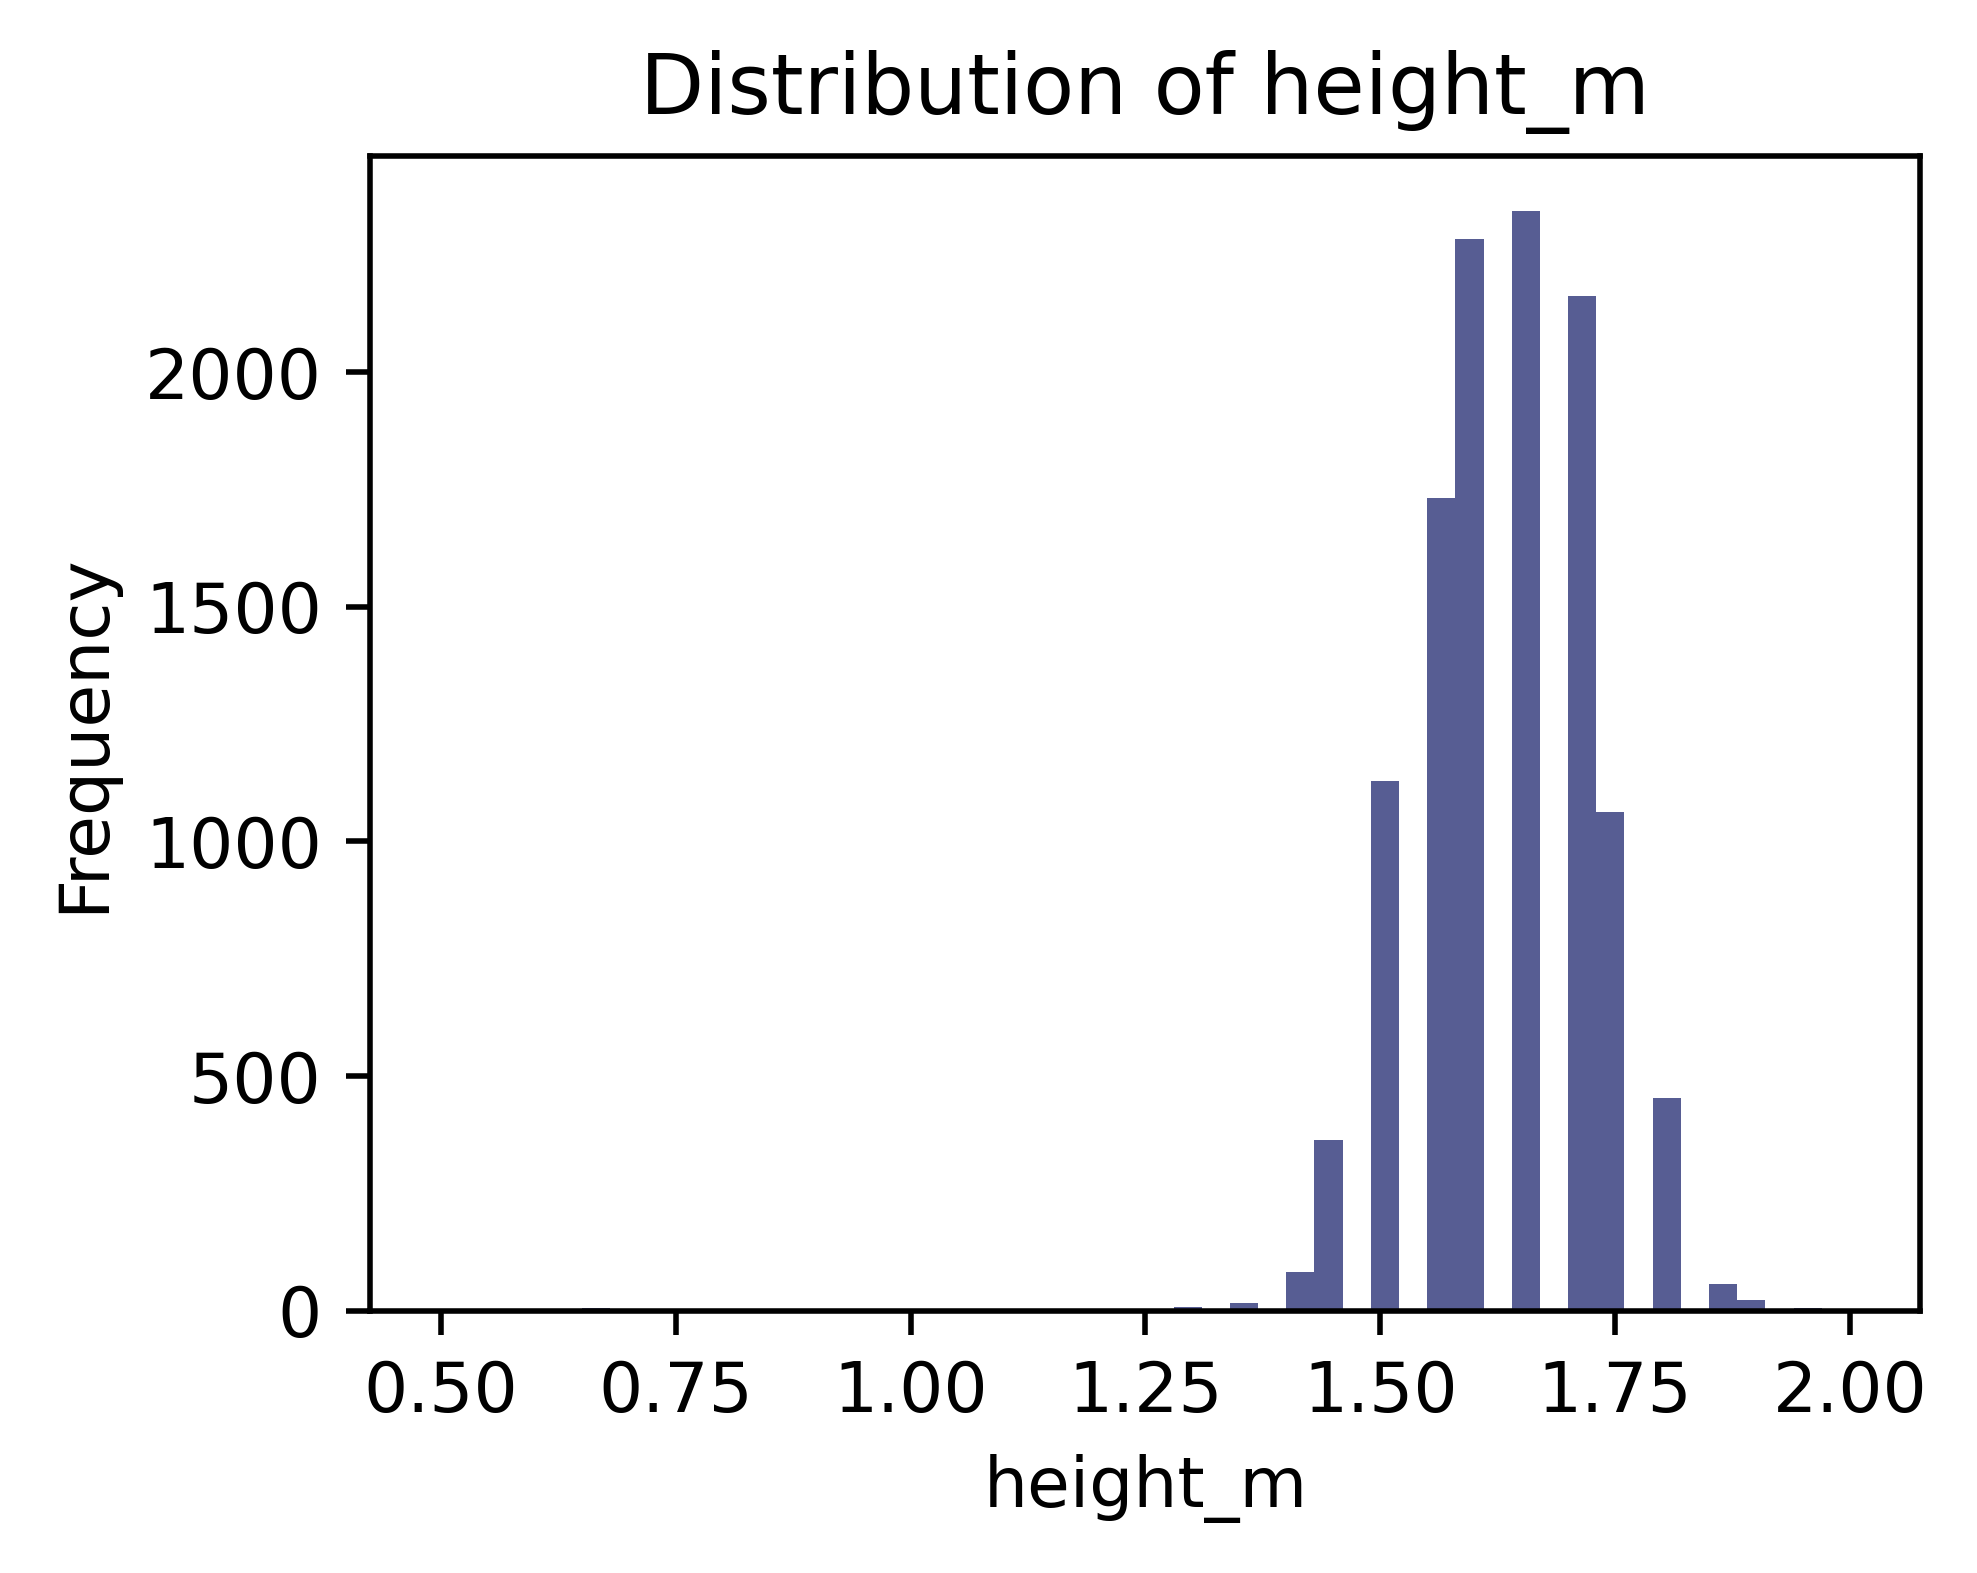

BMI: min = 10.802469135802468, max = 64.51612903225805 


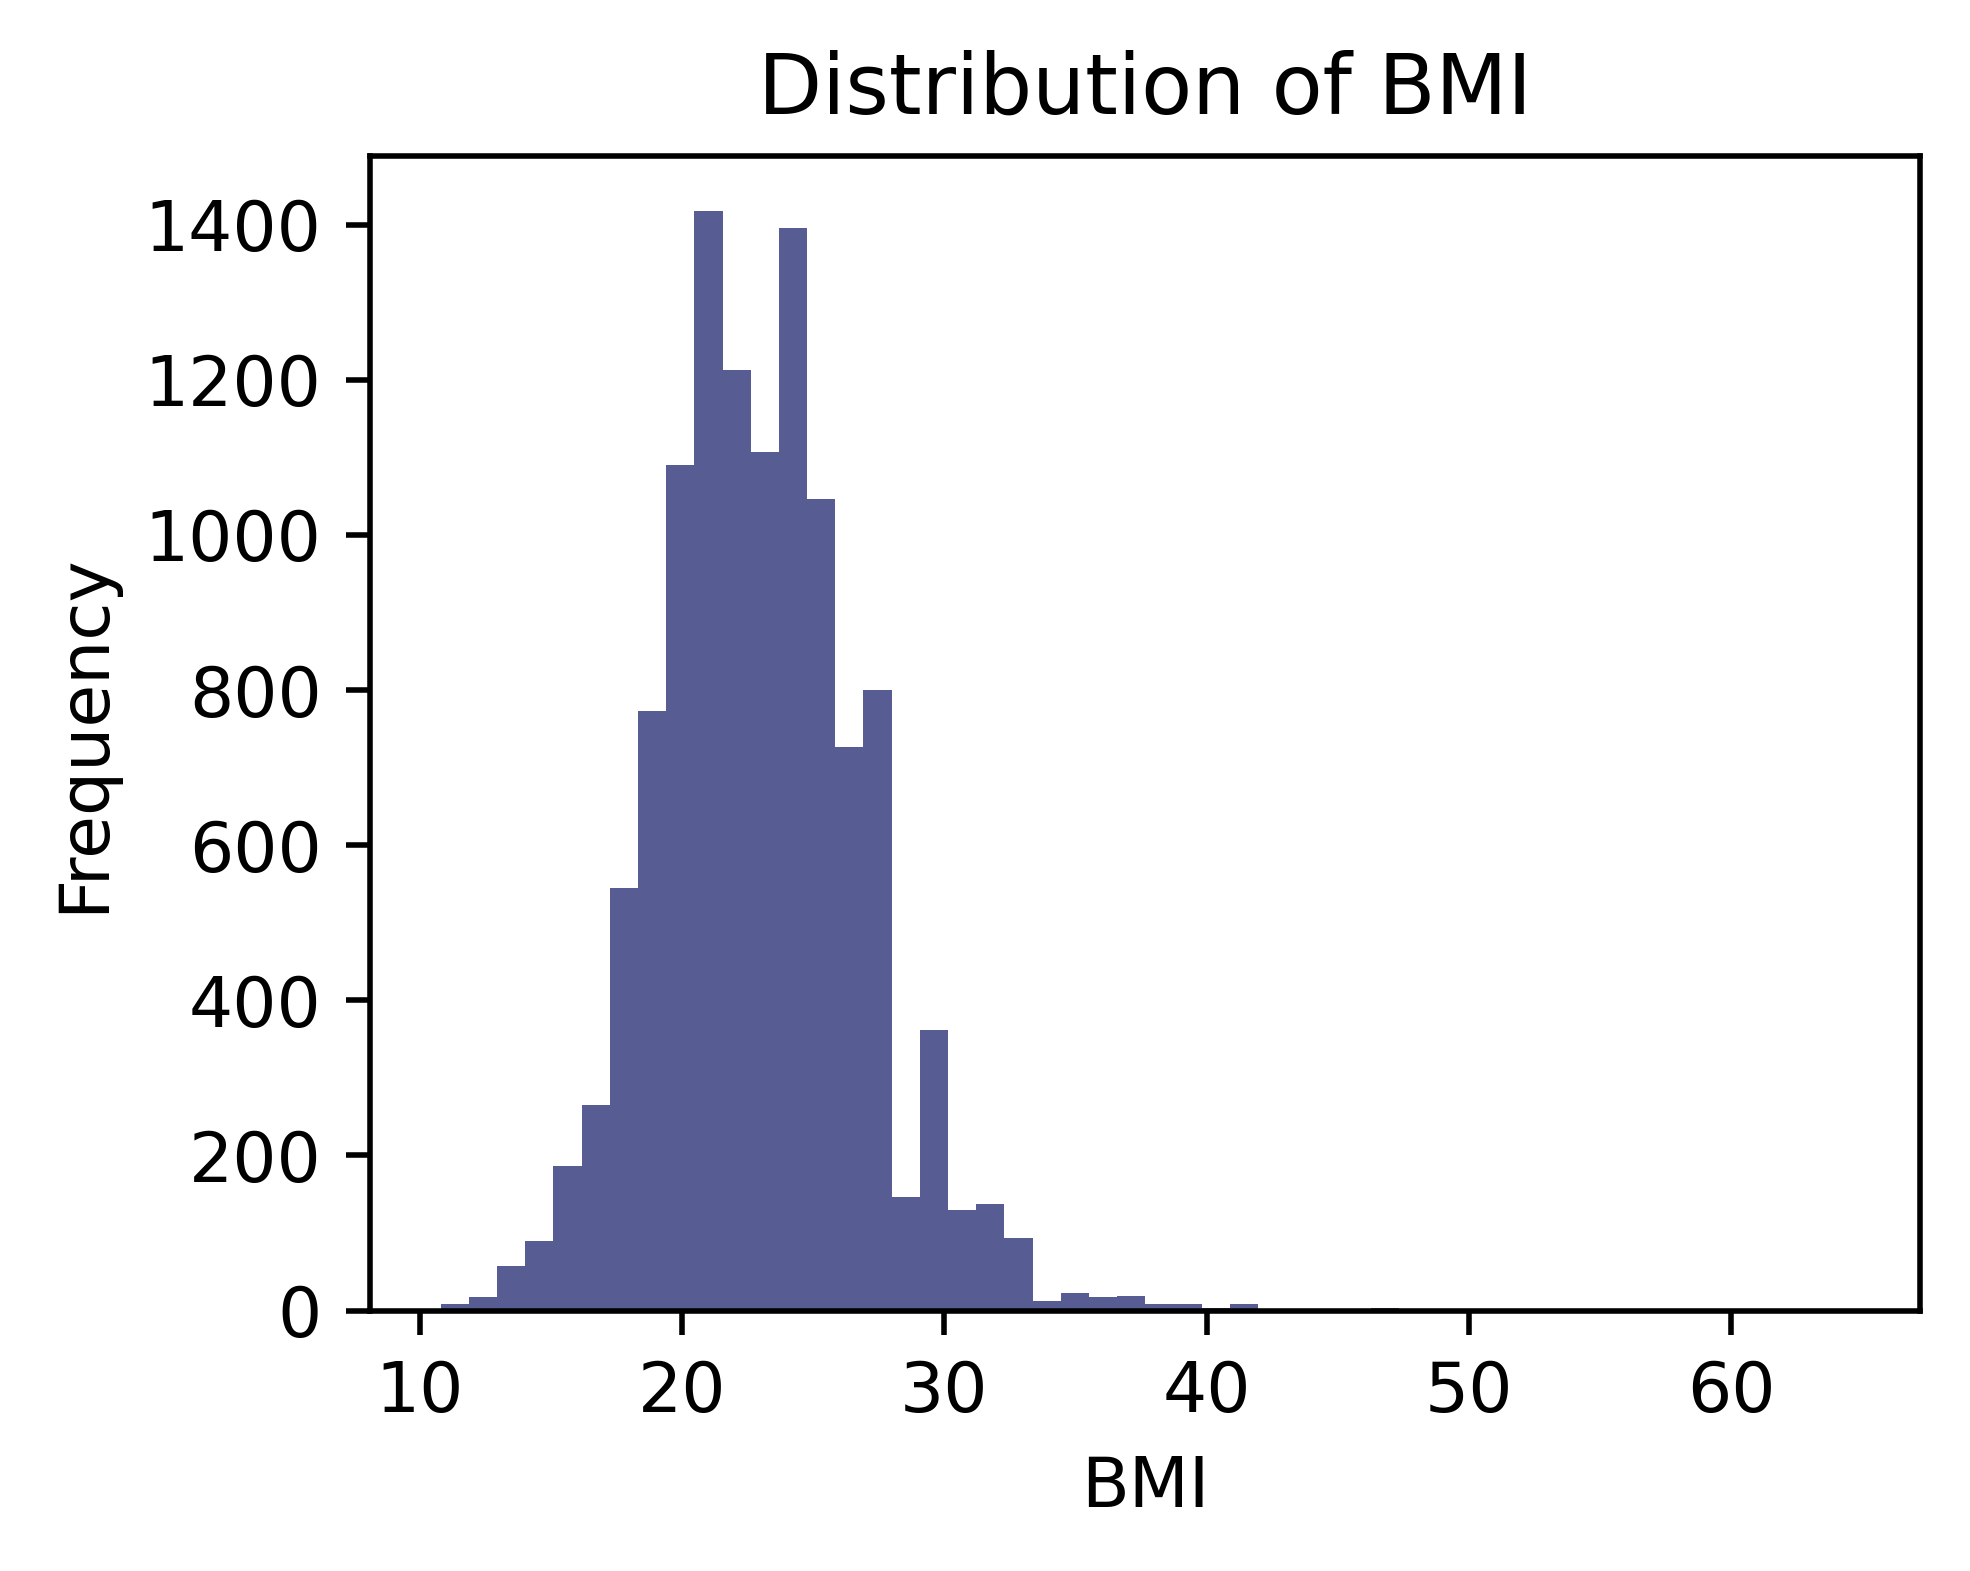

anesthesia_duration: min = 60.0, max = 1435.0 


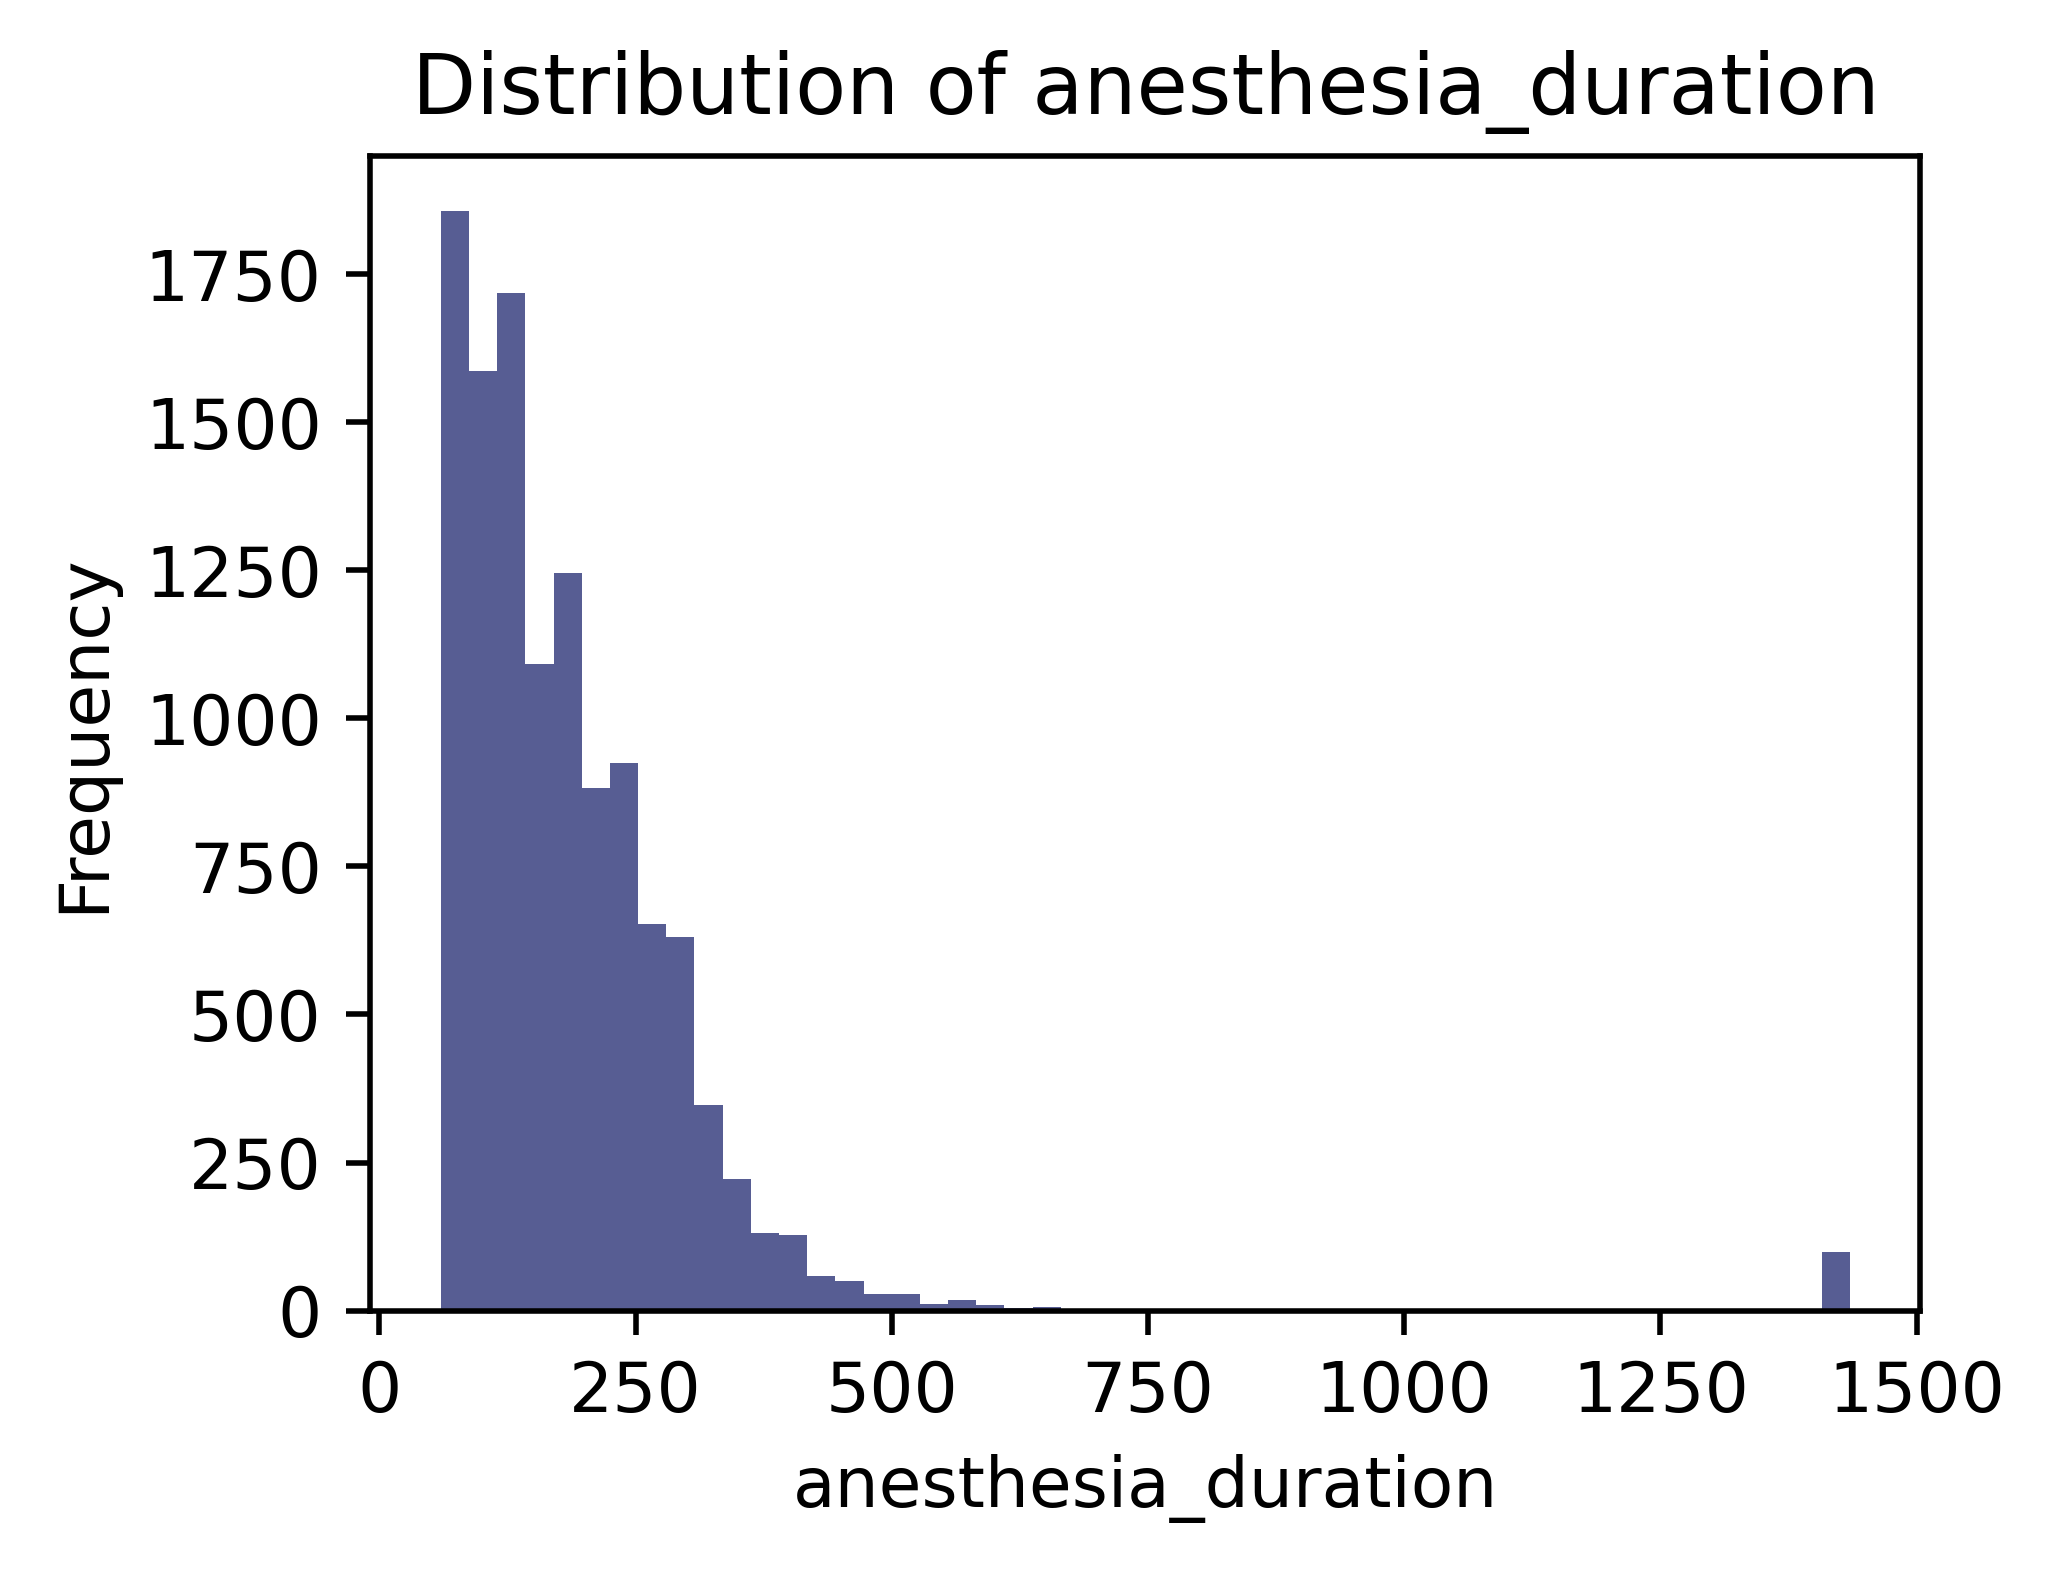

albumin: min = 2.3, max = 4.7 


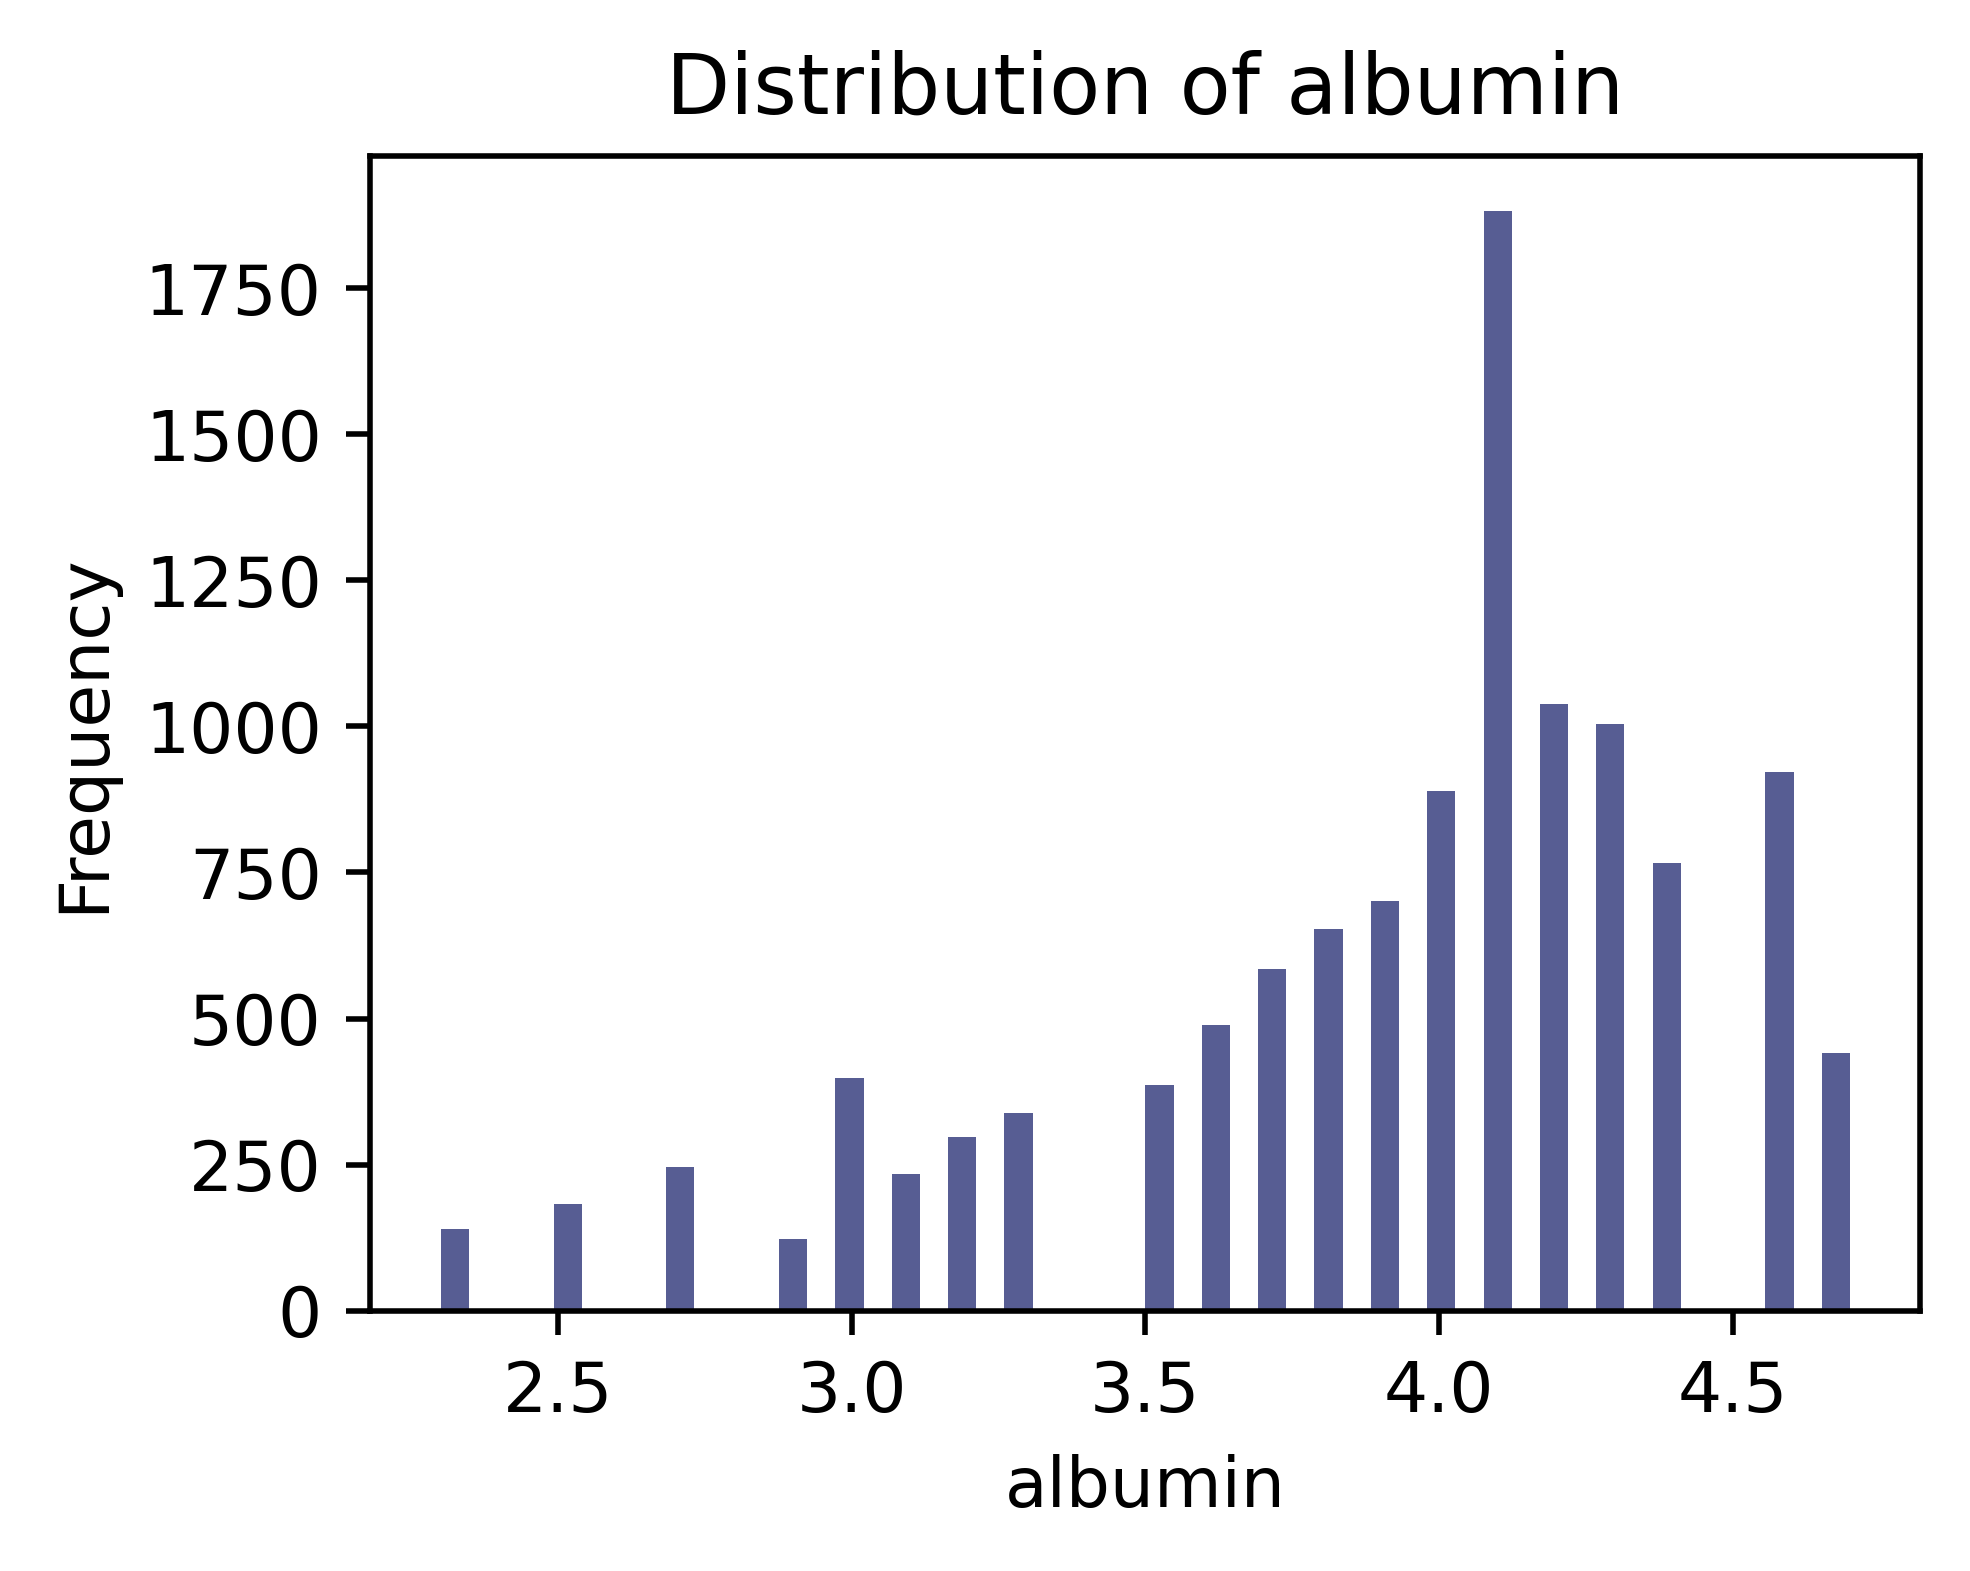

creatinine: min = 0.41, max = 5.55 


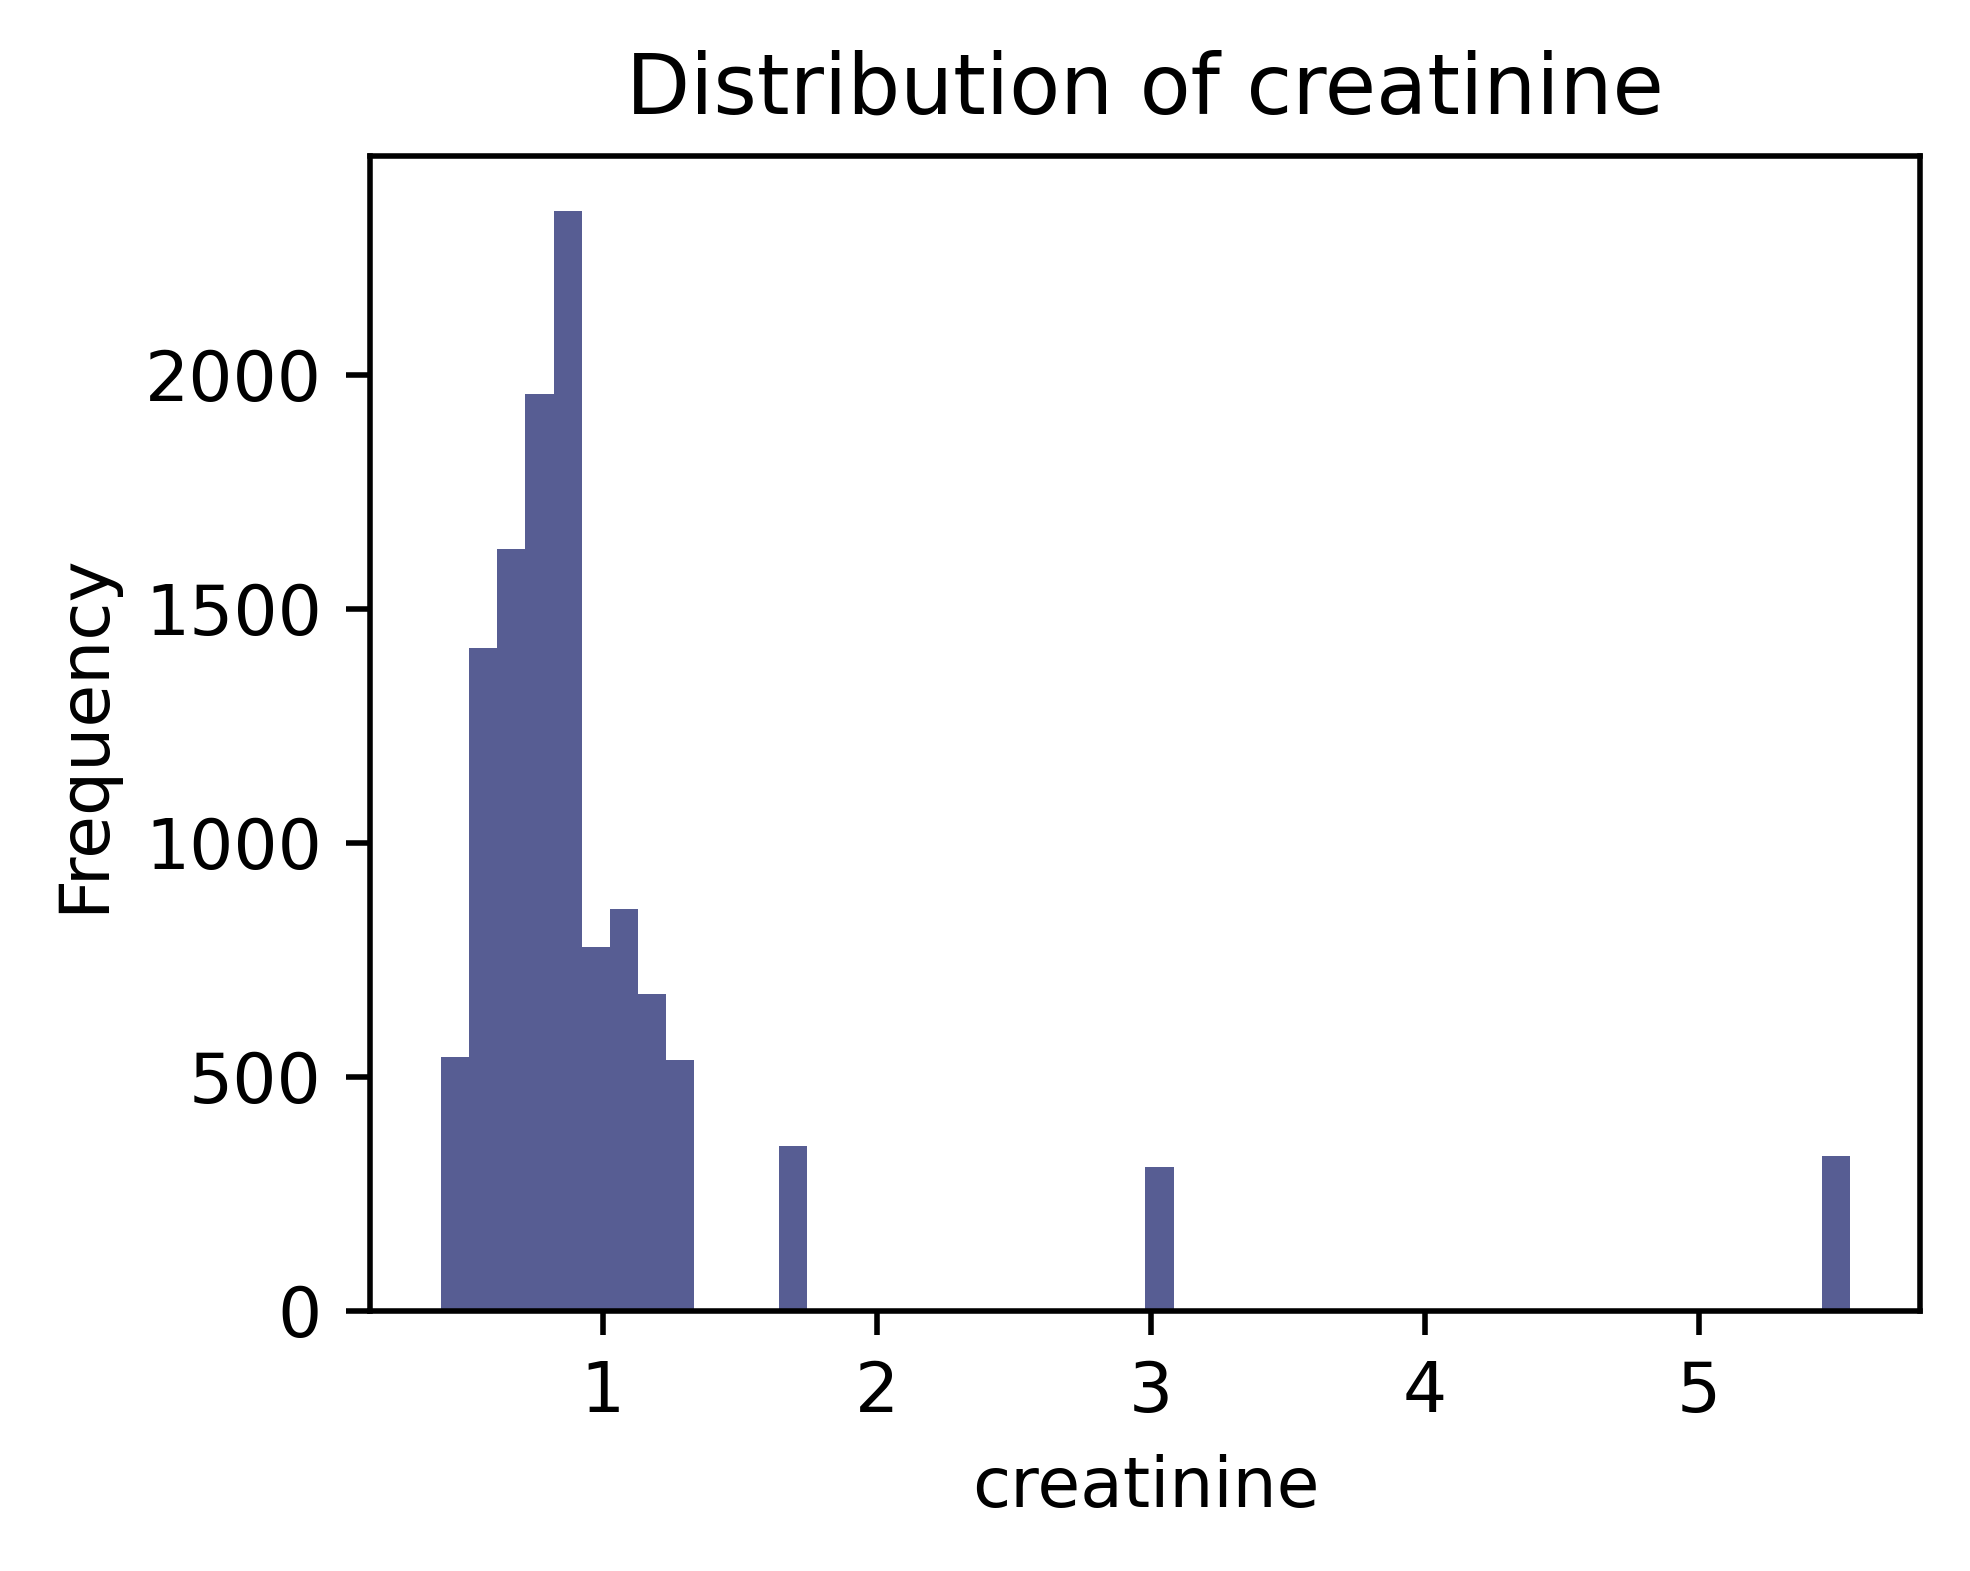

glucose: min = 78.0, max = 302.0 


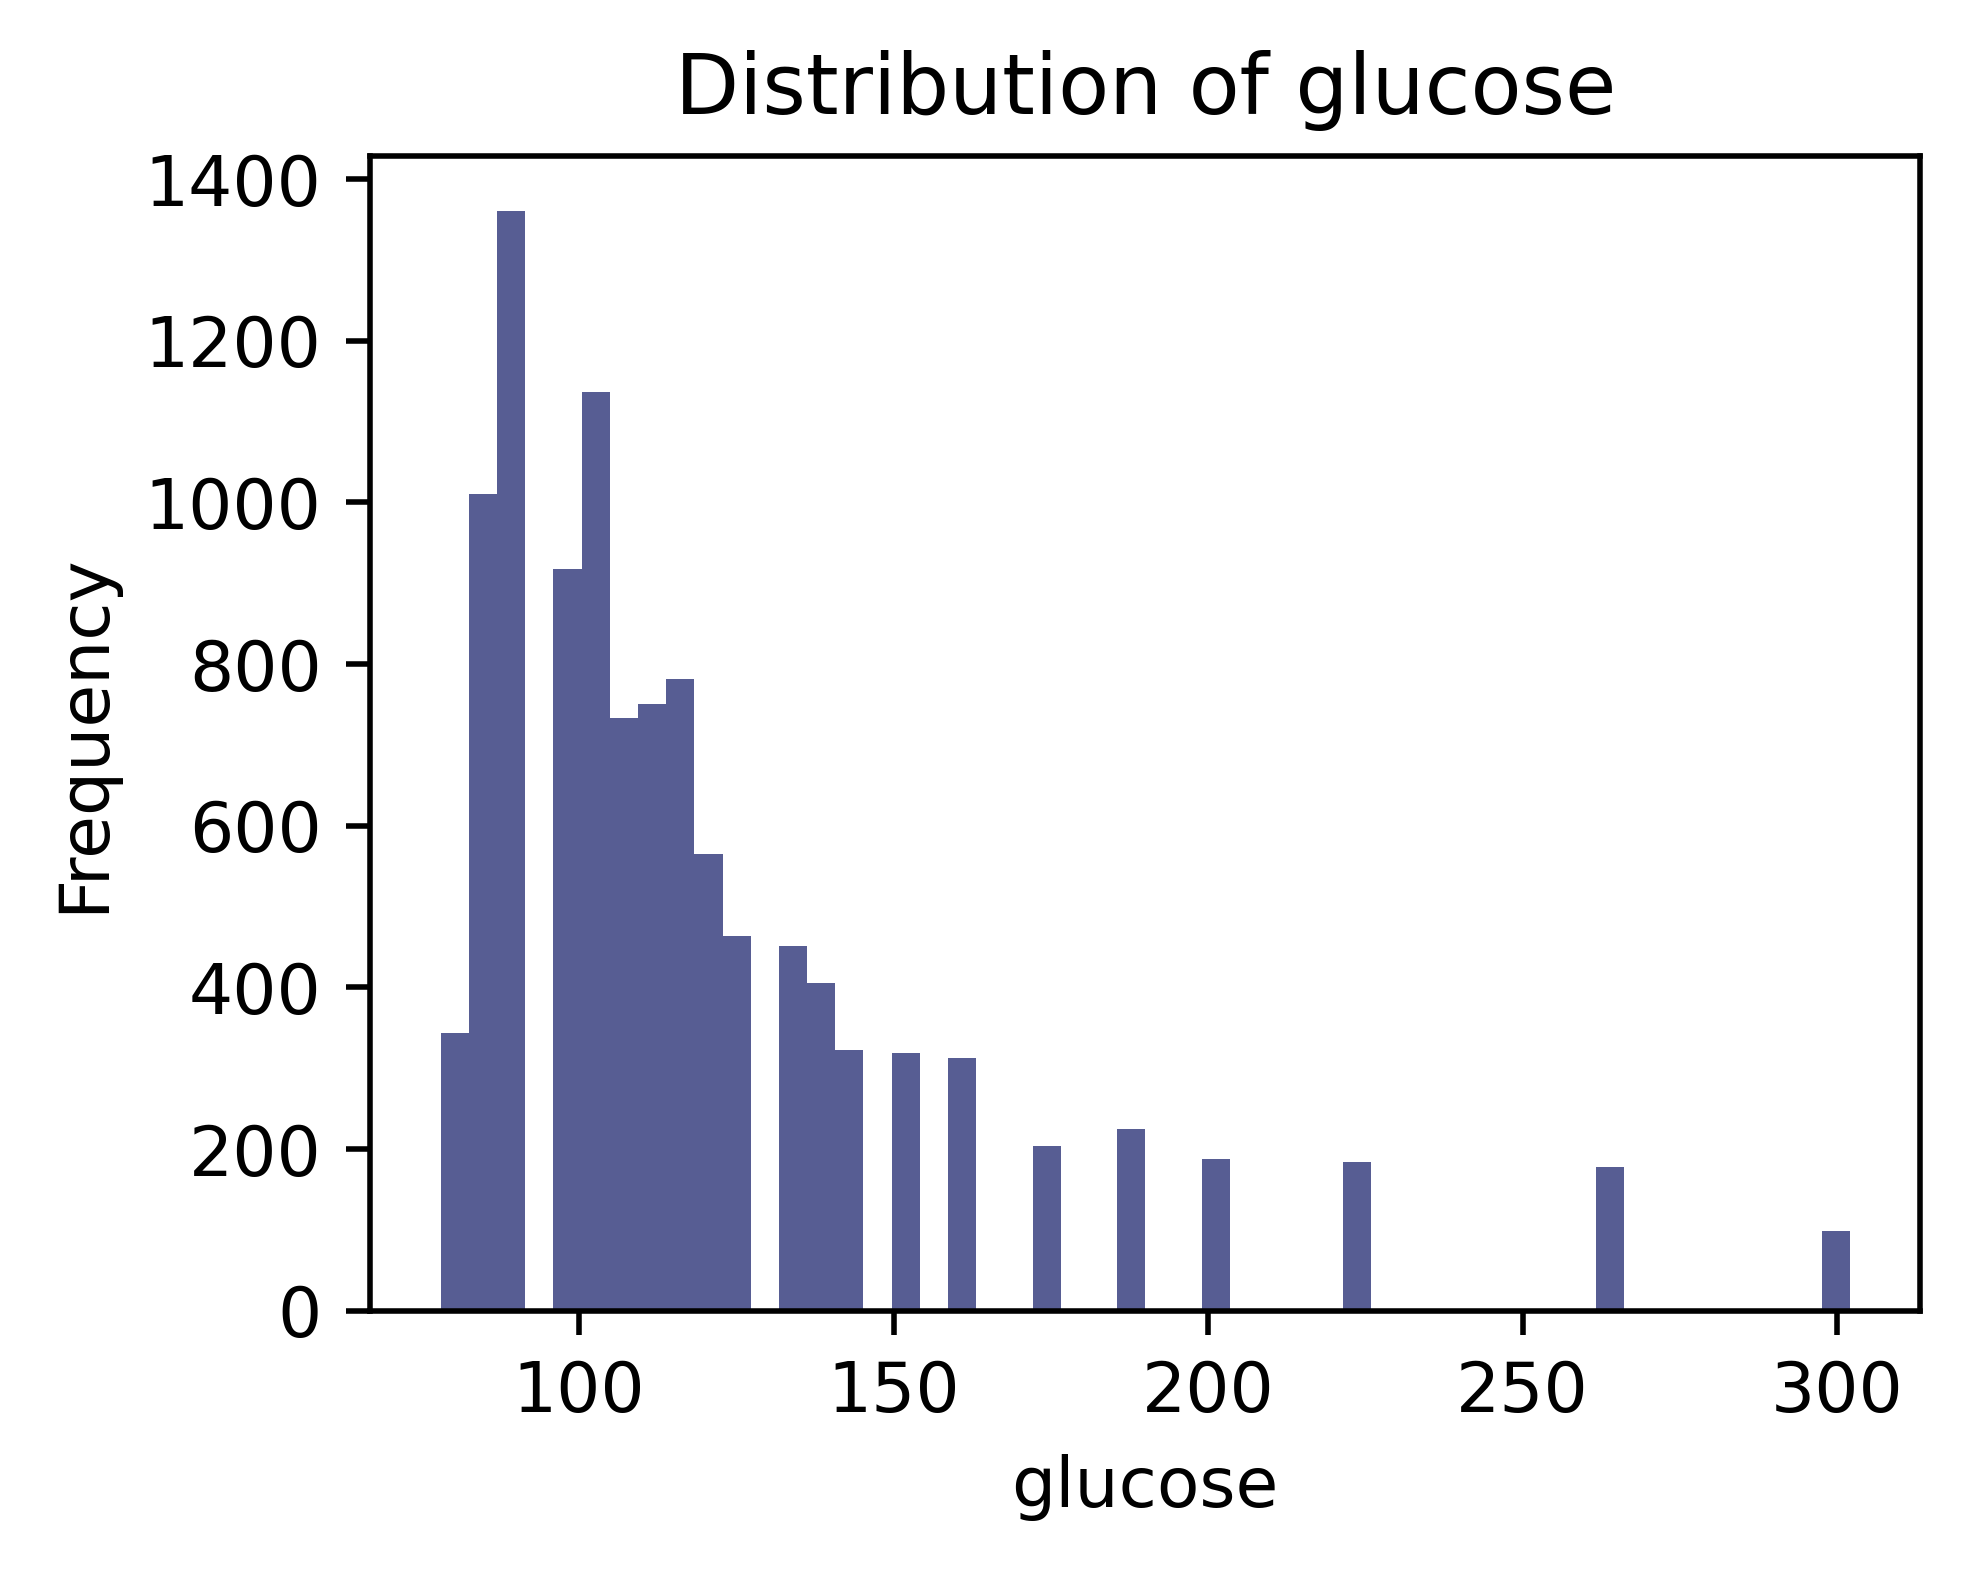

hco3: min = 16.6, max = 34.2 


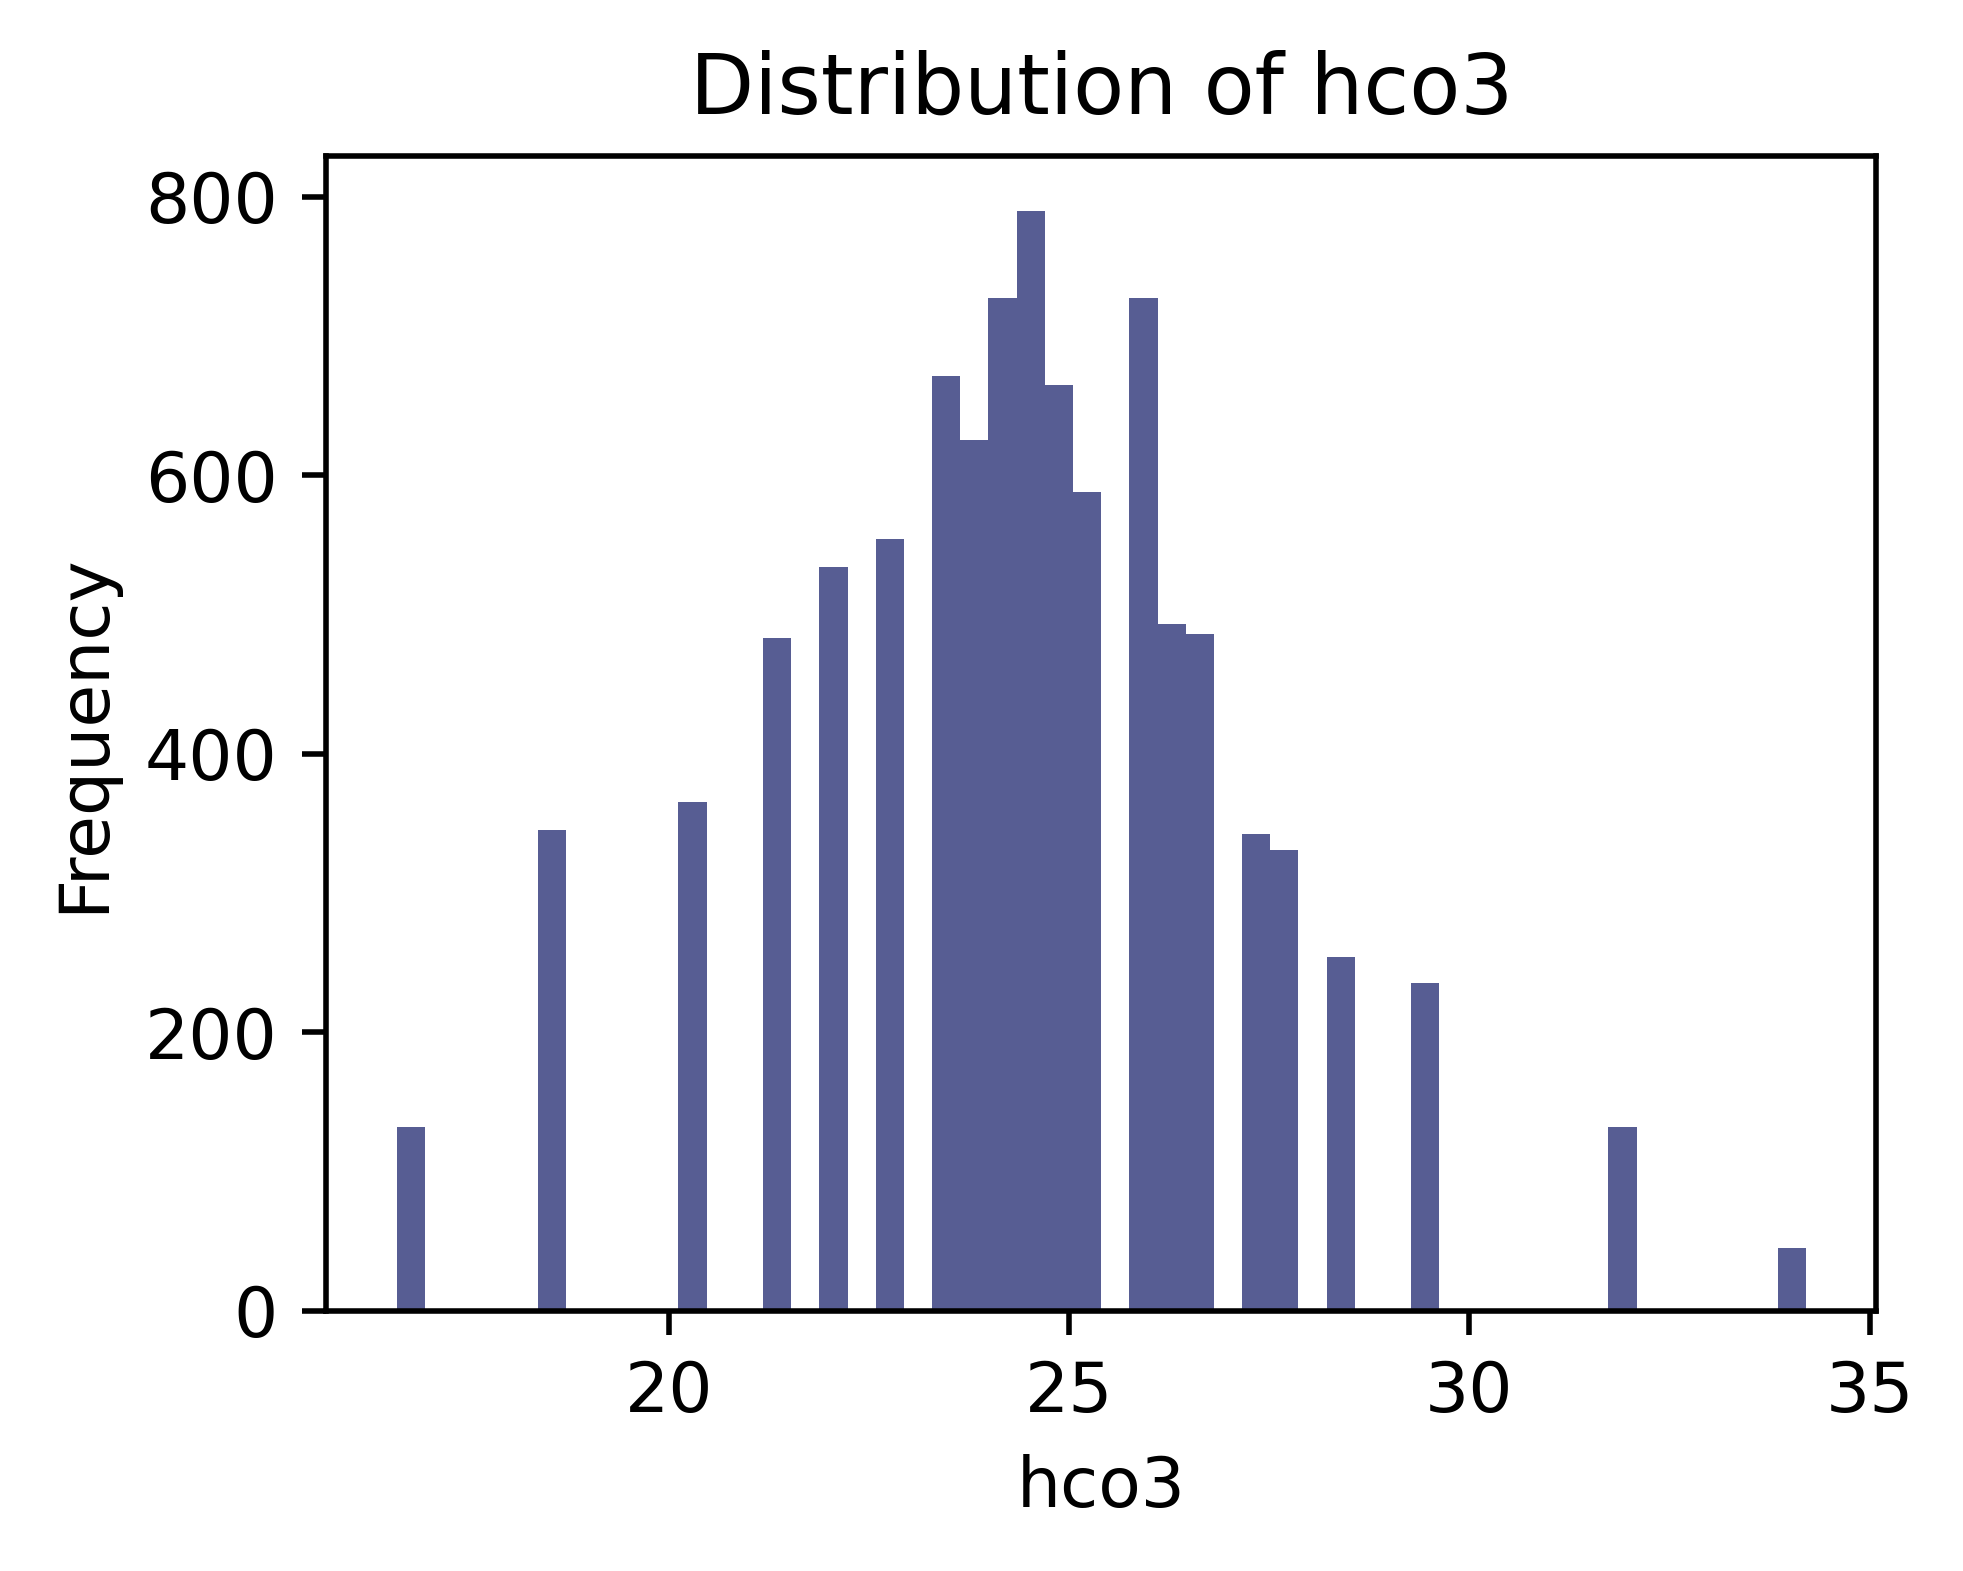

ptinr: min = 0.88, max = 2.56 


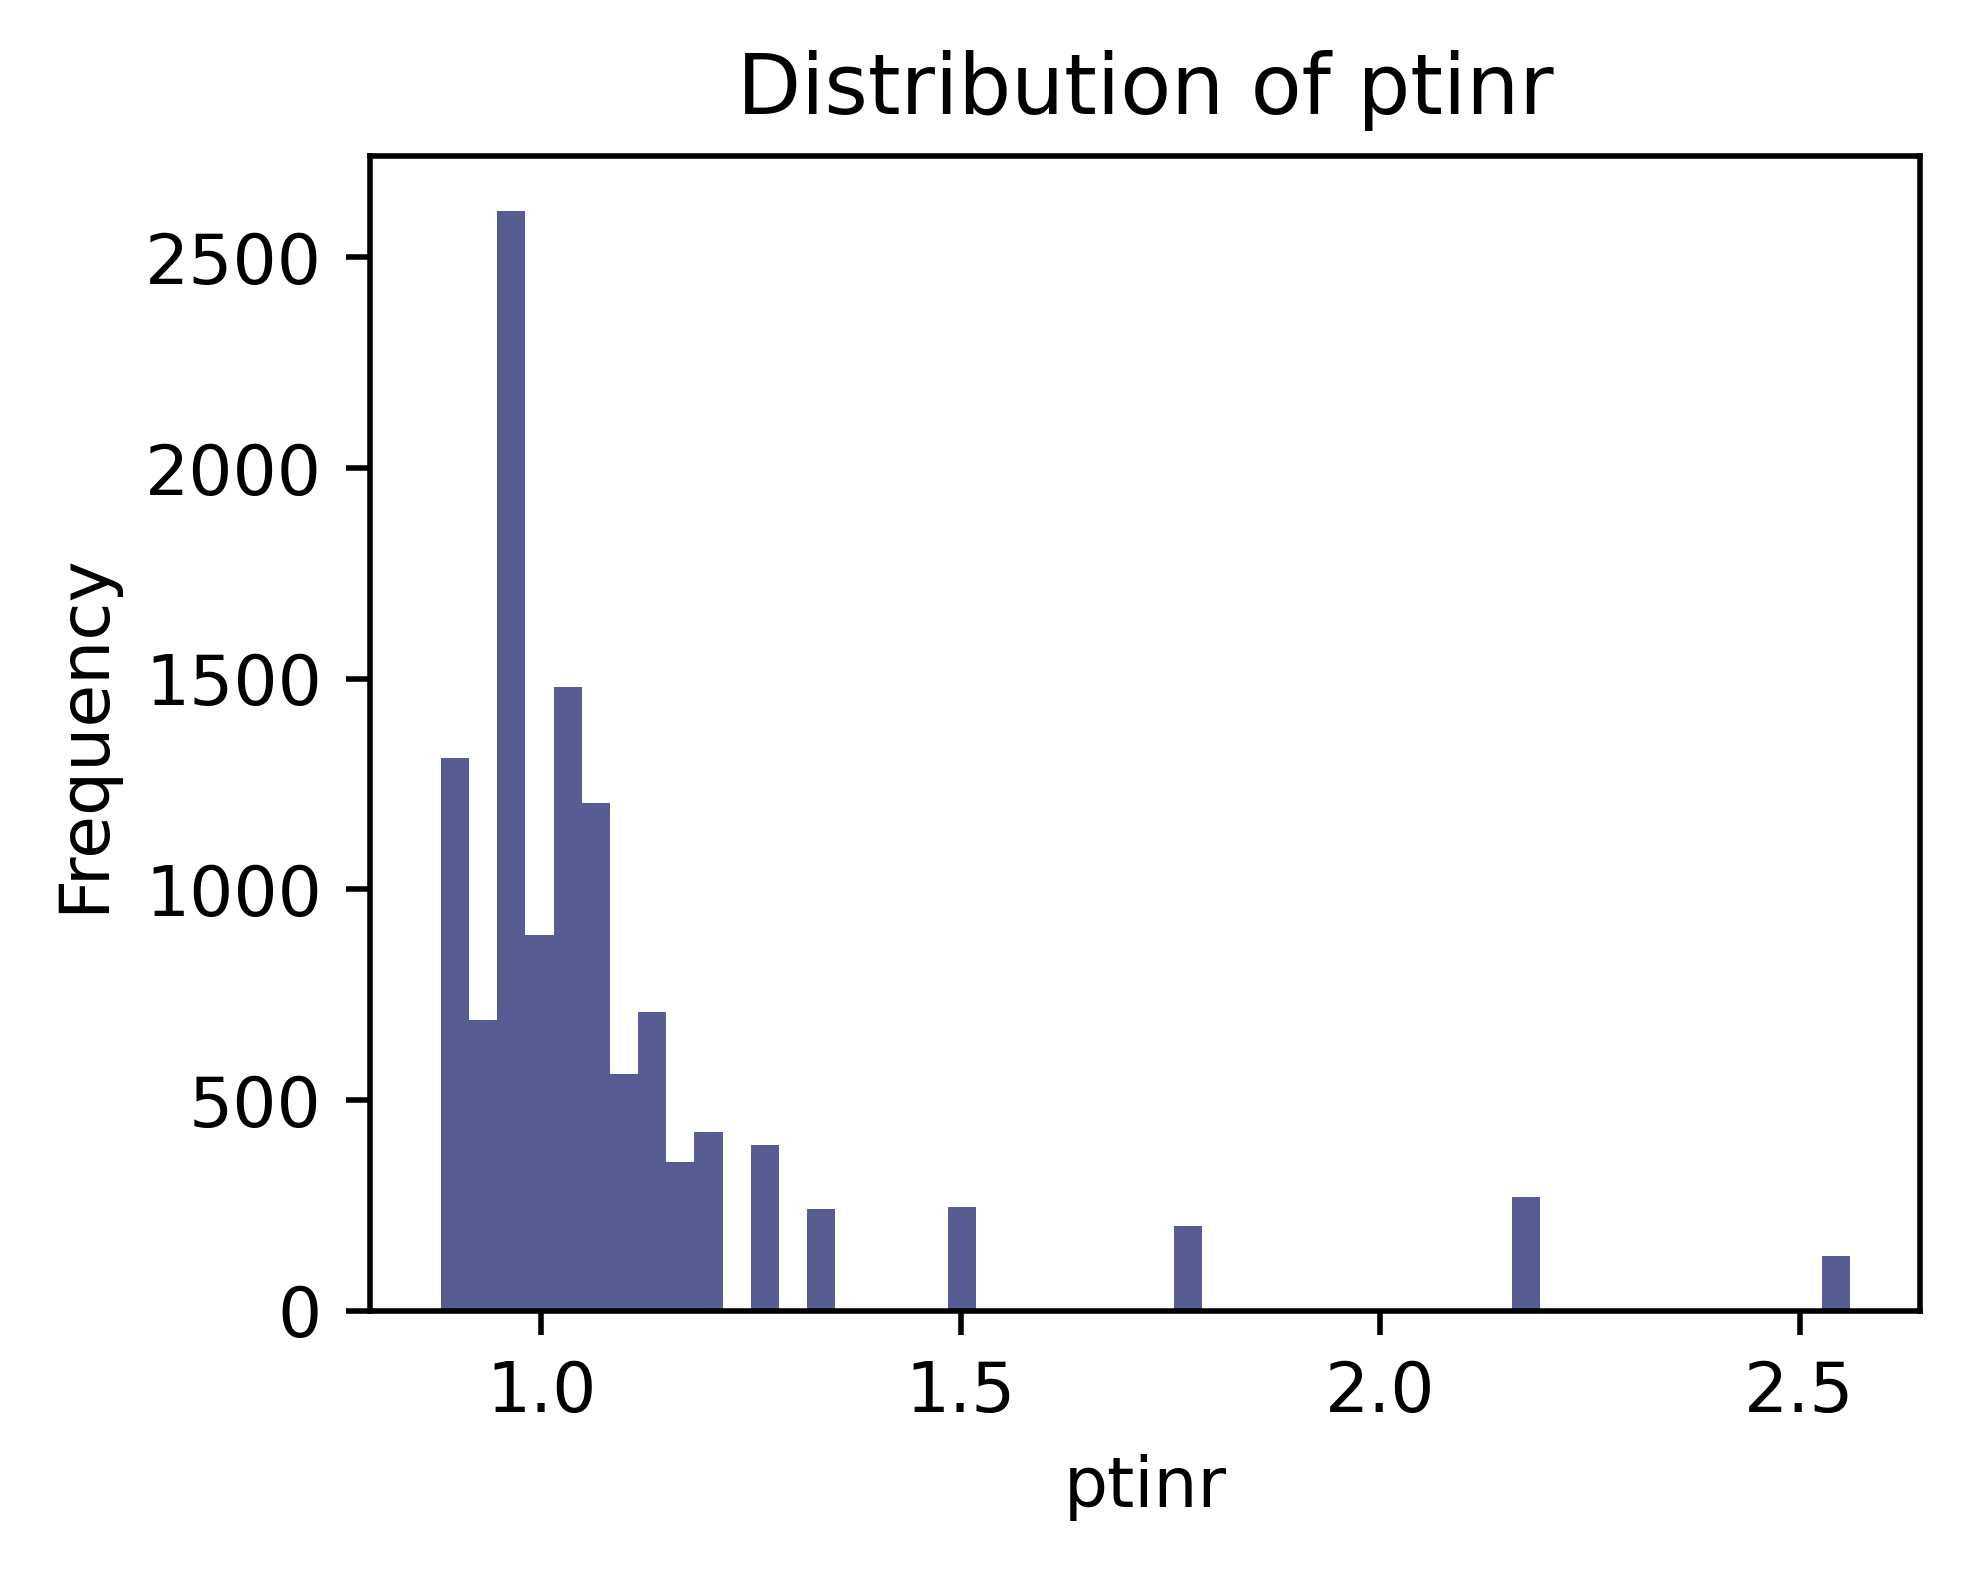

wbc: min = 2.63, max = 19.44 


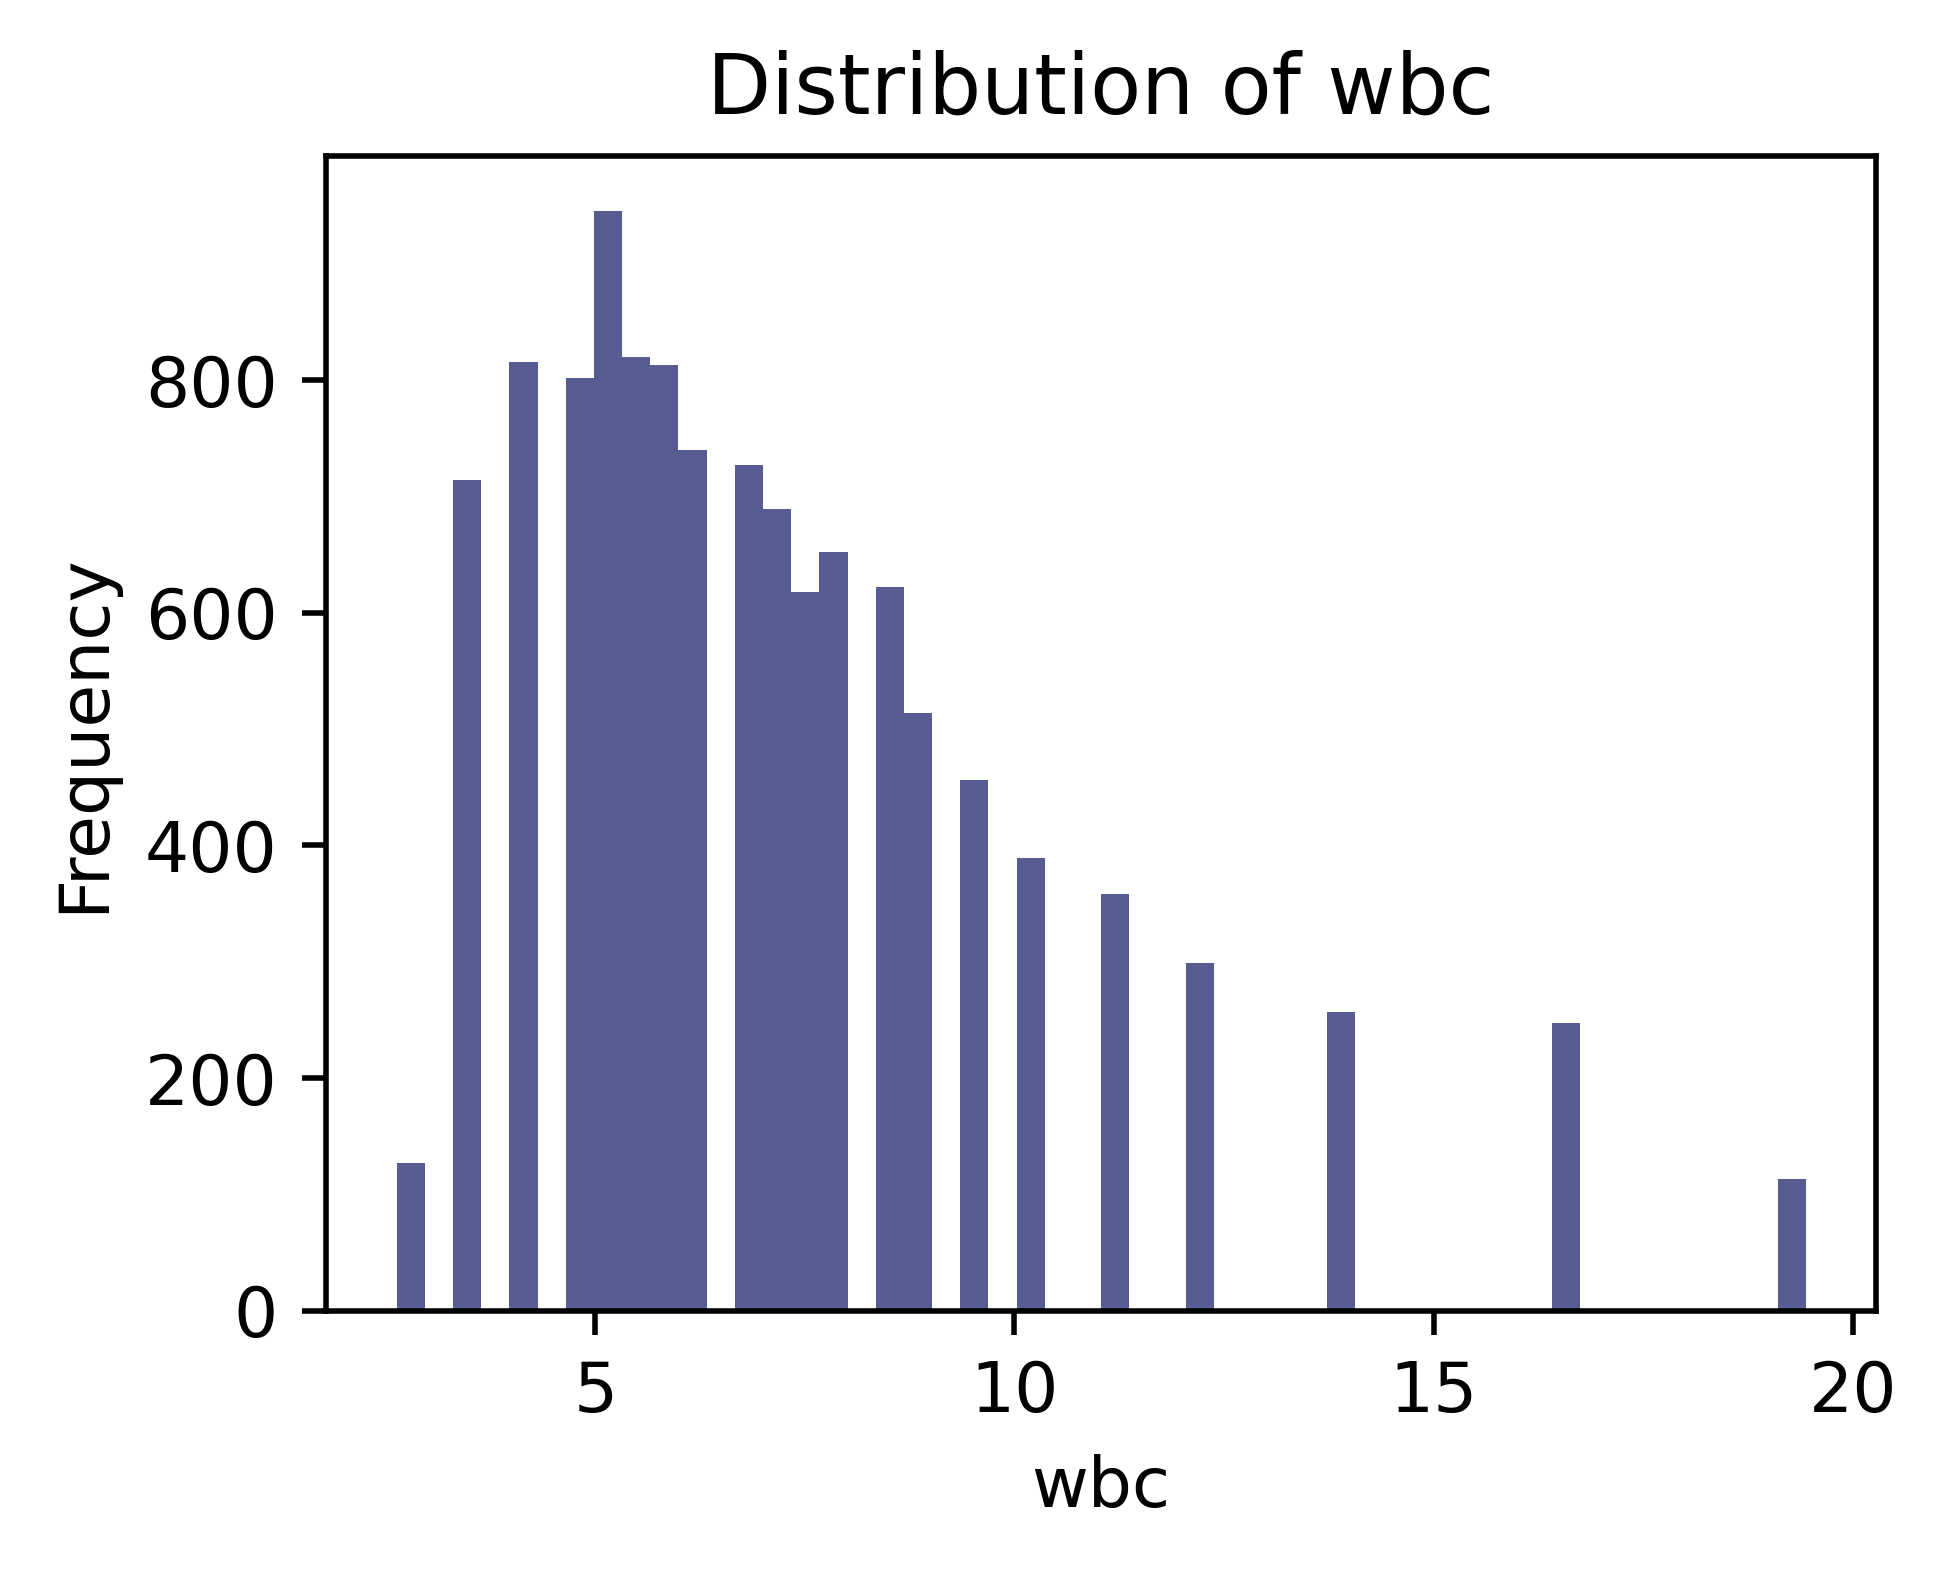

In [17]:
for feat in operations_sub_with_labs.columns[2:]:
  print(f'{feat}: min = {np.min(operations_sub_with_labs[feat])}, max = {np.max(operations_sub_with_labs[feat])} ')
  plt.figure(figsize=(4,3), dpi=500)
  plt.hist(operations_sub_with_labs[feat], bins=50, alpha=0.9, color=palette['INSPIRE'])
  plt.xlabel(feat)
  plt.ylabel('Frequency')
  plt.title(f'Distribution of {feat}')
  plt.show()

In [18]:
# Step 1: Merge operations_sub with ventilator data
vent_merge = pd.merge(
    operations_sub[['subject_id', 'anend_time']],
    ward_vitals.loc[ward_vitals['item_name'] == 'vent'],
    on='subject_id',
    how='inner'
)

# Step 2: Convert times to integers for comparison (if needed)
vent_merge['chart_time_sec'] = vent_merge['chart_time'].astype(int)
vent_merge['anend_time_sec'] = vent_merge['anend_time'].astype(int)

# Step 3: Keep only ventilator data from before end of anesthesia
pre_anend_vent = vent_merge[vent_merge['chart_time_sec'] < vent_merge['anend_time_sec']]

# Step 4: For each subject, we need to decide which ventilator value to use
# Let's take the most recent value before anesthesia end
pre_anend_vent = pre_anend_vent.sort_values(['subject_id', 'chart_time_sec'], ascending=[True, False])
selected_vent = pre_anend_vent.drop_duplicates('subject_id')

# Step 5: Create a Series with subject_id as index and value as values
vent_series = selected_vent.set_index('subject_id')['value']

# Step 6: Add the ventilator values to operations_sub_with_labs
operations_sub_with_labs['vent'] = operations_sub_with_labs['subject_id'].map(vent_series)

# Print diagnostic information
print(f"Number of patients with ventilator data: {len(selected_vent)}")
print(f"Updated DataFrame shape: {operations_sub_with_labs.shape}")

Number of patients with ventilator data: 2896
Updated DataFrame shape: (11745, 19)


In [19]:
df = operations_sub_with_labs[['age','BMI','anesthesia_duration','wbc','ptinr','glucose','creatinine','albumin','hco3','vent']]

In [20]:
non_nan_count = df['vent'].count()
non_nan_count

5931

In [21]:
df_no_nans = df[df['vent'].notna()]
df_no_nans

age        BMI  anesthesia_duration   wbc  ptinr  glucose  creatinine  \
0       70  15.570934                115.0  4.24   1.00    120.0        0.98   
8       55  20.811655                190.0  8.38   1.09     91.0        0.61   
9       70  14.693878                110.0  4.24   1.00    120.0        0.98   
11      65  21.484375                120.0  7.90   1.03    225.0        1.69   
16      70  27.755102                355.0  6.67   1.07    115.0        0.84   
...    ...        ...                  ...   ...    ...      ...         ...   
11740   40  16.528926                 65.0  8.90   1.07     96.0        0.84   
11741   75  24.444444                255.0  5.94   1.76    105.0        1.33   
11742   65  20.811655                245.0  2.63   1.76     91.0        0.84   
11743   80  22.222222                145.0  4.24   0.90    110.0        0.58   
11744   50  23.437500                100.0  5.20   1.26     91.0        0.58   

       albumin  hco3  vent  
0          4.7  22.2   1.0  
8          4.1  25.0   0.0  
9          4.7  22.2   1.0  
11         3.5  20.4   0.0  
16         4.0  25.8   0.0  
...        ...   ...   ...  
11740      4.0  24.2   0.0  
11741      4.3  25.8   0.0  
11742      3.7  24.2   0.0  
11743      4.3  27.2   0.0  
11744      4.1  27.8   0.0  

[5931 rows x 10 columns]

In [22]:
df_no_nans.to_csv('INSPIRE_8feat.csv')

In [23]:
X = df_no_nans.drop(['vent'], axis=1)
y = df_no_nans['vent']

In [24]:
# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Fit model
    model.fit(X_train, y_train)

    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    auroc = roc_auc_score(y_test, y_pred_proba)
    auprc = average_precision_score(y_test, y_pred_proba)

    # Store results
    global results  # Access the global results dictionary
    results[model_name] = {
        'model': model,
        'auroc': auroc,
        'auprc': auprc
    }

    print(f"{model_name} - AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")

    return model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Import FasterRisk if you're using it
from fasterrisk.fasterrisk import RiskScoreOptimizer, RiskScoreClassifier

# Function to convert 0/1 labels to -1/+1 for FasterRisk
def convert_labels_for_fasterrisk(y):
    y_np = y.values if hasattr(y, 'values') else np.array(y)
    return 2 * y_np - 1

In [25]:
# Check data shape and handle missing values
print("Original data shape:", X.shape)
print("Number of missing values per column:")
print(X.isna().sum())

# Imputation (using KNN)
knn_imputer = KNNImputer(n_neighbors=5)
X_imputed_knn = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)
X = X_imputed_knn
print("\nAfter imputation - remaining missing values:", X.isna().sum().sum())

# Scale features for better model performance
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X = X_scaled  # Use scaled features

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary to store results
results = {}

# Create plots directory if it doesn't exist
import os
plots_dir = 'plots_dir'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# 1. Decision Tree
dt_model = evaluate_model(
    DecisionTreeClassifier(max_depth=4, random_state=42),
    X_train, X_test, y_train, y_test,
    "Decision Tree"
)

# 2. Random Forest
rf_model = evaluate_model(
    RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42),
    X_train, X_test, y_train, y_test,
    "Random Forest"
)

# 3. Logistic Regression
lr_model = evaluate_model(
    LogisticRegression(max_iter=1000, C=1.0, random_state=42),
    X_train, X_test, y_train, y_test,
    "Logistic Regression"
)

# 4. Gradient Boosting
gb_model = evaluate_model(
    GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
    X_train, X_test, y_train, y_test,
    "Gradient Boosting"
)

Original data shape: (5931, 9)
Number of missing values per column:
age                      0
BMI                     18
anesthesia_duration      0
wbc                      3
ptinr                    1
glucose                125
creatinine               1
albumin                  1
hco3                   163
dtype: int64

After imputation - remaining missing values: 0
Decision Tree - AUROC: 0.6264, AUPRC: 0.2628
Random Forest - AUROC: 0.7281, AUPRC: 0.3723
Logistic Regression - AUROC: 0.6683, AUPRC: 0.2986
Gradient Boosting - AUROC: 0.7518, AUPRC: 0.4266


In [26]:
# ----- FasterRisk Implementation -----
# Convert labels
y_train_fr = convert_labels_for_fasterrisk(y_train)
y_test_fr = convert_labels_for_fasterrisk(y_test)

# Define parent_size
parent_size = 10  # Beam search parameter

# Original FasterRisk with 5 features
print("\n----- Training FasterRisk Model (Original - 5 features) -----")
original_sparsity = 5  # Number of features to use in risk score

risk_score_optimizer = RiskScoreOptimizer(X=X_train.values,
                                         y=y_train_fr,
                                         k=original_sparsity,
                                         parent_size=parent_size)


start_time = time.time()
risk_score_optimizer.optimize()
end_time = time.time()
print(f"FasterRisk optimization completed in {end_time - start_time:.2f} seconds")

# Get the optimized models
multipliers, intercepts, coefficients = risk_score_optimizer.get_models()

# Use the first model (best performing)
model_index = 0
multiplier = multipliers[model_index]
intercept = intercepts[model_index]
coefficient = coefficients[model_index]

# Create FasterRisk classifier
risk_classifier = RiskScoreClassifier(multiplier=multiplier,
                                     intercept=intercept,
                                     coefficients=coefficient,
                                     featureNames=list(X.columns),
                                     X_train=X_train.values)

# Print the model card
print("\nFasterRisk Model Card:")
risk_classifier.print_model_card()

# Create a wrapper for sklearn-compatible API
class FasterRiskWrapper:
    def __init__(self, risk_classifier):
        self.risk_classifier = risk_classifier

    def predict(self, X):
        return self.risk_classifier.predict(X=X)

    def predict_proba(self, X):
        # Get probabilities using predict_prob
        probs = self.risk_classifier.predict_prob(X=X)
        # Return in sklearn-like format
        return np.vstack((1 - probs, probs)).T

# Wrap the classifier and evaluate
risk_classifier_wrapped = FasterRiskWrapper(risk_classifier)

# Evaluate FasterRisk
y_test_prob_fr = risk_classifier.predict_prob(X=X_test.values)
test_auroc = roc_auc_score(y_test, y_test_prob_fr)
test_auprc = average_precision_score(y_test, y_test_prob_fr)

# Get accuracy and AUC directly from the model
model_acc_test, model_auc_test = risk_classifier.get_acc_and_auc(X=X_test.values, y=y_test_fr)

# Add to results
results["FasterRisk"] = {
    'model': risk_classifier_wrapped,
    'auroc': test_auroc,
    'auprc': test_auprc,
    'features_used': sum(np.array(coefficient) != 0),
    'coefficients': coefficient
}

print(f"FasterRisk - AUROC: {test_auroc:.4f}, AUPRC: {test_auprc:.4f}")


----- Training FasterRisk Model (Original - 5 features) -----
FasterRisk optimization completed in 1.31 seconds

FasterRisk Model Card:
The Risk Score is:
1.                 BMI     -3 point(s) |   ...
2. anesthesia_duration      1 point(s) | + ...
3.                 wbc      2 point(s) | + ...
4.             glucose      1 point(s) | + ...
5.             albumin     -2 point(s) | + ...
                                 SCORE | =    
SCORE |  -5.0  |  -4.0  |  -3.0  |  -2.0  |  -1.0  |
RISK  |   9.1% |  10.2% |  11.3% |  12.6% |  14.0% |
SCORE |   0.0  |   1.0  |   2.0  |   3.0  |   4.0  |
RISK  |  15.5% |  17.2% |  19.0% |  20.9% |  23.0% |
FasterRisk - AUROC: 0.6648, AUPRC: 0.2926


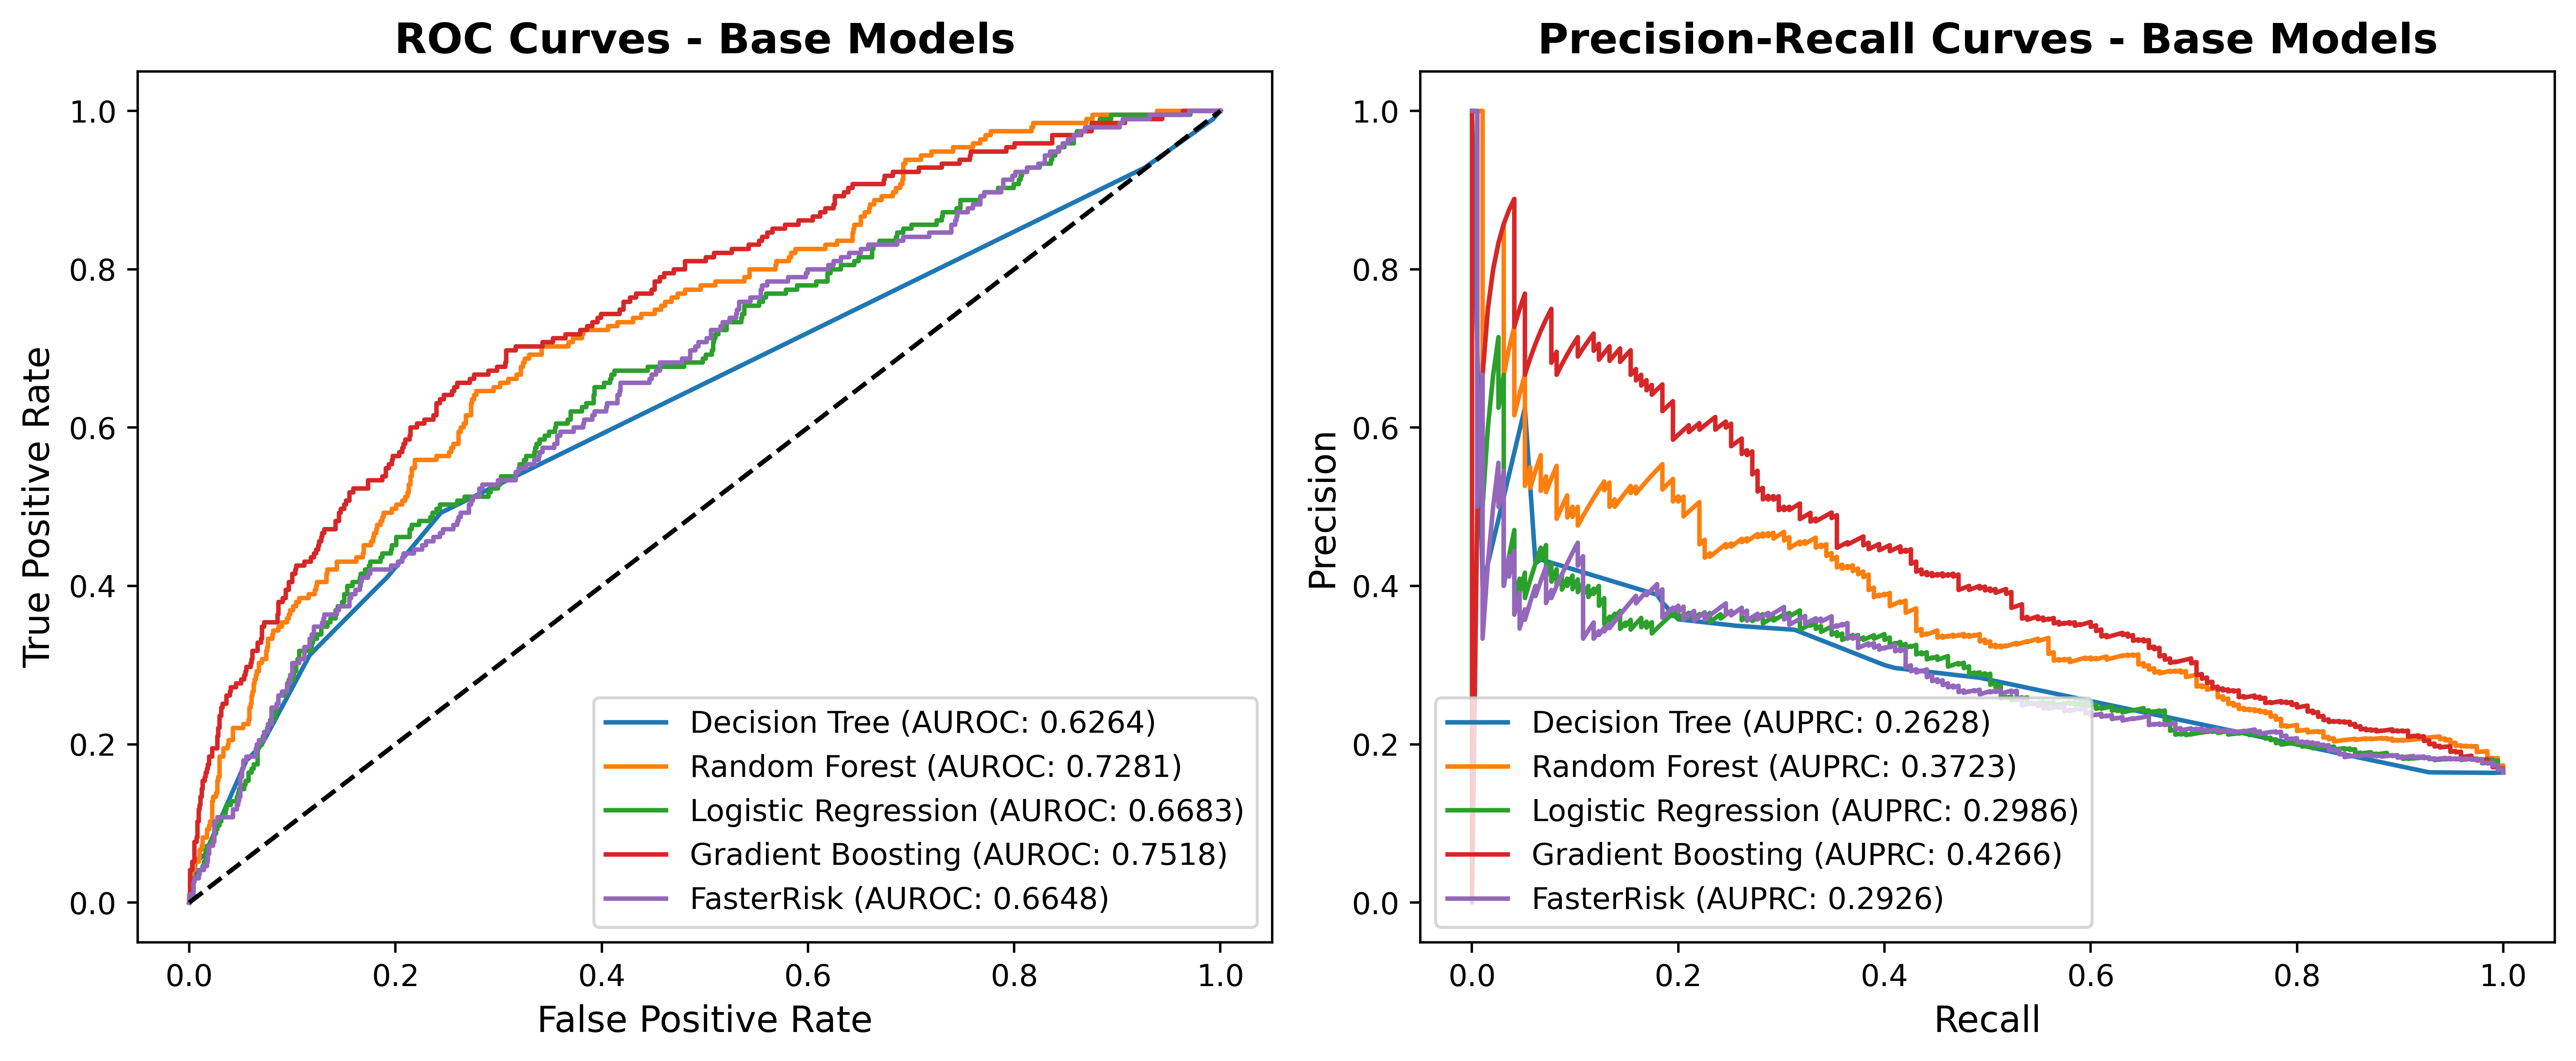


----- Improved Decision Tree Visualization -----
Enhanced decision tree visualization saved to plots_dir/decision_tree_improved.png


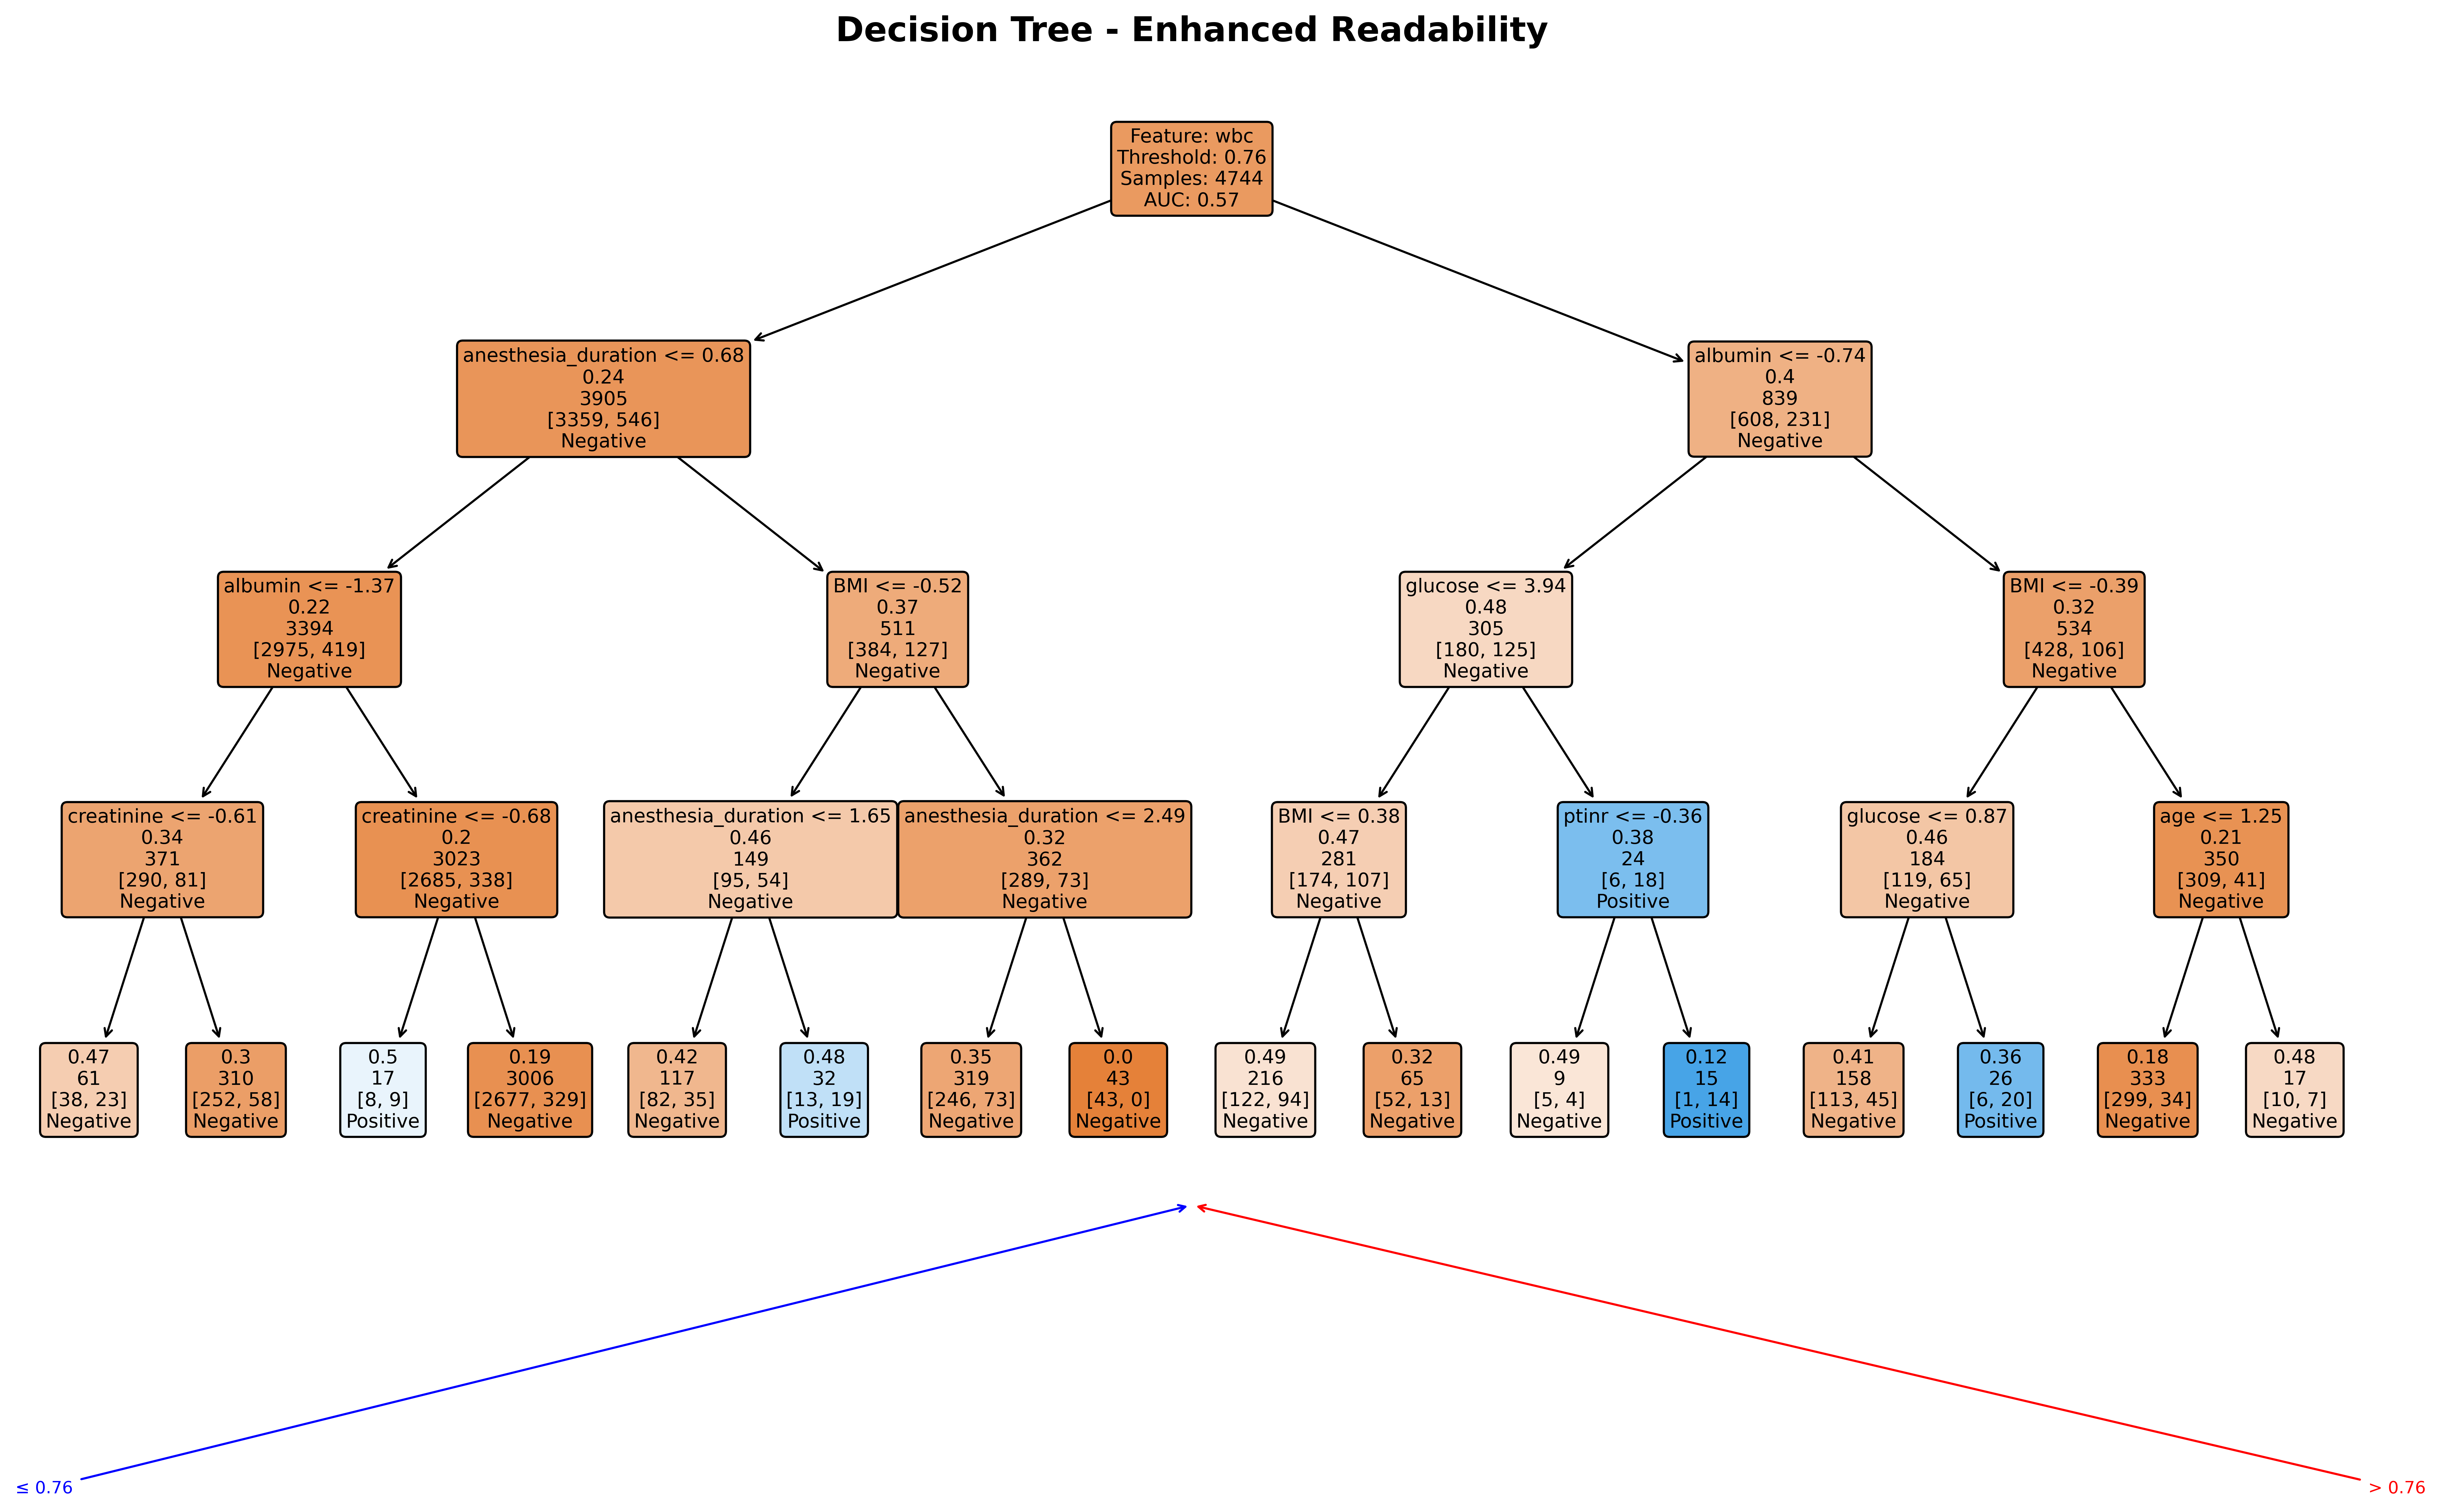

Improved decision tree visualization completed successfully


In [27]:
# 1. Modified plot for main model comparison - only showing base models with all features
plt.figure(figsize=(12, 5), dpi=500)

plt.subplot(1, 2, 1)
for model_name in results:  # Only include the original models, not the subset versions
    if model_name == "FasterRisk":
        y_pred_proba = results[model_name]['model'].predict_proba(X_test.values)[:, 1]
    else:
        y_pred_proba = results[model_name]['model'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUROC: {results[model_name]['auroc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Base Models', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)

# Plot PR curves
plt.subplot(1, 2, 2)
for model_name in results:  # Only include the original models
    if model_name == "FasterRisk":
        y_pred_proba = results[model_name]['model'].predict_proba(X_test.values)[:, 1]
    else:
        y_pred_proba = results[model_name]['model'].predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f"{model_name} (AUPRC: {results[model_name]['auprc']:.4f})")

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Base Models', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'base_model_comparison_curves.png'))
plt.show()

# 2. Improved decision tree visualization with better readability
def plot_improved_decision_tree(tree_model, feature_names, class_names, X, y, filename=None):
    """Plot a more readable decision tree with branch text and no Gini index"""
    from sklearn import tree as sktree
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Prepare figure with larger size
    plt.figure(figsize=(16, 10), dpi=500)
    
    # Get the tree text representation to parse
    tree_text = sktree.export_text(tree_model, feature_names=list(feature_names))
    
    # Convert data to numpy if it's DataFrame
    X_array = X.values if hasattr(X, 'values') else X
    y_array = y.values if hasattr(y, 'values') else y
    
    # Function to draw the decision tree
    def create_tree_plot(ax):
        # Use sklearn's plot_tree with customized parameters
        sktree.plot_tree(
            tree_model,
            feature_names=feature_names,
            class_names=class_names,
            filled=True,
            rounded=True,
            fontsize=9,
            ax=ax,
            precision=2,
            label='none'  # Prevents automatic labeling
        )
        
        # Customize the text on each node
        for i, (text_obj, bbox_obj) in enumerate(zip(
                ax.texts, [obj for obj in ax.get_children() if isinstance(obj, plt.Rectangle)])):
            # Get node position
            x, y = bbox_obj.get_xy()
            width = bbox_obj.get_width()
            height = bbox_obj.get_height()
            
            # Extract node info from the tree structure
            tree = tree_model.tree_
            node_id = i
            
            # Check if it's a leaf node
            is_leaf = tree.children_left[node_id] == -1
            
            if is_leaf:
                # Get class distribution
                value = tree.value[node_id][0]
                total_samples = np.sum(value)
                class_probs = value / total_samples
                majority_class = np.argmax(class_probs)
                confidence = class_probs[majority_class]
                
                # Calculate accuracy on this node
                samples_in_leaf = np.where(tree_model.apply(X_array) == node_id)[0]
                if len(samples_in_leaf) > 0:
                    node_y = y_array[samples_in_leaf]
                    accuracy = np.mean(node_y == majority_class)
                    accuracy_text = f"Accuracy: {accuracy:.2f}"
                else:
                    accuracy_text = ""
                
                class_label = class_names[majority_class] if majority_class < len(class_names) else f"Class {majority_class}"
                node_text = f"Class: {class_label}\nSamples: {total_samples}\nConfidence: {confidence:.2f}\n{accuracy_text}"
            else:
                # Decision node
                feature = tree.feature[node_id]
                threshold = tree.threshold[node_id]
                feature_name = feature_names[feature] if feature < len(feature_names) else f"feature {feature}"
                samples = tree.n_node_samples[node_id]
                
                # Add decision labels to the branches
                # Left branch - less than or equal to
                left_child = tree.children_left[node_id]
                left_x = bbox_obj.get_x() - width/4
                left_y = bbox_obj.get_y() - height/2
                if left_child != -1:
                    ax.annotate(f"≤ {threshold:.2f}", 
                                xy=(bbox_obj.get_x() + width/2, bbox_obj.get_y()),
                                xytext=(left_x + width/4, left_y + height/4),
                                fontsize=8, color='blue',
                                arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='blue'))
                
                # Right branch - greater than
                right_child = tree.children_right[node_id]
                right_x = bbox_obj.get_x() + width + width/4
                right_y = bbox_obj.get_y() - height/2
                if right_child != -1:
                    ax.annotate(f"> {threshold:.2f}", 
                                xy=(bbox_obj.get_x() + width/2, bbox_obj.get_y()),
                                xytext=(right_x - width/4, right_y + height/4),
                                fontsize=8, color='red',
                                arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='red'))
                
                # Calculate AUC for this split
                try:
                    from sklearn.metrics import roc_auc_score
                    
                    # Get predictions based on this feature split
                    y_pred = (X_array[:, feature] > threshold).astype(int)
                    split_auc = roc_auc_score(y_array, y_pred)
                    if split_auc < 0.5:
                        split_auc = 1 - split_auc  # Invert if needed
                        
                    auc_text = f"AUC: {split_auc:.2f}"
                except:
                    auc_text = ""
                
                node_text = f"Feature: {feature_name}\nThreshold: {threshold:.2f}\nSamples: {samples}\n{auc_text}"
            
            # Replace the node text
            text_obj.set_text(node_text)
    
    # Create the tree plot
    ax = plt.gca()
    create_tree_plot(ax)
    
    # Add title and adjust layout
    plt.title('Decision Tree - Enhanced Readability', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save if filename provided
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        print(f"Enhanced decision tree visualization saved to {filename}")
    
    plt.show()

# Create the improved visualization
print("\n----- Improved Decision Tree Visualization -----")
plot_improved_decision_tree(
    dt_model,
    X.columns,
    ['Negative', 'Positive'],
    X_train,
    y_train,
    os.path.join(plots_dir, 'decision_tree_improved.png')
)
print("Improved decision tree visualization completed successfully")

In [28]:
# Fixed decision tree visualization that ensures text is visible
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import plot_tree
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def create_fixed_tree_viz(tree_model, X, y, feature_names, class_names, filename=None, max_depth=None):
    """
    Create a decision tree visualization with explicit text labels
    that will definitely be visible in the output.
    
    Parameters:
    -----------
    tree_model : DecisionTreeClassifier
        The trained decision tree model
    X : DataFrame or array
        Feature matrix
    y : Series or array
        Target vector (0/1)
    feature_names : list
        Names of features
    class_names : list
        Names of classes ['Negative', 'Positive']
    filename : str, optional
        Path to save visualization
    max_depth : int, optional
        Maximum depth to display
    """
    # Create a pruned version of the tree if max_depth is specified
    if max_depth is not None:
        pruned_model = DecisionTreeClassifier(max_depth=max_depth)
        pruned_model.fit(X, y)
        tree_to_plot = pruned_model
    else:
        tree_to_plot = tree_model
    
    # Set up a large figure
    plt.figure(figsize=(18,8), dpi=500)
    
    # Calculate AUCs for each node (pre-compute before plotting)
    tree = tree_to_plot.tree_
    node_auc = {}
    
    # Get path features for each node for AUC calculation
    node_path_features = {}
    
    for i in range(tree.node_count):
        # Get decision path to this node
        path_features = set()
        node_id = i
        
        # Find features on path from root to this node
        while node_id != 0:
            # Check if we already found parent
            parent_found = False
            for j in range(tree.node_count):
                if tree.children_left[j] == node_id or tree.children_right[j] == node_id:
                    # Add current feature to path
                    if tree.feature[j] >= 0:  # Skip -1 (no feature)
                        path_features.add(tree.feature[j])
                    node_id = j
                    parent_found = True
                    break
            
            if not parent_found:
                break
        
        # Add current node's feature if it's a decision node
        if tree.feature[i] >= 0:
            path_features.add(tree.feature[i])
            
        # Store path features for this node
        node_path_features[i] = list(path_features)
        
        # Calculate AUC for this node based on features in its path
        features = list(path_features)
        
        if features and len(features) > 0:
            # Extract samples that reach this node (based on tree structure)
            node_samples_mask = tree_to_plot.decision_path(X).toarray()[:, i] > 0
            node_X = X[node_samples_mask]
            node_y = y[node_samples_mask]
            
            # Only calculate AUC if we have enough samples and both classes
            if len(node_y) >= 5 and len(np.unique(node_y)) > 1:
                # Use the features encountered on the path to this node
                # Need to convert feature indices to column indices if X is DataFrame
                if hasattr(X, 'iloc'):
                    X_subset = node_X.iloc[:, features]
                else:
                    X_subset = node_X[:, features]
                
                # Create and evaluate model
                temp_model = DecisionTreeClassifier(max_depth=len(features))
                
                try:
                    # Use cross-validation for better AUC estimate
                    scores = cross_val_score(
                        temp_model, X_subset, node_y, 
                        cv=min(5, len(node_y) // 2), 
                        scoring='roc_auc'
                    )
                    node_auc[i] = round(np.mean(scores), 2)
                except:
                    # Fallback if cross-validation fails
                    temp_model.fit(X_subset, node_y)
                    if hasattr(temp_model, "predict_proba"):
                        probs = temp_model.predict_proba(X_subset)[:, 1]
                        node_auc[i] = round(roc_auc_score(node_y, probs), 2)
                    else:
                        node_auc[i] = 0.75  # Default if we can't calculate
            else:
                # For small/pure nodes, use node purity as proxy for AUC
                if len(node_y) > 0:
                    purity = max(np.mean(node_y), 1 - np.mean(node_y))
                    # Scale 0.5-1.0: more pure nodes have higher AUC
                    node_auc[i] = round(0.5 + 0.5 * (2 * purity - 1), 2)
                else:
                    node_auc[i] = 0.5
        else:
            # Root node with no features yet
            node_auc[i] = 0.5
    
    # Plot the tree with explicit text
    ax = plt.gca()
    tree_plot = plot_tree(
        tree_to_plot,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        fontsize=12,  # Larger fontsize
        precision=2,
        ax=ax,
        impurity=False,
        proportion=False,
        node_ids=True
    )
    
    # Go through all the text elements and replace with our custom format
    for i, text in enumerate(ax.texts):
        # Extract node id from text
        text_content = text.get_text()
        
        # Check if this is a node text (contains "node #")
        if "node #" in text_content.lower():
            # Extract node ID
            try:
                node_id_str = text_content.split("#")[1].split("\n")[0].strip()
                node_id = int(node_id_str)
                
                # Extract samples info
                samples_info = ""
                if "samples =" in text_content.lower():
                    samples_part = text_content.split("samples =")[1].split("\n")[0].strip()
                    samples_count = int(samples_part)
                    samples_info = f"Samples: {samples_count}"
                
                # Determine if leaf node
                is_leaf = "class =" in text_content.lower()
                predicted_class = ""
                
                if is_leaf:
                    # Extract predicted class
                    class_part = text_content.split("class =")[1].strip()
                    class_idx = 0 if "0" in class_part else 1
                    predicted_class = f"Class: {class_names[class_idx]}"
                
                # Create new node text
                auc_value = node_auc.get(node_id, 0.5)
                if is_leaf:
                    new_text = f"Node #{node_id}\n{samples_info}\nAUC: {auc_value}\n{predicted_class}"
                else:
                    new_text = f"Node #{node_id}\n{samples_info}\nAUC: {auc_value}"
                
                # Update text
                text.set_text(new_text)
                
                # Make text more visible with white background
                text.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.5'))
                
                # Make text larger and bold
                text.set_fontsize(12)
                text.set_fontweight('bold')
                
            except Exception as e:
                # If parsing fails, keep original text
                pass
    
    # Add feature/threshold annotations on the branches
    for i in range(tree.node_count):
        if tree.children_left[i] != -1:  # Not a leaf node
            feature_idx = tree.feature[i]
            threshold = tree.threshold[i]
            
            if feature_idx >= 0 and feature_idx < len(feature_names):
                feature_name = feature_names[feature_idx]
                
                # Get positions of this node and its children
                # We need to find the corresponding tree plot elements
                
                # Get the annotation for current node
                current_node_text = None
                left_child_text = None
                right_child_text = None
                
                for text in ax.texts:
                    text_content = text.get_text()
                    if f"Node #{i}\n" in text_content:
                        current_node_text = text
                    elif f"Node #{tree.children_left[i]}\n" in text_content:
                        left_child_text = text
                    elif f"Node #{tree.children_right[i]}\n" in text_content:
                        right_child_text = text
                
                # Add branch annotations if we found the text objects
                if current_node_text and left_child_text:
                    # Calculate midpoint for left branch annotation
                    current_pos = current_node_text.get_position()
                    left_pos = left_child_text.get_position()
                    
                    mid_x = (current_pos[0] + left_pos[0]) / 2
                    mid_y = (current_pos[1] + left_pos[1]) / 2
                    
                    # Add left branch annotation (≤)
                    left_annotation = plt.text(
                        mid_x, mid_y,
                        f"{feature_name} ≤ {threshold:.2f}",
                        ha='center', va='center',
                        fontsize=11,
                        color='blue',
                        fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.9, edgecolor='blue', boxstyle='round')
                    )
                
                if current_node_text and right_child_text:
                    # Calculate midpoint for right branch annotation
                    current_pos = current_node_text.get_position()
                    right_pos = right_child_text.get_position()
                    
                    mid_x = (current_pos[0] + right_pos[0]) / 2
                    mid_y = (current_pos[1] + right_pos[1]) / 2
                    
                    # Add right branch annotation (>)
                    right_annotation = plt.text(
                        mid_x, mid_y,
                        f"{feature_name} > {threshold:.2f}",
                        ha='center', va='center',
                        fontsize=11,
                        color='red',
                        fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.9, edgecolor='red', boxstyle='round')
                    )
    
    # Add a descriptive title
    plt.title("Decision Tree with AUC, Sample Counts, and Class Predictions", fontsize=16, fontweight='bold')
    
    # Add a legend
    import matplotlib.patches as mpatches
    legend_handles = [
        mpatches.Patch(color='lightblue', label='Negative Prediction'),
        mpatches.Patch(color='lightcoral', label='Positive Prediction'),
        mpatches.Patch(color='white', label=''),
        mpatches.Patch(color='white', label='Node info: Sample count, AUC value'),
        mpatches.Patch(color='white', label='Branches: Feature name & threshold'),
        mpatches.Patch(color='white', label='Leaf nodes show final Class prediction')
    ]
    plt.legend(handles=legend_handles, loc='upper right', fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if filename provided
    if filename:
        plt.savefig(filename, bbox_inches='tight', dpi=500)
        print(f"Decision tree visualization saved to: {filename}")
    
    plt.show()
    
    return tree_to_plot  # Return the plotted tree model

# Example usage:
# create_fixed_tree_viz(
#     dt_model,
#     X.values,  # Convert to numpy array if DataFrame
#     y.values if hasattr(y, 'values') else y,  # Convert to numpy array if Series
#     list(X.columns) if hasattr(X, 'columns') else [f"Feature {i}" for i in range(X.shape[1])],
#     ['Negative', 'Positive'],
#     'fixed_decision_tree.png',
#     max_depth=3  # Optional: limit depth
# )

Decision tree visualization saved to: enhanced_decision_tree.png


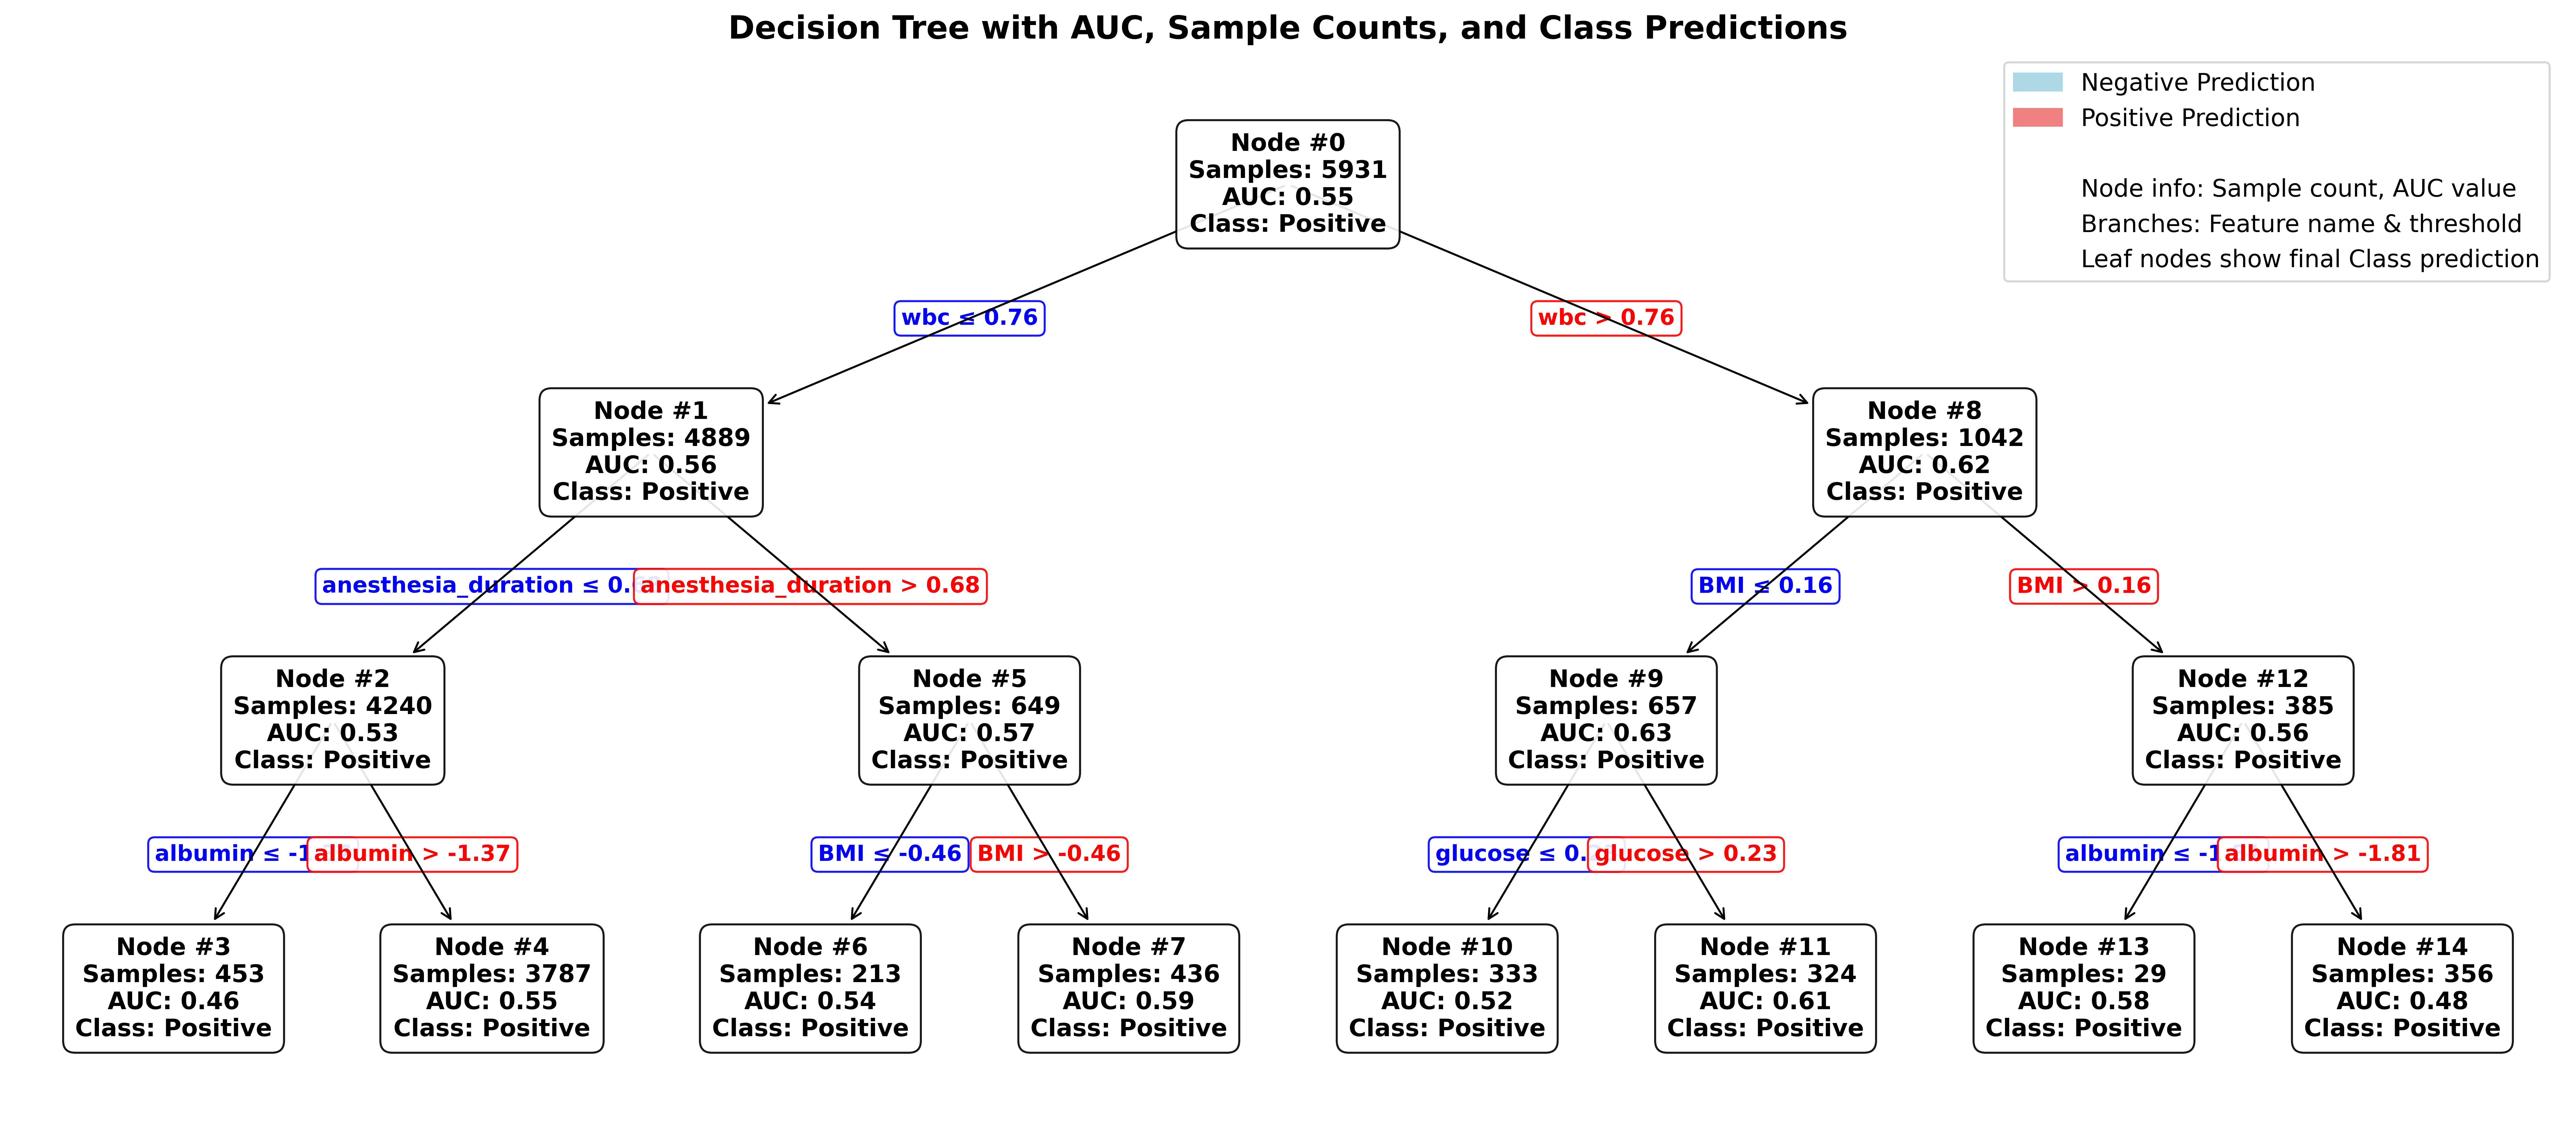

DecisionTreeClassifier(max_depth=3)

In [29]:
create_fixed_tree_viz(
     dt_model,
     X,
     y,
     X.columns,
     ['Negative', 'Positive'],
     'enhanced_decision_tree.png', max_depth=3
 )

In [35]:
###############################################################################
# ADDITION 2: Random Forest with Top Important Features Analysis
###############################################################################
print("\n----- ADDITION 2: Random Forest with Top Important Features -----")

# First, train a Random Forest model if you haven't already
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances and create a Series with feature names as index
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Now we can get the top 5 features
rf_top_features = rf_importances.sort_values(ascending=False).head(5).index.tolist()
print(f"Top 5 features from Random Forest: {rf_top_features}")

# Dictionary to track RF models with different feature subsets
rf_subset_results = {}

# Create a plot to compare performance
plt.figure(figsize=(14, 6), dpi=500)

# ROC Curves subplot
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line

# Precision-Recall Curves subplot
plt.subplot(1, 2, 2)

# Create a color cycle
colors = plt.cm.tab10(np.linspace(0, 1, 5))

# Train RF models with top 2, 3, 4, and 5 features
for i, n_features in enumerate(range(2, 6)):
    subset_features = rf_top_features[:n_features]
    print(f"\nTraining Random Forest with top {n_features} features: {subset

SyntaxError: unterminated string literal (detected at line 36) (1997314420.py, line 36)


----- ADDITION 2: Random Forest with Top Important Features -----
Top 5 features from Random Forest: ['wbc', 'albumin', 'BMI', 'anesthesia_duration', 'glucose']

Training Random Forest with top 2 features: ['wbc', 'albumin']
RF with top 2 features - AUROC: 0.6339, AUPRC: 0.2850

Training Random Forest with top 3 features: ['wbc', 'albumin', 'BMI']
RF with top 3 features - AUROC: 0.6660, AUPRC: 0.3298

Training Random Forest with top 4 features: ['wbc', 'albumin', 'BMI', 'anesthesia_duration']
RF with top 4 features - AUROC: 0.6968, AUPRC: 0.3412

Training Random Forest with top 5 features: ['wbc', 'albumin', 'BMI', 'anesthesia_duration', 'glucose']
RF with top 5 features - AUROC: 0.7055, AUPRC: 0.3426


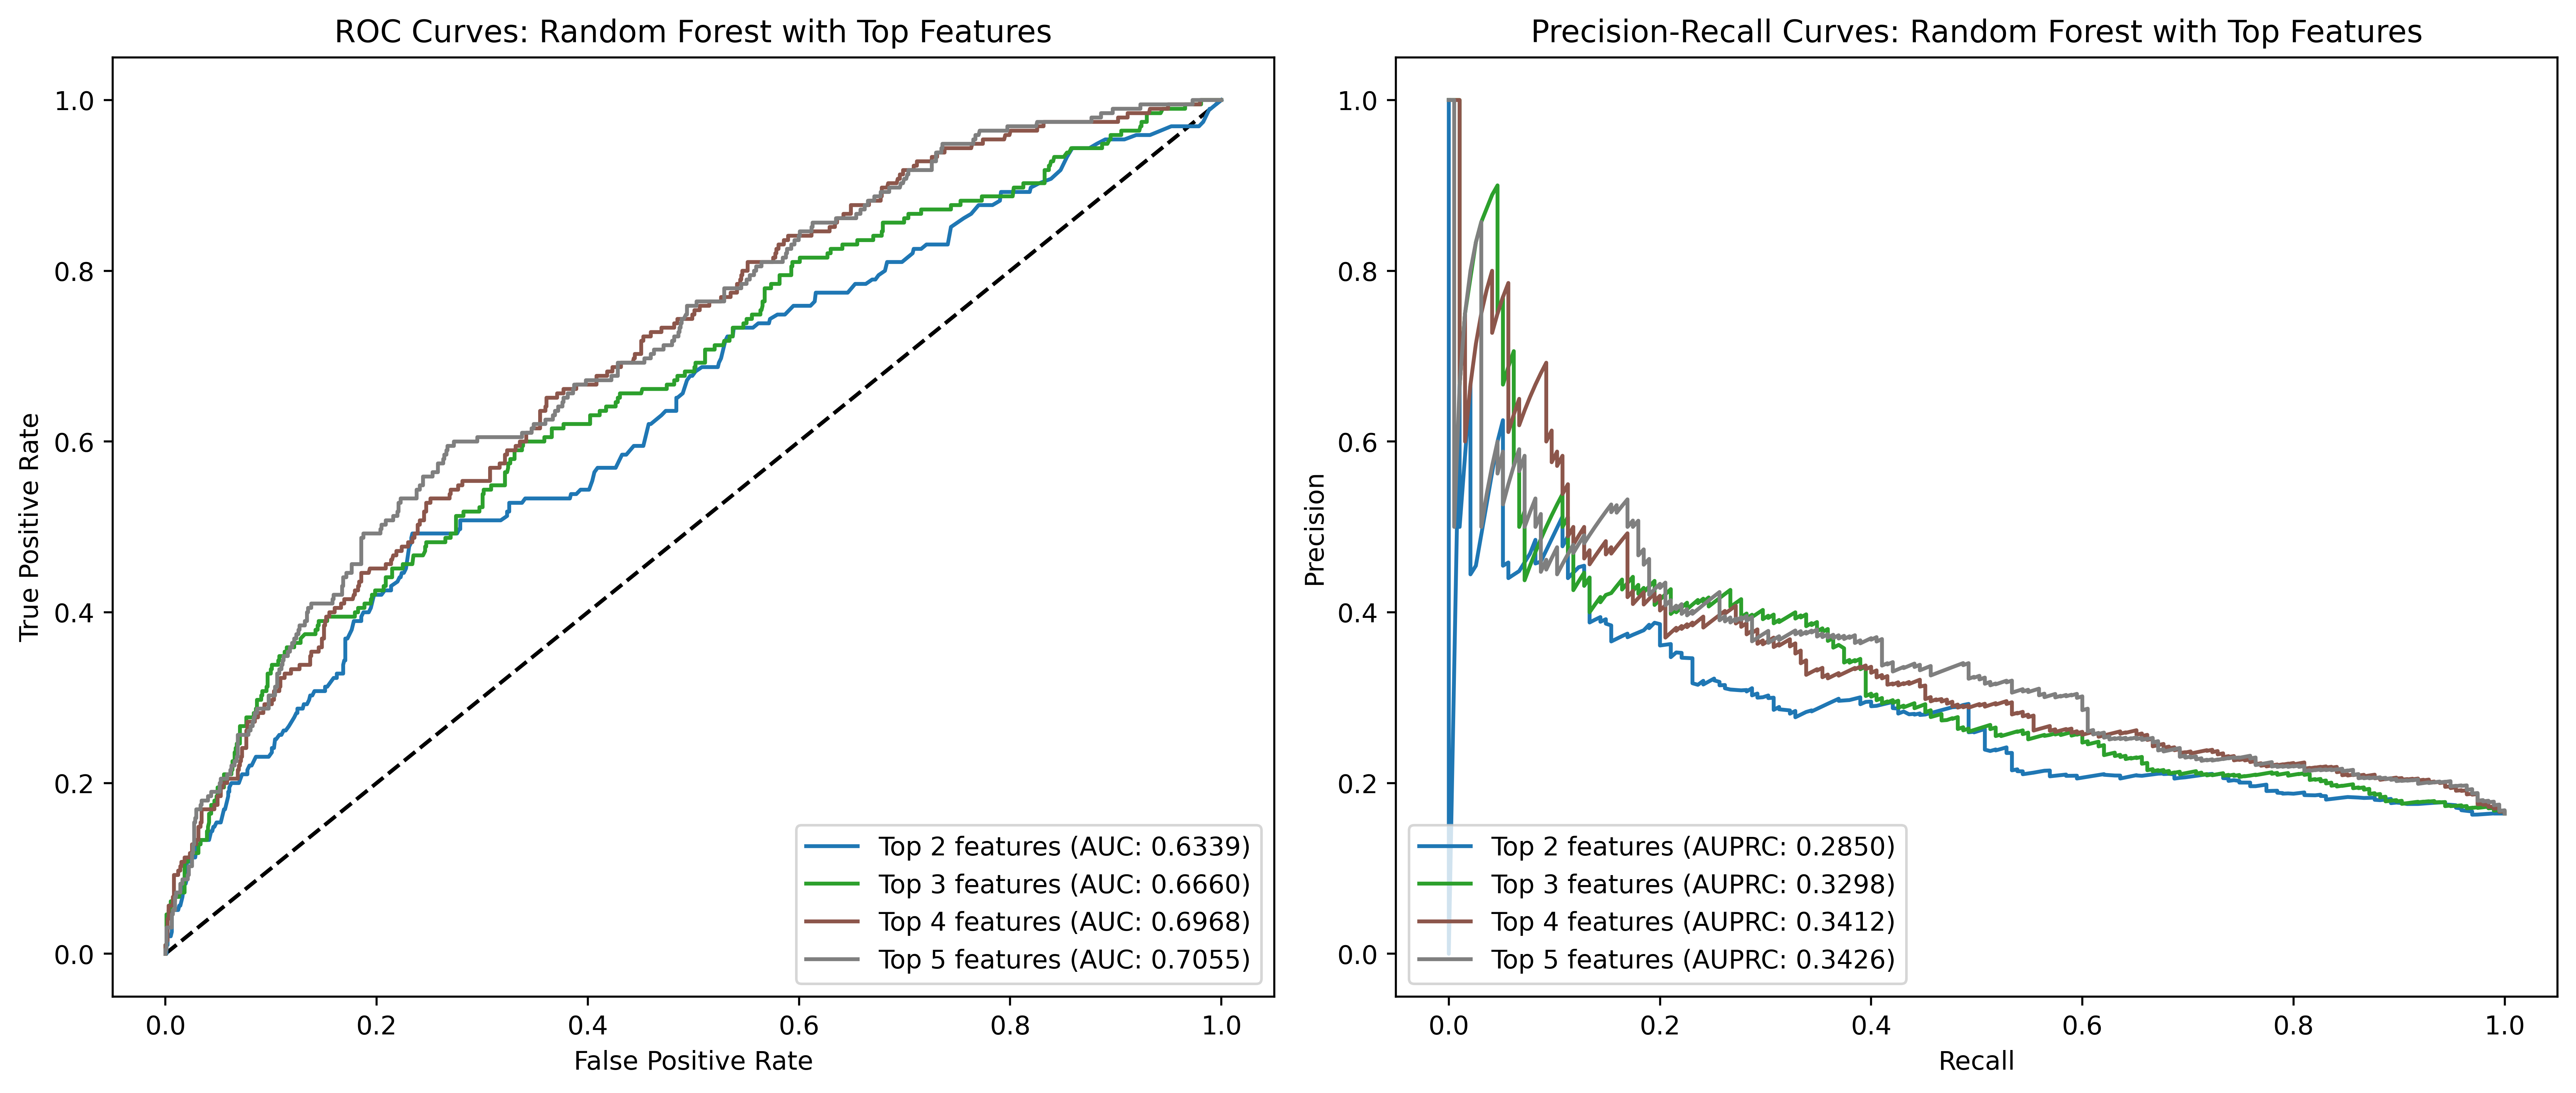


----- ADDITION 3: Comparing RF with FasterRisk -----


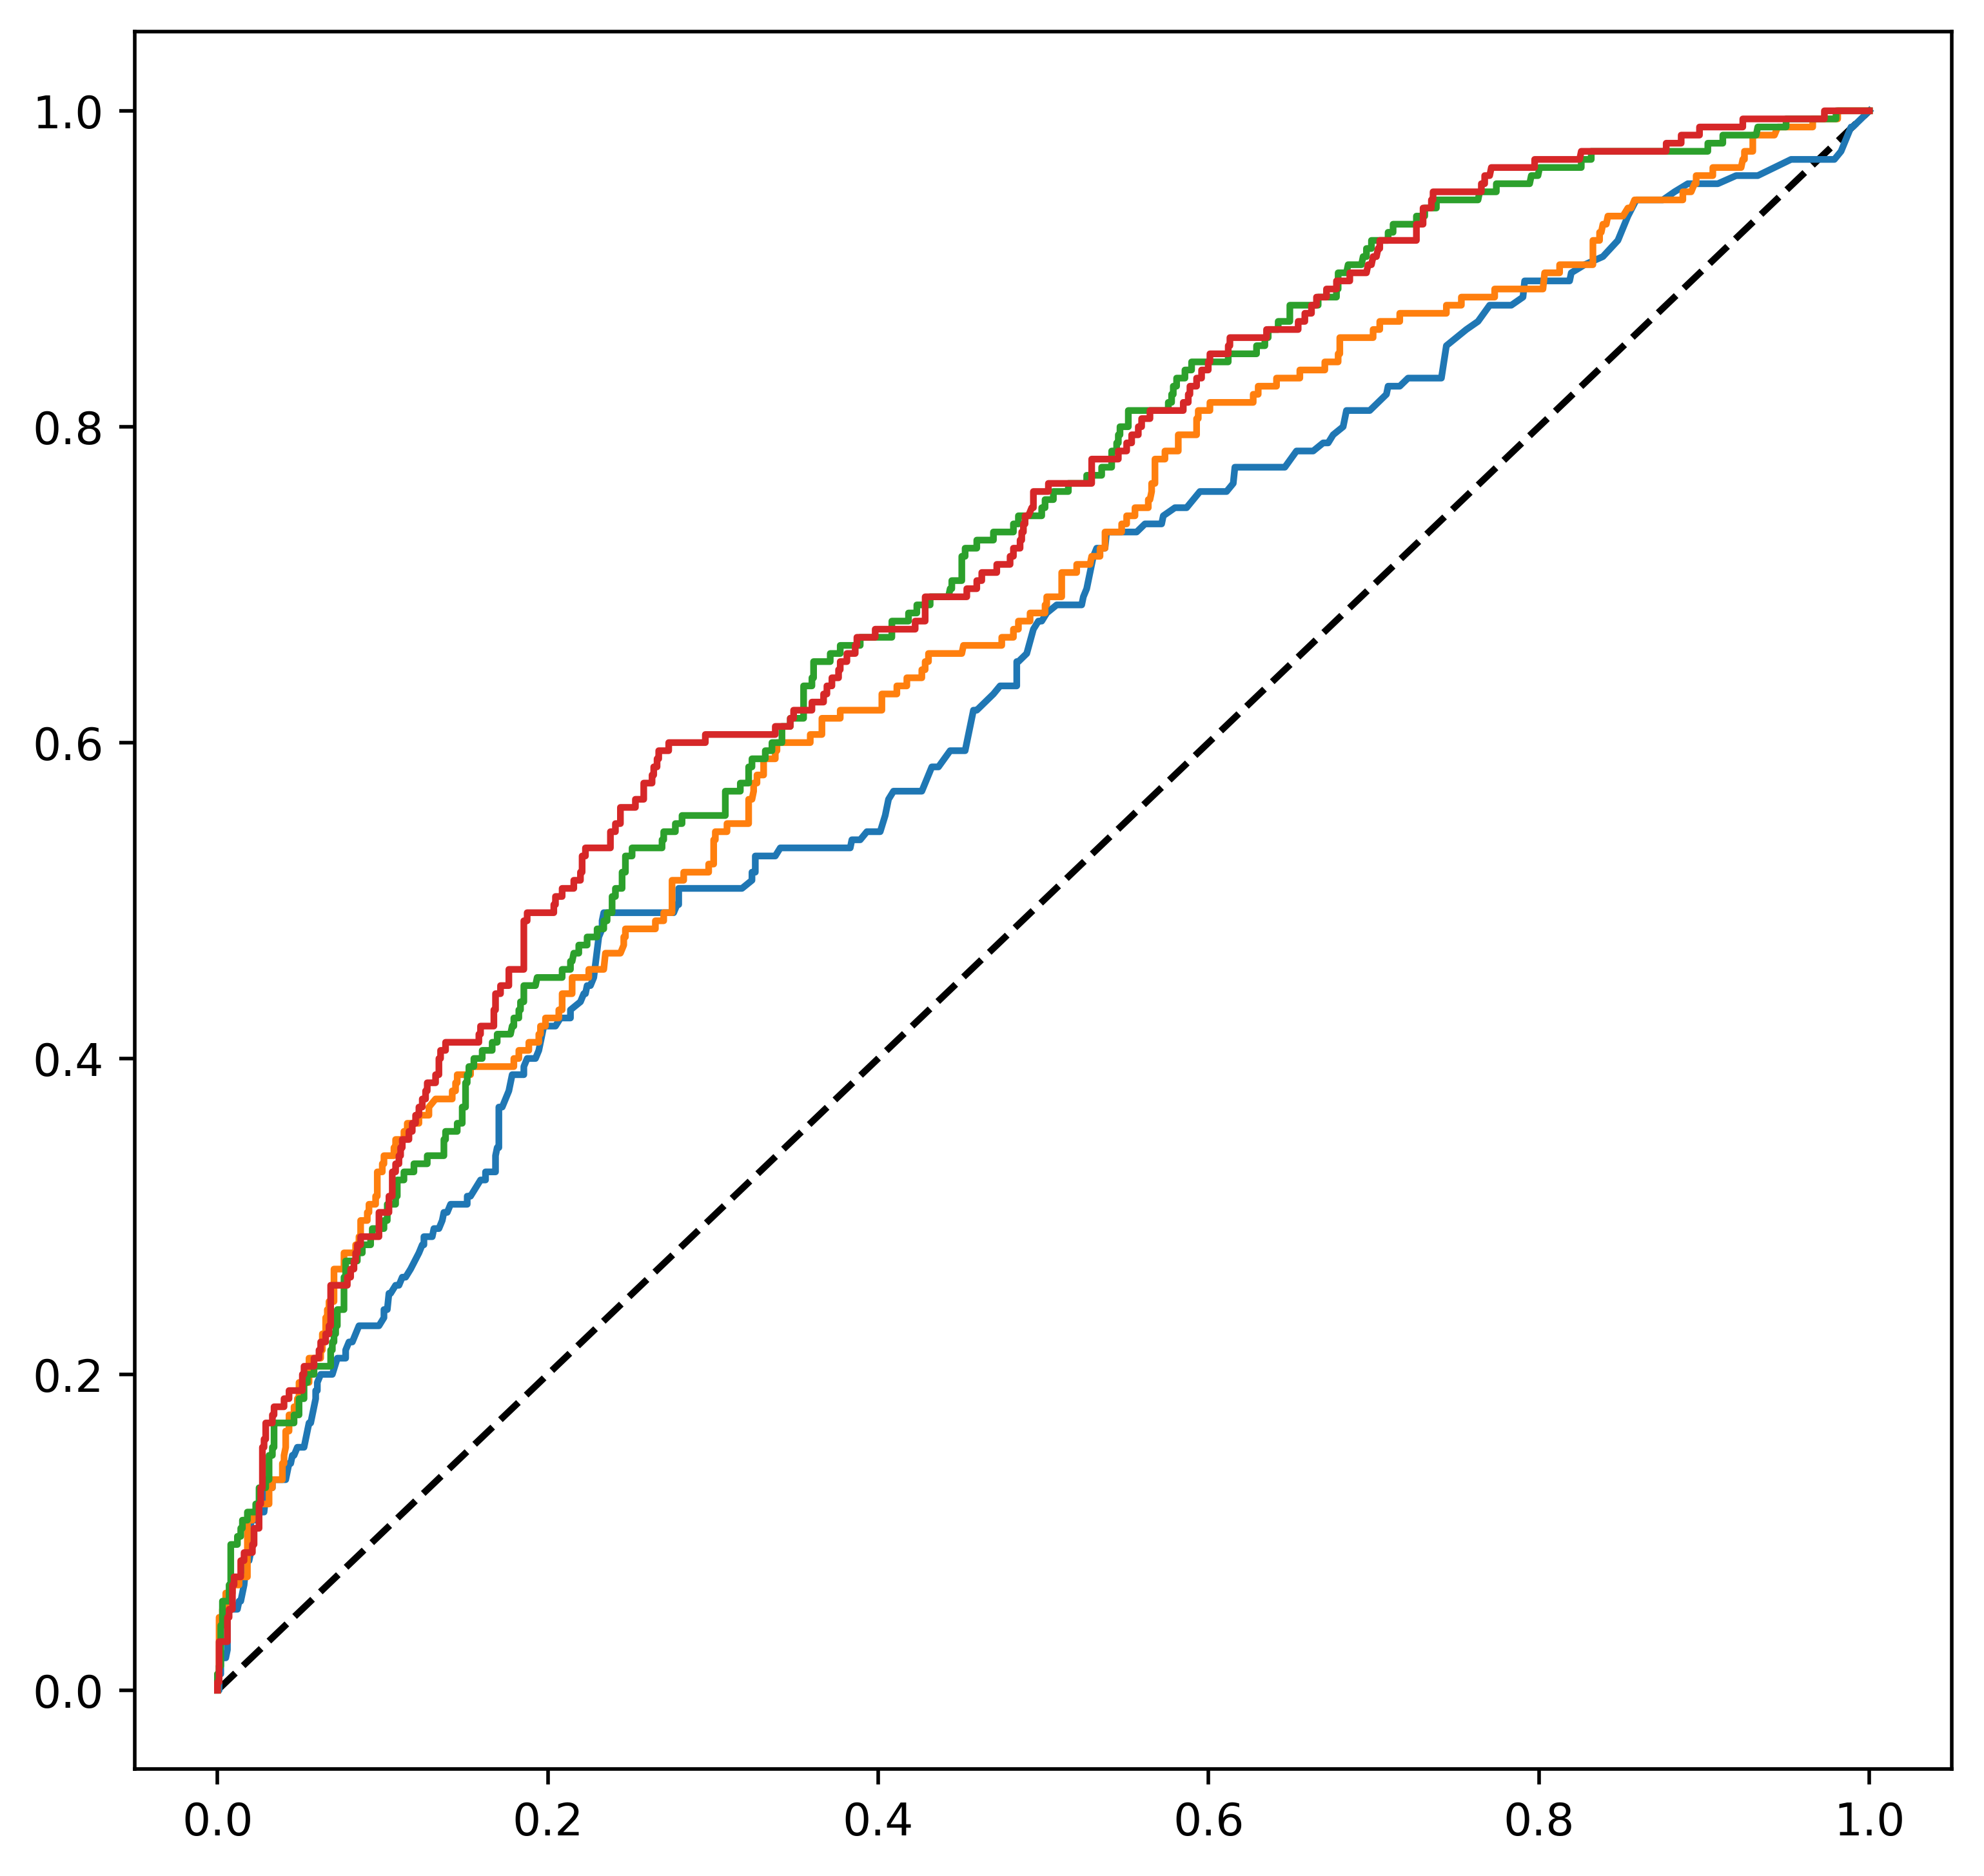

In [37]:
###############################################################################
# ADDITION 2: Random Forest with Top Important Features Analysis
###############################################################################
print("\n----- ADDITION 2: Random Forest with Top Important Features -----")

# First, train a Random Forest model if you haven't already
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances and create a Series with feature names as index
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Now we can get the top 5 features
rf_top_features = rf_importances.sort_values(ascending=False).head(5).index.tolist()
print(f"Top 5 features from Random Forest: {rf_top_features}")

# Dictionary to track RF models with different feature subsets
rf_subset_results = {}

# Create a plot to compare performance
plt.figure(figsize=(14, 6), dpi=500)

# ROC Curves subplot
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line

# Precision-Recall Curves subplot
plt.subplot(1, 2, 2)

# Create a color cycle
colors = plt.cm.tab10(np.linspace(0, 1, 5))

# Train RF models with top 2, 3, 4, and 5 features
for i, n_features in enumerate(range(2, 6)):
    subset_features = rf_top_features[:n_features]
    print(f"\nTraining Random Forest with top {n_features} features: {subset_features}")
    
    # Subset the data
    X_train_subset = X_train[subset_features]
    X_test_subset = X_test[subset_features]
    
    # Train a Random Forest on this subset
    rf_subset = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
    rf_subset.fit(X_train_subset, y_train)
    
    # Evaluate performance
    y_pred_proba = rf_subset.predict_proba(X_test_subset)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_proba)
    auprc = average_precision_score(y_test, y_pred_proba)
    
    # Store results
    rf_subset_results[f"RF-Top{n_features}"] = {
        'model': rf_subset,
        'features': subset_features,
        'auroc': auroc,
        'auprc': auprc
    }
    
    print(f"RF with top {n_features} features - AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")
    
    # Plot ROC curve
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, color=colors[i], label=f"Top {n_features} features (AUC: {auroc:.4f})")
    
    # Plot PR curve
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, color=colors[i], label=f"Top {n_features} features (AUPRC: {auprc:.4f})")

# Finalize ROC plot
plt.subplot(1, 2, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Random Forest with Top Features')
plt.legend(loc="lower right")

# Finalize PR plot
plt.subplot(1, 2, 2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves: Random Forest with Top Features')
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'rf_top_features_comparison.png'))
plt.show()

###############################################################################
# ADDITION 3: Compare RF with top features and FasterRisk
###############################################################################
print("\n----- ADDITION 3: Comparing RF with FasterRisk -----")

# Based on your code, it seems you should have y_test_prob_fr and possibly FasterRisk models defined
# If not, you'll need to add code to create them here

# Create fr_subset_results if it doesn't exist
fr_subset_results = {}

# If you have FasterRisk models, add them to fr_subset_results here
# As a placeholder (assuming you have y_test_prob_fr defined):
if 'y_test_prob_fr' in globals():
    fr_subset_results["FR-Top5"] = {
        'model': None,  # Placeholder for your model
        'features': rf_top_features,  # Using the same top features as RF
        'auroc': roc_auc_score(y_test, y_test_prob_fr),
        'auprc': average_precision_score(y_test, y_test_prob_fr)
    }

# Compare RF with top features and FasterRisk with different sparsity levels
plt.figure(figsize=(16, 7), dpi=500)

# ROC Curves for both types of models
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line

# Plot Random Forest models
for model_name, model_info in rf_subset_results.items():
    n_features = len(model_info['features'])
    subset_features = model_info['features']
    y_pred_proba = model_info['model'].predict_proba(X_test[subset_features])[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, linestyle='-', 
             label=f"RF: {n_features} features (AUC: {model_info['auroc']:.4f})")

# Plot FasterRisk models 
for model_name, model_info in fr_subset_results.items():
    n_features = len(model_info['features'])
    if model_name == "FR-Top5":
        y_pred_proba = y_test_prob_fr
    else:
        risk_classifier_i = model_info['model'].risk_classifier
        y

In [ ]:
# Compare RF with top features and FasterRisk with different sparsity levels
plt.figure(figsize=(16, 7), dpi=500)

# ROC Curves for both types of models
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line

# Plot Random Forest models
for model_name, model_info in rf_subset_results.items():
    n_features = len(model_info['features'])
    subset_features = model_info['features']
    y_pred_proba = model_info['model'].predict_proba(X_test[subset_features])[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, linestyle='-', 
             label=f"RF: {n_features} features (AUC: {model_info['auroc']:.4f})")

# Plot FasterRisk models 
for model_name, model_info in fr_subset_results.items():
    n_features = len(model_info['features'])
    if model_name == "FR-Top5":
        y_pred_proba = y_test_prob_fr
    else:
        risk_classifier_i = model_info['model'].risk_classifier
        y_pred_proba = risk_classifier_i.predict_prob(X=X_test.values)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, linestyle='--',
             label=f"FR: {n_features} features (AUC: {model_info['auroc']:.4f})")

# PR Curves
plt.subplot(1, 2, 2)

# Plot Random Forest models
for model_name, model_info in rf_subset_results.items():
    n_features = len(model_info['features'])
    subset_features = model_info['features']
    y_pred_proba = model_info['model'].predict_proba(X_test[subset_features])[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, linestyle='-',
             label=f"RF: {n_features} features (AUPRC: {model_info['auprc']:.4f})")

# Plot FasterRisk models
for model_name, model_info in fr_subset_results.items():
    n_features = len(model_info['features'])
    if model_name == "FR-Top5":
        y_pred_proba = y_test_prob_fr
    else:
        risk_classifier_i = model_info['model'].risk_classifier
        y_pred_proba = risk_classifier_i.predict_prob(X=X_test.values)
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, linestyle='--',
             label=f"FR: {n_features} features (AUPRC: {model_info['auprc']:.4f})")

# Finalize ROC plot
plt.subplot(1, 2, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: RF vs FasterRisk with Different Feature Counts')
plt.legend(loc="lower right")

# Finalize PR plot
plt.subplot(1, 2, 2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves: RF vs FasterRisk with Different Feature Counts')
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'rf_vs_fr_comparison.png'))
plt.show()

# Print combined comparison table
print("\nCombined Performance Comparison (RF vs FasterRisk):")
print("{:<15} {:<10} {:<10} {:<10}".format("Model", "Features", "AUROC", "AUPRC"))
print("-" * 45)

# RF Models
for model_name in sorted(rf_subset_results.keys()):
    model_info = rf_subset_results[model_name]
    n_features = len(model_info['features'])
    auroc = model_info['auroc']
    auprc = model_info['auprc']
    print("{:<15} {:<10d} {:<10.4f} {:<10.4f}".format(model_name, n_features, auroc, auprc))

# FasterRisk Models
for model_name in sorted(fr_subset_results.keys()):
    model_info = fr_subset_results[model_name]
    n_features = len(model_info['features'])
    auroc = model_info['auroc']
    auprc = model_info['auprc']
    print("{:<15} {:<10d} {:<10.4f} {:<10.4f}".format(model_name, n_features, auroc, auprc))

# Save combined comparison to CSV
combined_rows = []
for model_type, results_dict in [("RandomForest", rf_subset_results), ("FasterRisk", fr_subset_results)]:
    for model_name, model_info in results_dict.items():
        combined_rows.append({
            'Model': model_name,
            'Type': model_type,
            'Features_Count': len(model_info['features']),
            'Features': ', '.join(model_info['features']),
            'AUROC': model_info['auroc'],
            'AUPRC': model_info['auprc']
        })

combined_df = pd.DataFrame(combined_rows)
combined_df.to_csv(os.path.join(plots_dir, 'combined_model_comparison.csv'), index=False)
print(f"\nCombined model comparison saved to {os.path.join(plots_dir, 'combined_model_comparison.csv')}")

In [ ]:
# 1. Modified plot for main model comparison - only showing base models with all features
plt.figure(figsize=(12, 5), dpi=500)

plt.subplot(1, 2, 1)
for model_name in results:  # Only include the original models, not the subset versions
    if model_name == "FasterRisk":
        y_pred_proba = results[model_name]['model'].predict_proba(X_test.values)[:, 1]
    else:
        y_pred_proba = results[model_name]['model'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUROC: {results[model_name]['auroc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Base Models', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)

# Plot PR curves
plt.subplot(1, 2, 2)
for model_name in results:  # Only include the original models
    if model_name == "FasterRisk":
        y_pred_proba = results[model_name]['model'].predict_proba(X_test.values)[:, 1]
    else:
        y_pred_proba = results[model_name]['model'].predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f"{model_name} (AUPRC: {results[model_name]['auprc']:.4f})")

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Base Models', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'base_model_comparison_curves.png'))
plt.show()

# 2. Improved decision tree visualization with better readability
def plot_improved_decision_tree(tree_model, feature_names, class_names, X, y, filename=None):
    """Plot a more readable decision tree with branch text and no Gini index"""
    from sklearn import tree as sktree
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Prepare figure with larger size
    plt.figure(figsize=(16, 10), dpi=500)
    
    # Get the tree text representation to parse
    tree_text = sktree.export_text(tree_model, feature_names=list(feature_names))
    
    # Convert data to numpy if it's DataFrame
    X_array = X.values if hasattr(X, 'values') else X
    y_array = y.values if hasattr(y, 'values') else y
    
    # Function to draw the decision tree
    def create_tree_plot(ax):
        # Use sklearn's plot_tree with customized parameters
        sktree.plot_tree(
            tree_model,
            feature_names=feature_names,
            class_names=class_names,
            filled=True,
            rounded=True,
            fontsize=9,
            ax=ax,
            precision=2,
            label='none'  # Prevents automatic labeling
        )
        
        # Customize the text on each node
        for i, (text_obj, bbox_obj) in enumerate(zip(
                ax.texts, [obj for obj in ax.get_children() if isinstance(obj, plt.Rectangle)])):
            # Get node position
            x, y = bbox_obj.get_xy()
            width = bbox_obj.get_width()
            height = bbox_obj.get_height()
            
            # Extract node info from the tree structure
            tree = tree_model.tree_
            node_id = i
            
            # Check if it's a leaf node
            is_leaf = tree.children_left[node_id] == -1
            
            if is_leaf:
                # Get class distribution
                value = tree.value[node_id][0]
                total_samples = np.sum(value)
                class_probs = value / total_samples
                majority_class = np.argmax(class_probs)
                confidence = class_probs[majority_class]
                
                # Calculate accuracy on this node
                samples_in_leaf = np.where(tree_model.apply(X_array) == node_id)[0]
                if len(samples_in_leaf) > 0:
                    node_y = y_array[samples_in_leaf]
                    accuracy = np.mean(node_y == majority_class)
                    accuracy_text = f"Accuracy: {accuracy:.2f}"
                else:
                    accuracy_text = ""
                
                class_label = class_names[majority_class] if majority_class < len(class_names) else f"Class {majority_class}"
                node_text = f"Class: {class_label}\nSamples: {total_samples}\nConfidence: {confidence:.2f}\n{accuracy_text}"
            else:
                # Decision node
                feature = tree.feature[node_id]
                threshold = tree.threshold[node_id]
                feature_name = feature_names[feature] if feature < len(feature_names) else f"feature {feature}"
                samples = tree.n_node_samples[node_id]
                
                # Add decision labels to the branches
                # Left branch - less than or equal to
                left_child = tree.children_left[node_id]
                left_x = bbox_obj.get_x() - width/4
                left_y = bbox_obj.get_y() - height/2
                if left_child != -1:
                    ax.annotate(f"≤ {threshold:.2f}", 
                                xy=(bbox_obj.get_x() + width/2, bbox_obj.get_y()),
                                xytext=(left_x + width/4, left_y + height/4),
                                fontsize=8, color='blue',
                                arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='blue'))
                
                # Right branch - greater than
                right_child = tree.children_right[node_id]
                right_x = bbox_obj.get_x() + width + width/4
                right_y = bbox_obj.get_y() - height/2
                if right_child != -1:
                    ax.annotate(f"> {threshold:.2f}", 
                                xy=(bbox_obj.get_x() + width/2, bbox_obj.get_y()),
                                xytext=(right_x - width/4, right_y + height/4),
                                fontsize=8, color='red',
                                arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='red'))
                
                # Calculate AUC for this split
                try:
                    from sklearn.metrics import roc_auc_score
                    
                    # Get predictions based on this feature split
                    y_pred = (X_array[:, feature] > threshold).astype(int)
                    split_auc = roc_auc_score(y_array, y_pred)
                    if split_auc < 0.5:
                        split_auc = 1 - split_auc  # Invert if needed
                        
                    auc_text = f"AUC: {split_auc:.2f}"
                except:
                    auc_text = ""
                
                node_text = f"Feature: {feature_name}\nThreshold: {threshold:.2f}\nSamples: {samples}\n{auc_text}"
            
            # Replace the node text
            text_obj.set_text(node_text)
    
    # Create the tree plot
    ax = plt.gca()
    create_tree_plot(ax)
    
    # Add title and adjust layout
    plt.title('Decision Tree - Enhanced Readability', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save if filename provided
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        print(f"Enhanced decision tree visualization saved to {filename}")
    
    plt.show()

# Create the improved visualization
print("\n----- Improved Decision Tree Visualization -----")
plot_improved_decision_tree(
    dt_model,
    X.columns,
    ['Negative', 'Positive'],
    X_train,
    y_train,
    os.path.join(plots_dir, 'decision_tree_improved.png')
)
print("Improved decision tree visualization completed successfully")

In [38]:
y

0        1.0
8        0.0
9        1.0
11       0.0
16       0.0
        ... 
11740    0.0
11741    0.0
11742    0.0
11743    0.0
11744    0.0
Name: vent, Length: 5931, dtype: float64

In [40]:
np.sum(y==1)

972